# Assignment

In [4]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import random

size_board = 4
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [10]:
##  Define functions

def EpsilonGreedy_Policy(Qvalues, epsilon, allowed_a):
    
    N_a=np.shape(Qvalues)[0]
    a = list(range(0, N_a))
    a = [i for idx, i in enumerate(a) if allowed_a[idx]]
    Qvalues = [i for idx, i in enumerate(Qvalues) if allowed_a[idx]]

    rand_value=np.random.uniform(0,1)
 ## epsilon is probability that we go random
    rand_a=rand_value<epsilon

    if rand_a==True:
        
        a = random.choice(a)

    else:
        idx=np.argmax(Qvalues)
        a = a[idx]
            
    return a


def ComputeQvalues(W1, W2, bias_W1, bias_W2, X, hiddenactivfunction , outeractivfunction):
    ## Qvalues=np.matmul(W2, np.matmul(W1,X)) ## this is direct computation of hidden layer and then output layer, without applying any non linear activation function
    ## below is a better solution:
    # Neural activation: input layer -> hidden layer
    H1 = np.matmul(W1,X)+bias_W1 ## make sure that bias_W1 does not need to be transposed
    # if hidden activ function is given:
    if (hiddenactivfunction == 1):
        H1 = np.round(1/(1+np.exp(-H1)), 5)
        
    Qvalues = np.matmul(W2,H1) + bias_W2
    
    #if outer activ function is given
    if (outeractivfunction == 1):
        Qvalues = np.round(1/(1+np.exp(- Qvalues)), 5)

    return Qvalues

In [39]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 


S,X,allowed_a=env.Initialise_game()



N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES



## INITALISE YOUR NEURAL NETWORK... Here weights from input to hidden layer and from the hidden layer to output layer are initialized
W1=np.random.randn(N_h,N_in)/1000
W2=np.random.randn(N_a,N_h)/1000


##W1 = np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in))
##W2 = np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h))


bias_W1 = np.zeros((N_h,))

bias_W2 = np.zeros((N_a,))



# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.8     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.05      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 1000 # THE NUMBER OF GAMES TO BE PLAYED 

hiddenactivfunction = 1
outeractivfunction = 0

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [40]:
# SARSA

for n in range(N_episodes):
    S,X,allowed_a=env.Initialise_game()
   
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
                               
    Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, hiddenactivfunction , outeractivfunction)

    
    a=EpsilonGreedy_Policy(Qvalues,epsilon_f, allowed_a)
    
    while (Done==0 and i<50):                           ## START THE EPISODE
       
        Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, hiddenactivfunction , outeractivfunction)   
        print(Qvalues)
        S_next, X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            R_save[n,]=np.copy(R)
            #print(i)
            N_moves_save[n,]=i
           
          
             ## update W2 and B2   
            dEdQ=R-Qvalues[a]
            dQdY = 1  
            if outeractivfunction == 1:
                    dQdY = Qvalues[a]*(1-Qvalues[a])
                    
          
            H = np.matmul(W1,X) + bias_W1
            if hiddenactivfunction == 1:
                     H = np.round(1/(1+np.exp(-H)), 5)
            dYdW = H

        
            W2[a,:]=W2[a,:]+eta*dEdQ*dQdY*dYdW
            bias_W2[a]=bias_W2[a]+eta*dEdQ*dQdY
            
            
             ## update W1 and B1 after W2 and B2 were updated
            
            
            if hiddenactivfunction == 1:
                dYdZ =  (W2[a,:].reshape(1, 200) * H*(1-H).reshape(1, 200)).reshape(200,1)
            else:
                 dYdZ =  W2[a,:].reshape(200, 1)
        
                        
            W1[:,:]=W1[:,:]+ eta*dEdQ*dQdY*dYdZ*dZDW 
            bias_W1=bias_W1+eta*dEdQ*dQdY*dYdZ.reshape(200,)  
            
            break
        
       
  
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            Qvalues1=ComputeQvalues(W1, W2, bias_W1, bias_W2, X_next, hiddenactivfunction , outeractivfunction)
            
            a1=EpsilonGreedy_Policy(Qvalues1,epsilon_f, allowed_a_next)

            # Compute the delta
         
            
            delta=R+gamma*1- Qvalues1[a1]- Qvalues[a]

            # Update the weights
    
            R_save[n,]=np.copy(R)
            #print(i)
            N_moves_save[n,]=i
           
          
             ## update W2 and B2   
            dEdQ=R-Qvalues[a]
            dQdY = 1  
            if outeractivfunction == 1:
                    dYdQ = Qvalues[a]*(1-Qvalues[a])
                    
          
            H = np.matmul(W1,X) + bias_W1
            if hiddenactivfunction == 1:
                     H = np.round(1/(1+np.exp(-H)), 5)
            dYdW = H
    
        
            W2[a,:]=W2[a,:]+eta*dEdQ*dQdY*dYdW
            bias_W2[a]=bias_W2[a]+eta*dEdQ*dQdY
            
            
             ## update W1 and B1 after W2 and B2 were updated
            
            
           
            
            if hiddenactivfunction == 1:
                dYdZ =  (W2[a,:].reshape(1, 200) * H*(1-H).reshape(1, 200)).reshape(200,1)
            else:
                 dYdZ =  W2[a,:].reshape(200, 1)
        
            dZDW = X.reshape(1, 58)        
            W1[:,:]=W1[:,:]+ eta*dEdQ*dQdY*dYdZ*dZDW 
            bias_W1=bias_W1+ eta*dEdQ*dQdY*dYdZ.reshape(200,) 
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        a = np.copy(a1)

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
        
    
    

[-0.00955468  0.00241031  0.01173511  0.00880191 -0.00114875 -0.0082621
  0.0053703  -0.00384399 -0.00320232  0.00128608  0.00115285 -0.01327794
  0.00674832 -0.00243347 -0.00585328 -0.00737081 -0.00199935  0.00248675
 -0.00420395  0.00349364 -0.00936878  0.01037661 -0.00179941  0.00812104
  0.00377091  0.00688983  0.00220685  0.00348644  0.00432136  0.00122303
 -0.00910501  0.00810971]
[-0.00955834  0.00240769  0.01173714  0.00880361 -0.00114412 -0.00826354
  0.00537127 -0.00384041 -0.00319634  0.00129477  0.00115804 -0.01328002
  0.00675449 -0.00244109 -0.0058485  -0.0073646  -0.00200029  0.00248733
 -0.00419977  0.00349471 -0.0093668   0.01036972 -0.00179885  0.00811485
  0.0037697   0.00688464  0.00221014  0.00348011  0.00433259  0.00122501
 -0.00747914  0.00811736]
[-0.00956117  0.00241629  0.01174896  0.00723397 -0.00113867 -0.00826531
  0.00536834 -0.00382631 -0.00319347  0.00129052  0.00116807 -0.01327044
  0.00675079 -0.00243211 -0.00584229 -0.00735509 -0.00200171  0.00248689


[-0.00434742  0.00240857  0.00650801  0.00222763 -0.00094075 -0.00826418
  0.00297885  0.14406456  0.14446582  0.00048087  0.00078529 -0.01090154
  0.12254231 -0.00243294 -0.00584444 -0.00736608 -0.00199452  0.00248883
 -0.00285196  0.00349016 -0.00937524  0.00214683 -0.00179928  0.15210418
  0.00254077  0.00313253  0.0018065   0.00286658  0.00355215  0.00080753
 -0.00613481  0.00369401]
[-0.00435319  0.00240591  0.00533749  0.00222655 -0.00093385 -0.0082654
  0.002974    0.14405616  0.14445031  0.00046584  0.00078285 -0.01090087
  0.12253549 -0.00243068 -0.00585051 -0.00736771 -0.00198992  0.00249198
 -0.00283535  0.00348867 -0.00936869  0.00215164 -0.00180336  0.15208971
  0.00254289  0.00314532  0.00180757  0.00286814  0.00355621  0.00082138
 -0.00613738  0.00370825]
[-0.00435027  0.00241046  0.00534086  0.00222014 -0.00094808 -0.00825858
  0.00298155  0.14405876  0.14444587  0.00049007  0.00078223 -0.01089544
  0.12253802 -0.00242298 -0.00585135 -0.00735651 -0.00197998  0.00249426


[-0.00434965  0.00133537  0.00533969  0.00083397 -0.00078097 -0.00678751
  0.00112199  0.09721461  0.09749199  0.00048791  0.17885992 -0.00896165
  0.04585523 -0.00244512 -0.00584575 -0.00736372 -0.00199239  0.00249274
 -0.00233534  0.00349241 -0.00936957  0.00080409 -0.00179983  0.152116
  0.00141513  0.00096584  0.00082739  0.0007151   0.0016116   0.00067619
 -0.00613819  0.00112569]
[-0.00436195  0.00134066  0.00533224  0.00082442 -0.00076231 -0.00678784
  0.00112234  0.07987271  0.09749335  0.00047243  0.17885359 -0.00895572
  0.04584681 -0.00243822 -0.00585585 -0.00736526 -0.00199159  0.00249862
 -0.00231932  0.00349041 -0.00936353  0.00080518 -0.00179605  0.15210665
  0.00140605  0.00096425  0.00081424  0.00072194  0.00161324  0.00068079
 -0.00614144  0.0011397 ]
[-0.00434117  0.0013299   0.00533814  0.00082424 -0.00078663 -0.00679156
  0.00111726  0.07986577  0.09749145  0.00048533  0.14694982 -0.00895349
  0.04585921 -0.00243874 -0.00585291 -0.00736224 -0.00198797  0.00249553
 

[-0.00358161  0.00090908  0.00439925  0.00067872 -0.00063488 -0.00678958
  0.00110492  0.0075481   0.02997114  0.00032095  0.03048995 -0.00603892
  0.00640571 -0.00243581 -0.00584796 -0.00735903 -0.00199909  0.00204723
 -0.00191002  0.0035001  -0.00937772  0.03714348 -0.00179189  0.26015262
  0.00140893  0.00065156  0.00067381  0.00049217  0.00133569  0.00057327
 -0.00502981  0.00113609]
[-0.0035936   0.0008893   0.00438453  0.00068095 -0.00064317 -0.00679221
  0.00110408  0.00754534  0.02997557  0.00032437  0.03048603 -0.00603055
  0.00641505 -0.00243266 -0.00585583 -0.00737305 -0.00198759  0.00205243
 -0.00191437  0.00350108 -0.00936949  0.03051456 -0.00180283  0.26017397
  0.0014044   0.00065085  0.00067311  0.00048575  0.00132905  0.00055396
 -0.00504141  0.00114258]
[-0.00357771  0.00090167  0.00439117  0.00069136 -0.00063284 -0.00679085
  0.00111013  0.00620104  0.02996619  0.00032253  0.03048448 -0.00604835
  0.00640971 -0.0024451  -0.00584558 -0.00737178 -0.00199606  0.00204533

[-0.00357978  0.0007395   0.00439383  0.00037755 -0.00063429 -0.00678964
  0.00112703  0.00961782  0.0299666   0.00027411  0.03833618 -0.00603653
  0.00355505 -0.00200186 -0.00584932 -0.00605323  0.1768614   0.00167846
 -0.0019053   0.00349106 -0.0093669   0.00289438 -0.00180582  0.26018767
  0.00095421  0.00053299  0.00038191  0.00049403  0.00133132  0.00054951
 -0.00279688  0.00092142]
[-0.0035824   0.00075502  0.00439332  0.00037132 -0.00062867 -0.00679632
  0.0011291   0.00962131  0.02996867  0.00027496  0.21000156 -0.00604058
  0.00354596 -0.00199609 -0.00584017 -0.00604812  0.17684609  0.0016841
 -0.00190544  0.0034954  -0.00937509  0.00288649 -0.00180001  0.26015647
  0.00095367  0.00051701  0.00038638  0.0004861   0.00134257  0.00056109
 -0.00279402  0.00092056]
[-0.0035821   0.0007438   0.00439014  0.00037265 -0.00063385 -0.00678148
  0.0011127   0.00961738  0.0299528   0.00026802  0.2099865  -0.00603728
  0.00355416 -0.00198379 -0.0058523  -0.0060549   0.1768636   0.00168011


 -0.00279981  0.00076747]
[-0.00293889  0.0006085   0.00437276  0.00038001 -0.00064376 -0.00679139
  0.00063038  0.00091175  0.01120953  0.06686893  0.0041341  -0.00604043
  0.00060282 -0.00199167 -0.00584903 -0.00604439  0.1452781   0.00168719
 -0.0019151   0.00287205 -0.00936866  0.09944516 -0.00147476  0.21373672
  0.00077736  0.00030098  0.00031271  0.00049087  0.000898    0.00053842
 -0.00279109  0.00075182]
[-0.00293384  0.00059433  0.00437958  0.00037532 -0.00065165 -0.00680922
  0.00050411  0.00090643  0.01120421  0.06687537  0.004137   -0.00603723
  0.00061209 -0.00199905 -0.00585144 -0.00604378  0.14528084  0.00169506
 -0.00191105  0.00286967 -0.00936246  0.09944866 -0.0014873   0.21373575
  0.00079203  0.00030084  0.00031222  0.00047718  0.00088433  0.00054547
 -0.00279737  0.00076426]
[-0.00294537  0.00060322  0.00438797  0.00037884 -0.00063424 -0.00680821
  0.00050463  0.00091053  0.01121141  0.0668697   0.00413421 -0.00604748
  0.00060988 -0.00200375 -0.00584696 -0.006055

[-0.00293971  0.00049715  0.00361539  0.00038121 -0.00043748 -0.00679766
  0.00021506  0.01693168  0.0075658   0.00857669  0.00412927 -0.006048
  0.0004054  -0.00199992 -0.00584575 -0.00605031  0.02033953  0.00168339
 -0.00129017  0.00089094 -0.00936997  0.01391362 -0.00147732  0.14425917
  0.00042716  0.00023806  0.00030379  0.0004036   0.00089264  0.0004643
 -0.00280257  0.0005188 ]
[-0.0029458   0.00048397  0.00361381  0.00038706 -0.0004322  -0.00679404
  0.00022179  0.01693155  0.00756825  0.00858076  0.00412855 -0.00605188
  0.00041185 -0.00200425 -0.00584773 -0.00605144  0.02033519  0.00168296
 -0.00129049  0.00089547 -0.00937016  0.01143361 -0.00147891  0.14426568
  0.00043484  0.00023889  0.000312    0.0003981   0.00089107  0.00046062
 -0.00280384  0.00051555]
[-0.00294275  0.0005038   0.00361036  0.00039501 -0.00041841 -0.00679306
  0.00022927  0.01391054  0.00756894  0.00857224  0.00412656 -0.00605211
  0.00039796 -0.00200941 -0.00584429 -0.00605692  0.02033558  0.00167191
 -

[-2.93976463e-03  4.07842421e-04  1.64874275e-03  2.10268028e-04
 -4.37406810e-04 -5.58462849e-03  1.75494832e-04  9.98443892e-02
  2.82959114e-03  8.13679219e-04  8.60521993e-04 -6.04801558e-03
  4.05297150e-04 -1.99992637e-03 -5.84582029e-03 -4.96913441e-03
  1.89770573e-01  1.38376227e-03 -1.06180416e-03  8.90905717e-04
 -9.37006872e-03  8.82732492e-04 -1.47726622e-03  1.44259577e-01
  2.84905350e-04  1.28686853e-04  3.03807945e-04  3.30785554e-04
  8.92626052e-04  3.14106271e-04 -2.80257933e-03  2.85365090e-04]
[-2.94576247e-03  3.94688862e-04  1.64714286e-03  2.16252284e-04
 -4.32140461e-04 -5.58114431e-03  1.82344545e-04  9.98441283e-02
  2.83210285e-03  8.17814059e-04  8.60032860e-04 -6.05183017e-03
  4.11688753e-04 -2.00424649e-03 -5.84765389e-03 -4.97034589e-03
  1.89765743e-01  1.38331857e-03 -1.06208412e-03  8.95501252e-04
 -9.37027155e-03  7.28933741e-04 -1.47899573e-03  1.44266592e-01
  2.92514349e-04  1.29423990e-04  3.11914526e-04  3.25210661e-04
  8.91066555e-04  3.1036

[-2.94087915e-03  8.14323931e-02  1.65028779e-03  2.00617653e-04
 -3.40741266e-04 -5.57939019e-03  1.54018561e-04  2.38483429e-03
  2.82938928e-03  2.50428160e-04  1.83016281e-04 -6.03838055e-03
  2.68345282e-04 -1.99049608e-03 -5.84900419e-03 -3.35140180e-03
  1.28066832e-01  1.38443643e-03 -7.02823755e-04  8.94384748e-04
 -9.38179044e-03  2.33158977e-04 -1.47175686e-03  1.64665516e-01
  2.36230823e-04  8.02920901e-05  2.55701884e-04  1.87220097e-04
  2.77108906e-04  2.14952087e-04 -2.78938895e-03  2.33179177e-04]
[-2.94786067e-03  8.14317822e-02  1.64289170e-03  2.14820398e-04
 -3.45239880e-04 -5.58178421e-03  1.59203267e-04  2.37762739e-03
  2.83028435e-03  2.58755558e-04  1.86434366e-04 -6.04458229e-03
  2.64017687e-04 -2.00474091e-03 -5.84209632e-03 -3.35089963e-03
  1.28044122e-01  1.37844425e-03 -7.10407265e-04  8.79575097e-04
 -9.36540480e-03  2.17706733e-04 -1.47430818e-03  1.64638468e-01
  2.48986035e-04  8.09169541e-05  2.15478116e-04  1.79026467e-04
  2.80622139e-04  2.2340

[-1.98176513e-03  3.70781941e-02  1.63805005e-03  1.13373761e-04
 -3.63698426e-04 -5.58697378e-03  1.51367552e-04  8.93507338e-04
  1.90210832e-03  1.48379083e-04  1.94505225e-04 -6.03399298e-03
  2.29751978e-04 -2.00079632e-03 -5.84945099e-03 -2.24831108e-03
  3.23291896e-02  1.13889260e-03 -5.93932045e-04  5.50046766e-02
 -9.36607191e-03  1.40601732e-04 -1.00915212e-03  2.69786663e-01
  1.43493576e-04  7.32370546e-05  1.77311171e-04  1.37571175e-04
  1.75068265e-04  1.42339731e-04 -2.79811458e-03  1.55506474e-04]
[-1.99478526e-03  3.70877849e-02  1.64325685e-03  1.13630422e-04
 -3.51401297e-04 -5.57116327e-03  1.53743749e-04  7.32352436e-04
  1.89925147e-03  1.48243529e-04  1.73515394e-04 -6.03648957e-03
  2.22231212e-04 -1.98959138e-03 -5.84571444e-03 -2.25279204e-03
  3.23345953e-02  1.13325205e-03 -5.85156968e-04  5.50089741e-02
 -9.36832526e-03  1.46620223e-04 -1.00454687e-03  2.69783819e-01
  1.36080095e-04  7.28561247e-05  1.84554017e-04  1.61802198e-04
  1.89889451e-04  1.5171

[-1.98792531e-03  1.68960663e-02  1.64137147e-03  7.05368304e-05
 -3.49370484e-04 -5.56868308e-03  1.24617817e-04  6.01647874e-04
  8.59028968e-04  9.59003541e-05  1.06480779e-04 -6.03734442e-03
  1.49627241e-04 -1.98383678e-03 -5.85231297e-03 -2.26068214e-03
  2.65685867e-02  1.13313778e-03 -5.90634733e-04  5.50109828e-02
 -9.37451343e-03  6.72661334e-05 -1.00385675e-03  1.82068225e-01
  1.34470932e-04  7.24191208e-05  1.19305950e-04  9.19594521e-05
  1.55517077e-04  1.40600413e-04 -2.28714070e-03  9.98828271e-05]
[-1.99097929e-03  1.68901521e-02  1.64042943e-03  7.63407464e-05
 -3.52679502e-04 -5.58205785e-03  1.40795998e-04  5.98283117e-04
  8.73705254e-04  1.03066997e-04  1.25368859e-04 -6.03932327e-03
  1.44978131e-04 -1.99623866e-03 -5.84282232e-03 -2.25952047e-03
  2.65681960e-02  1.14381038e-03 -5.77350092e-04  5.50072171e-02
 -9.36587378e-03  6.74390673e-05 -9.93814409e-04  1.82059744e-01
  1.37155787e-04  5.82017510e-05  1.17903798e-04  5.83823956e-05
  1.49872738e-04  1.3912

[-1.99378499e-03  6.32682381e-03  1.63386479e-03  6.44619360e-05
 -3.43871647e-04 -5.57450964e-03  8.49096312e-05  2.30061785e-04
  7.23309848e-04  6.09486313e-05  9.06672690e-05 -6.03176815e-03
  1.01570575e-04 -1.65298577e-03 -5.84742074e-03 -2.25943414e-03
  1.47244968e-02  1.13364962e-03 -5.77976244e-04  3.04931440e-02
 -9.36668290e-03  6.28486411e-05 -1.00027799e-03  1.49429145e-01
  7.06899734e-05  6.17231493e-05  6.48294294e-05  6.25437410e-05
  1.50003091e-04  8.24104506e-05 -2.30533738e-03  7.08593445e-05]
[-1.99755512e-03  6.32012844e-03  1.64498202e-03  6.38518763e-05
 -3.53146752e-04 -5.57498058e-03  8.51577681e-05  2.31564478e-04
  7.23741310e-04  5.99994590e-05  6.81743953e-05 -6.03116107e-03
  9.12791336e-05 -1.63999839e-03 -5.84864938e-03 -2.25060939e-03
  1.47337665e-02  1.13191383e-03 -5.74074980e-04  3.04949630e-02
 -9.36835914e-03  6.02194927e-05 -1.00849768e-03  1.49423114e-01
  7.31990628e-05  6.49423817e-05  6.42824244e-05  6.46901719e-05
  1.49134646e-04  8.5696

[-1.98261717e-03  1.80884058e-01  1.64199723e-03  4.30813678e-05
 -3.53470942e-04 -5.57838131e-03  5.41687815e-05  8.13410401e-02
  5.89363192e-04  4.12512830e-05  5.98678959e-05 -6.04609572e-03
  6.94314054e-05 -1.64522959e-03 -5.84372670e-03 -2.25650318e-03
  1.54817008e-01  1.12528479e-03 -4.93147136e-04  3.04957158e-02
 -9.37485412e-03  3.40455919e-05 -9.96674632e-04  8.28542745e-02
  6.16054669e-05  4.69235394e-05  5.42841379e-05  2.39644702e-05
  9.66024525e-05  6.89710833e-05 -1.89918635e-03  4.29143158e-05]
[-1.98642531e-03  1.80889713e-01  1.64206130e-03  3.13145127e-05
 -3.50745893e-04 -5.58578478e-03  5.10627086e-05  8.13645718e-02
  5.89607667e-04  3.76872605e-05  6.65334940e-05 -6.04978053e-03
  7.80300690e-05 -1.65375248e-03 -5.84746553e-03 -2.26180319e-03
  1.54813959e-01  1.12952130e-03 -4.87062774e-04  2.50467716e-02
 -9.35714150e-03  2.81140926e-05 -1.00098041e-03  8.28528783e-02
  6.07343393e-05  4.72788411e-05  6.16415188e-05  3.36845733e-05
  9.89287533e-05  7.0091

[-1.98459175e-03  1.81331402e-01  1.63630547e-03  2.66513263e-05
 -3.42226424e-04 -5.57297675e-03  5.28613986e-05  2.05460317e-02
  5.96590147e-04  1.62866980e-05  2.25087815e-05 -6.03534715e-03
  5.48178828e-05 -1.63901868e-03 -5.85638778e-03 -2.25720668e-03
  7.05071479e-02  1.13052319e-03 -4.82275833e-04  1.14045843e-02
 -9.37664375e-03  2.68185715e-05 -9.92987889e-04  2.34404883e-01
  3.50425880e-05  2.09207489e-05  3.43580752e-05  3.24450839e-05
  6.57701109e-05  1.47860360e-05 -1.88516112e-03  3.18507404e-05]
[-1.98239035e-03  1.81302950e-01  1.63933339e-03  2.92589943e-05
 -3.49945184e-04 -5.58378523e-03  4.73040625e-05  2.05365379e-02
  5.86566128e-04  1.00144566e-05  2.23222101e-05 -6.04536967e-03
  6.36854798e-05 -1.63950510e-03 -5.84435433e-03 -2.26882332e-03
  7.05071451e-02  1.13686756e-03 -4.90517699e-04  1.14054420e-02
 -9.36798534e-03  2.99200538e-05 -1.00334792e-03  1.92536564e-01
  3.56559104e-05  3.19752687e-05  5.02837865e-05  3.17716353e-05
  6.57121228e-05  1.9671

[-1.63429428e-03  3.76165641e-02  1.63525898e-03  2.04411501e-05
 -3.42662360e-04 -4.57873166e-03  3.04483987e-05  3.49897516e-03
  5.89996960e-04  8.28004152e-06  1.06689004e-05 -6.04939164e-03
  2.84196735e-05 -1.64814420e-03 -5.85698224e-03 -2.25280942e-03
  5.79238471e-02  1.13946345e-03 -4.74087646e-04  1.14099404e-02
 -9.36832294e-03  1.94955296e-05 -1.00032963e-03  2.50545564e-01
  1.88218276e-05  1.78349740e-05  2.27548837e-05  2.60033385e-05
  5.18350593e-05  2.07771723e-05 -1.55642961e-03  2.25840794e-05]
[-1.63456565e-03  3.76151974e-02  1.64127738e-03  2.02412328e-05
 -3.54111472e-04 -4.58425283e-03  3.04700723e-05  3.48989622e-03
  5.93291151e-04  1.17803980e-05  1.51682635e-05 -6.05495562e-03
  2.47068472e-05 -1.65020852e-03 -5.84352752e-03 -2.26129472e-03
  5.79199818e-02  1.13500234e-03 -4.85172067e-04  1.13998188e-02
 -9.36599333e-03  1.68079358e-05 -9.96551219e-04  2.05802666e-01
  2.86893297e-05  1.81992505e-05  2.51746618e-05  1.89949099e-05
  5.48130795e-05  2.4151

[-1.64300651e-03  7.80468365e-03  1.63890650e-03  1.03135405e-05
 -3.50812552e-04 -4.57089266e-03  5.59672608e-06  8.84697763e-04
  5.77217380e-04  9.47772957e-06 -6.48591591e-06 -6.03723303e-03
  3.23883010e-05 -1.64161670e-03 -5.84642926e-03 -1.85126513e-03
  4.75843064e-02  1.12781585e-03 -3.95724554e-04  7.69936824e-03
 -9.36927119e-03  4.60397257e-06 -1.01043344e-03  1.38922894e-01
  1.55862370e-05  9.54178358e-06  2.06165836e-05  2.04700690e-05
  3.27648580e-05  2.62672112e-05 -1.54704822e-03  7.24283744e-06]
[-1.62357033e-03  7.80712517e-03  1.63649524e-03  8.44928148e-06
 -3.54548766e-04 -4.58734056e-03  2.62512840e-06  8.93399705e-04
  5.92927942e-04 -4.68096905e-06  1.22743372e-05 -6.04622411e-03
  2.94010170e-05 -1.65183320e-03 -5.84331488e-03 -1.85289638e-03
  4.75752742e-02  1.13200045e-03 -4.08383078e-04  7.69641939e-03
 -9.36284866e-03 -6.58662568e-06 -1.00176328e-03  1.38908369e-01
  7.84277460e-06  9.30427713e-06  1.97719836e-05  1.45430470e-06
  3.28134974e-05  2.9239

[-1.63232044e-03  1.97499768e-03  1.64693544e-03  3.79135609e-06
 -2.82673945e-04 -4.59016746e-03  5.91512628e-06  2.24676303e-04
  2.69489787e-04 -1.13271722e-05  3.88187688e-06 -6.04024225e-03
  9.92848150e-06 -1.64727272e-03 -5.84442183e-03 -1.52497909e-03
  1.19963837e-02  1.13649312e-03 -3.24965554e-04  3.50840604e-03
 -9.36680211e-03  5.34931433e-06 -1.00054733e-03  5.19802013e-02
  1.63406976e-06 -9.64440514e-07  1.09820138e-05 -9.61910125e-06
  2.22765652e-05  2.54507736e-05 -1.27586876e-03 -5.93428356e-06]
[-1.62519281e-03  1.96763761e-03  1.64311542e-03  1.13085973e-06
 -2.94213810e-04 -4.59213480e-03  7.46232587e-06  2.17998317e-04
  2.57562246e-04  5.56215515e-06  3.96496226e-06 -6.03415431e-03
  1.47598838e-05 -1.63829482e-03 -5.84502594e-03 -1.51926534e-03
  1.20095473e-02  1.13646095e-03 -3.30642478e-04  3.49863021e-03
 -9.36571484e-03  1.03602009e-06 -1.00473135e-03  5.19758179e-02
  1.28711112e-05 -7.88218150e-06  1.46730801e-05 -5.01233234e-06
  1.58893951e-05  1.6122

[-1.32829117e-03  8.97090245e-04  1.09717870e-03  3.83592746e-06
 -2.95306251e-04  7.95630045e-02 -5.02057987e-07  8.77010157e-05
  2.23042376e-04 -1.29874059e-05  8.23778402e-06 -6.04957472e-03
  1.38493622e-05 -1.65017543e-03 -5.84536852e-03 -1.52318131e-03
  9.17349912e-04  1.14123851e-03 -3.32802213e-04  7.23789883e-04
 -7.68790878e-03 -1.47931263e-05 -9.99702643e-04  3.50820234e-02
  6.70710111e-07  7.30986818e-06  9.25145818e-08 -1.41976455e-05
  1.55560598e-05 -4.03937922e-07 -1.28247090e-03 -5.20421405e-06]
[-1.33159195e-03  8.90740911e-04  1.10144459e-03 -2.13195385e-06
 -3.00069472e-04  7.95806578e-02  7.70823286e-06  7.25037246e-05
  2.21715904e-04  3.14834206e-06  7.63460285e-06 -6.03125043e-03
  8.25418277e-06 -1.64411278e-03 -5.85374095e-03 -1.25259470e-03
  9.27327925e-04  1.14079918e-03 -3.09943041e-04  7.28168464e-04
 -7.69838804e-03 -1.08423516e-06 -9.99649566e-04  3.50862802e-02
  6.31333974e-06 -3.55754291e-06 -6.47849605e-06 -1.11195478e-05
  3.84649519e-06 -6.3717

[-1.32654711e-03  4.97419960e-04  5.02850355e-04  6.95560357e-06
 -2.89386789e-04  4.62093784e-01 -6.31343481e-06  1.78535764e-01
  1.18761444e-04 -2.47238574e-05 -7.16108147e-06 -6.05279002e-03
  2.75354403e-06 -1.63553561e-03 -5.84853461e-03 -1.03504935e-03
  5.08608135e-04  9.22256294e-04 -3.52668962e-04  4.86357663e-04
 -7.70642696e-03 -7.70556174e-06 -1.00190035e-03  2.36689519e-02
  3.03635664e-06 -3.77611934e-06 -7.76943286e-06 -2.46097681e-05
  1.18555244e-05 -1.60100822e-06 -1.28204818e-03 -7.37454876e-06]
[-1.33373430e-03  5.03188923e-04  5.16766722e-04 -1.02926194e-05
 -2.88734893e-04  4.62155062e-01 -1.50605606e-05  1.78558441e-01
  1.20868270e-04 -1.41250063e-05 -2.99887908e-06 -6.04016234e-03
  1.83462078e-06 -1.63310491e-03 -5.85364598e-03 -1.03120733e-03
  5.13767921e-04  9.33448142e-04 -3.22171600e-04  4.98363405e-04
 -7.70928726e-03 -3.49571473e-07 -9.91841497e-04  2.36720199e-02
 -7.33522858e-06 -9.21882278e-06 -1.77365337e-05 -2.80365579e-06
  4.99021899e-06  1.1013

[-1.33390597e-03  2.50431567e-02  3.38565660e-04 -5.21892370e-07
 -2.37551454e-04  1.01697602e-01 -5.13187343e-06  7.54915189e-02
  1.22422258e-04 -1.87889364e-05 -9.68556788e-07 -6.05840431e-03
  3.08176590e-07 -1.63612533e-03 -5.85029804e-03 -1.03012106e-03
  3.39789427e-04  6.22823174e-04 -3.50053122e-04  4.86834284e-04
 -6.32103628e-03 -1.07167958e-05 -9.98719888e-04  1.94475641e-02
 -3.69613457e-06  4.82736008e-07 -3.04189941e-06 -3.04971825e-05
  1.97453669e-05  1.97091331e-06 -8.78409972e-04 -2.89850462e-06]
[-1.34014068e-03  2.50481850e-02  3.42799846e-04 -1.44267105e-06
 -2.41868382e-04  1.01697751e-01  1.84086433e-06  7.54961366e-02
  1.14877467e-04  7.03145768e-07  1.80313281e-06 -6.04939744e-03
  6.82325411e-06 -1.63964439e-03 -5.84606922e-03 -1.02814918e-03
  3.40542725e-04  6.37183229e-04 -3.32378064e-04  4.85237914e-04
 -6.31542800e-03 -1.93365226e-05 -1.00026792e-03  1.94399292e-02
 -1.71647692e-06 -2.09717783e-06 -2.10380154e-05 -1.39336669e-05
  1.00465175e-06 -4.2428

[-1.33638843e-03  6.33663650e-03  3.38915137e-04 -1.23727789e-05
 -1.91602200e-04  3.80589329e-02 -1.11415699e-05  1.22195284e-01
  1.18322772e-04 -1.77036324e-05  3.00897189e-06 -6.05075044e-03
  8.98263801e-06 -1.64801878e-03 -5.85412719e-03 -1.04057375e-03
  2.82247568e-04  5.12705677e-04 -3.38559918e-04  4.82881376e-04
 -6.31650728e-03 -1.58356346e-05 -1.00030614e-03  1.31236016e-02
 -5.25373419e-06 -7.24126969e-06 -4.08431692e-06 -1.42013788e-05
  6.28832885e-07 -4.86956596e-06 -8.66668071e-04 -2.24078919e-06]
[-1.33597429e-03  5.19269934e-03  3.37179978e-04 -1.00590019e-05
 -1.88338925e-04  3.80646823e-02  4.13156495e-06  1.22186544e-01
  1.18136481e-04 -8.53250900e-06 -4.53645218e-06 -6.03445461e-03
 -9.55899823e-07 -1.63363130e-03 -5.85947188e-03 -1.03195078e-03
  2.86873815e-04  5.15107729e-04 -3.21296354e-04  4.82025216e-04
 -6.32843681e-03 -4.87654025e-06 -1.00456164e-03  1.31120942e-02
 -2.07150717e-06 -1.98948052e-05 -1.84659792e-05 -1.48832048e-05
 -3.69756494e-06 -1.1085

[-1.34475476e-03  2.45995607e-01  3.40191671e-04 -1.17289459e-05
 -1.92272157e-04  1.42449837e-02 -5.32038139e-06  6.40046619e-03
  1.07620676e-04 -4.26477509e-06 -2.06182324e-05 -6.03745746e-03
 -2.76496734e-06 -1.62717266e-03 -5.85236334e-03 -8.44520565e-04
  2.94104729e-04  5.16437208e-04 -3.29520311e-04  4.04399113e-04
 -6.32818782e-03 -4.09190879e-06 -1.00383781e-03  4.91933199e-03
 -1.63019217e-06 -1.04320450e-05  4.84681318e-06  3.40694338e-06
 -8.56842651e-07  1.30948650e-06 -6.95208994e-04 -8.81652722e-06]
[-1.34971626e-03  2.45986272e-01  3.42833790e-04 -4.63157896e-08
 -1.90699583e-04  1.42338668e-02  9.00841218e-06  6.40192042e-03
  1.27645341e-04  4.79322032e-06  1.11505224e-06 -6.03481728e-03
 -8.52968950e-06 -1.64274923e-03 -5.84204430e-03 -8.41920813e-04
  2.84875371e-04  5.17551035e-04 -3.12859894e-04  4.01919947e-04
 -6.32488823e-03 -4.99561873e-06 -9.99665125e-04  4.91930246e-03
  2.71545275e-06 -2.88644945e-05  7.86903328e-06 -1.45990178e-05
 -3.73512692e-06  3.5414

[-1.34486178e-03  2.18109779e-01  3.40247011e-04 -1.29992995e-05
 -1.92291648e-04  9.61669252e-03 -5.62613765e-06  1.96641290e-03
  1.07589797e-04 -9.40096380e-06 -1.98655145e-05 -6.03749639e-03
  5.42375748e-08 -1.62721667e-03 -5.85240702e-03 -6.95143139e-04
  2.94141848e-04  5.16381061e-04 -2.72430497e-04  2.74310867e-04
 -6.32825341e-03 -4.20039996e-06 -6.78973008e-04  4.04381943e-03
 -1.62561026e-06 -8.34177574e-06  5.72299342e-07  1.51690559e-06
 -7.63156035e-07  3.38172960e-07 -6.95207300e-04 -8.19613949e-06]
[-1.34811047e-03  2.18089842e-01  3.37856259e-04 -8.35233051e-06
 -1.91914319e-04  9.59998179e-03  4.33377526e-06  1.95971684e-03
  1.20611778e-04 -1.49016342e-05  7.70219940e-07 -6.04146429e-03
 -9.16989365e-06 -1.63061945e-03 -5.84636991e-03 -6.96179108e-04
  2.97971289e-04  5.24279619e-04 -2.67649025e-04  2.76194934e-04
 -6.32325777e-03 -1.91529630e-06 -6.64790392e-04  4.05462564e-03
 -2.30815236e-06 -1.57682902e-05 -5.54662425e-06 -2.06367677e-05
 -3.91558399e-06  4.9119

 -3.26964177e-06 -5.84332153e-06 -6.99274397e-04 -2.85944839e-06]
[-1.34756636e-03  8.16049192e-02  3.41835524e-04 -1.23799541e-05
 -1.94070579e-04  4.37924532e-03 -6.71600943e-06  8.97071283e-04
  1.24203709e-04 -2.17877426e-05 -1.09534604e-05 -4.95466521e-03
 -8.54964529e-06 -1.63427342e-03 -5.85531638e-03 -6.92849923e-04
  2.05254855e-04  5.15094815e-04 -2.61347969e-04  2.71035392e-04
 -6.32795028e-03 -6.53319312e-06 -6.82953223e-04  4.03615076e-03
 -5.51346143e-06 -3.86302716e-06 -1.45141891e-05 -7.22952402e-06
 -7.14346161e-06 -3.46695514e-06 -7.04739109e-04  9.03030620e-06]
[-1.33229793e-03  8.16090347e-02  3.40403630e-04 -1.08985889e-06
 -1.98137153e-04  4.37820308e-03 -1.69737623e-06  8.85127685e-04
  1.19835008e-04 -4.78587401e-06 -7.79712446e-06 -4.96766601e-03
  5.30462493e-06 -1.64856559e-03 -5.84704691e-03 -6.96766379e-04
  1.92564237e-04  5.11356084e-04 -2.79187159e-04  2.69519069e-04
 -6.33099009e-03 -1.25954682e-05 -6.75315101e-04  4.03615958e-03
 -8.24513858e-07 -1.032

[-1.10154982e-03  2.50776885e-02  3.42121729e-04 -1.08548220e-05
 -1.93297665e-04  1.62547574e-03  3.41751572e-09  4.94004692e-04
  1.18243114e-04 -1.87861858e-05 -9.85090900e-07 -4.96745264e-03
 -1.20407454e-06 -1.64424833e-03 -5.84538294e-03 -4.67369639e-04
  1.92276161e-04  5.29130924e-04 -2.71293101e-04  2.28870221e-04
 -6.31529964e-03 -4.72912224e-06 -6.69896368e-04  4.05238108e-03
 -8.10091783e-06  1.67168111e-06 -2.66006566e-06 -2.09588262e-05
  4.90030323e-07  1.29426111e-05 -7.08199112e-04 -9.94340759e-06]
[-1.11373267e-03  2.50844388e-02  3.31431434e-04 -9.36478148e-06
 -1.87769365e-04  1.63235849e-03  1.09459652e-07  4.91849695e-04
  1.12569552e-04 -6.62488414e-06 -1.86252156e-06 -4.97196710e-03
  6.46533416e-06 -1.65409478e-03 -5.84449287e-03 -4.72429019e-04
  1.85084628e-04  5.25989651e-04 -2.72933864e-04  2.16461985e-04
 -6.31909878e-03 -9.30354383e-06 -6.82013287e-04  4.04963141e-03
  1.36926673e-06 -2.47694050e-06 -8.34403564e-06 -2.03543026e-05
  5.27234014e-06 -4.0042

[-1.09953319e-03  1.69219598e-02  3.36601050e-04 -8.82885639e-06
 -2.02252815e-04  1.33428043e-03  6.12340319e-06  1.48214862e-04
  1.14238956e-04 -2.49058584e-06  9.89549187e-02 -4.95079924e-03
  3.99099545e-06 -1.63787318e-03 -5.84962781e-03 -4.65524717e-04
  1.60833218e-04  5.20590933e-04 -2.68928316e-04  1.81818804e-04
 -6.32188344e-03 -3.26419689e-06 -6.86088864e-04  3.31472171e-03
  1.59533164e-06 -8.34608360e-06 -1.10899833e-05 -1.52618653e-05
 -7.50871520e-06 -4.97261953e-06 -7.09570845e-04  1.60060657e-06]
[-1.10112757e-03  1.69362167e-02  3.38652165e-04 -5.43613584e-06
 -2.00640682e-04  1.33243365e-03 -3.47740029e-06  1.55105610e-04
  1.20159974e-04 -1.22810904e-05  8.12933636e-02 -4.96183045e-03
  2.71006563e-06 -1.64165706e-03 -5.84484851e-03 -4.58874663e-04
  1.63037952e-04  5.22126731e-04 -2.80048705e-04  1.78218166e-04
 -6.31728005e-03 -1.88606524e-05 -6.77895134e-04  3.30937684e-03
 -4.40629680e-06  8.64412583e-06 -1.39285648e-05 -2.13157994e-05
 -4.55227312e-06  4.7436

[-1.10502413e-03  1.52990295e-01  3.30165562e-04 -1.72297992e-06
 -1.98808878e-04  6.18375608e-04  8.85970022e-06  9.35498954e-06
  6.54815888e-05 -1.78924729e-06  1.94635985e-03 -4.95981521e-03
 -3.90751890e-06 -1.63675978e-03 -5.84715679e-03 -4.57134402e-04
  1.30713944e-04  5.14296963e-04 -2.79747181e-04  1.81165177e-04
 -6.32614915e-03 -1.62071710e-05 -6.71956570e-04  3.32158185e-03
 -8.53285119e-06 -1.23121978e-05  4.62200345e-06 -1.12249287e-05
 -3.30762413e-06 -4.98266742e-06 -7.01616290e-04 -1.51634868e-05]
[-1.11309339e-03  1.52983250e-01  3.42179845e-04 -5.95843228e-06
 -1.94341170e-04  6.15949919e-04 -2.42187944e-06  2.53826853e-06
  4.53137064e-05  2.26187712e-06  1.92818007e-03 -4.95927385e-03
 -2.17555288e-06 -1.63301494e-03 -5.84577909e-03 -4.60898349e-04
  1.36081275e-04  5.16504954e-04 -2.66916069e-04  1.86933024e-04
 -6.32215794e-03 -1.02579868e-05 -6.79748592e-04  3.32951599e-03
 -1.37182839e-06 -1.29030271e-05  1.13781874e-05 -7.25496739e-07
 -2.08962700e-06  1.1399

 -1.01933240e-05 -1.39417920e-06 -7.13636654e-04  8.65916625e-07]
[-1.08818402e-03  1.25689607e-01  3.34047050e-04 -1.39111920e-05
 -2.10415487e-04  4.12254831e-04 -1.32942677e-06 -1.38451678e-05
  3.94615042e-05 -6.74299798e-06  8.78989027e-04 -4.96408570e-03
  1.22378691e-06 -1.64678194e-03 -5.85316656e-03 -4.62489403e-04
  1.40446673e-04  5.21236834e-04 -2.79230888e-04  1.78579525e-04
 -6.32149715e-03 -9.13306281e-06 -6.76211853e-04  3.31990744e-03
 -3.56582102e-07 -2.27819138e-06 -3.99764794e-06 -1.79152731e-05
 -1.40041085e-05 -1.67028003e-06 -7.08533092e-04 -5.10693992e-06]
[-1.10110953e-03  1.25692348e-01  3.34461785e-04 -1.71300102e-05
 -1.98237254e-04  4.06109736e-04 -5.76158989e-06  7.67968559e-06
  4.57662042e-05 -2.02535865e-05  8.85111166e-04 -4.97828592e-03
  4.86288041e-06 -1.65267820e-03 -5.85304026e-03 -4.72016578e-04
  1.33433930e-04  5.20085414e-04 -2.79680686e-04  1.45362511e-04
 -6.30909344e-03 -1.59319640e-05 -6.73305059e-04  3.32481550e-03
 -3.92522451e-06 -3.221

[-9.09074001e-04  1.75971795e-02  3.40164562e-04 -1.35449484e-05
 -1.92309207e-04  9.91533381e-02 -5.72381429e-06 -4.68846175e-07
  1.83829334e-05 -8.57846856e-06  5.69829262e-05 -4.96011551e-03
 -3.60400066e-06 -1.62721769e-03 -5.85243225e-03 -4.68839190e-04
  9.79004702e-05  5.16397438e-04 -2.72420935e-04  7.25476616e-05
 -6.32822538e-03 -3.58569938e-06 -6.78987806e-04  3.32274493e-03
 -1.41121472e-06 -1.32380774e-05  1.64882434e-06  7.50689866e-06
 -2.32602491e-06 -9.50409266e-07 -6.95218473e-04 -6.28100435e-06]
[-8.95864032e-04  1.75863820e-02  3.34962644e-04 -1.39120924e-05
 -2.04601928e-04  9.91458125e-02 -8.26653037e-06  1.05406186e-06
  2.11308745e-05 -8.45921935e-06  6.75559679e-05 -4.95741739e-03
  3.82810572e-06 -1.63838224e-03 -5.85611118e-03 -4.64313002e-04
  9.00667221e-05  5.21975574e-04 -2.81258985e-04  6.42547261e-05
 -6.32573436e-03 -9.53914401e-06 -6.83585887e-04  3.30676748e-03
  6.15086144e-06 -1.28634678e-05 -5.39479555e-06 -1.67563661e-05
 -1.70973043e-05 -1.0220

[-9.14388086e-04  5.40264566e-03  3.34254561e-04 -5.04145271e-06
 -1.93003027e-04  5.49563963e-02 -3.04058909e-06 -1.15573126e-05
 -3.96657214e-06 -9.38572825e-06  2.93256448e-06 -3.35454171e-03
  3.04537368e-06 -1.65175765e-03 -5.84423684e-03 -4.70903913e-04
  9.01560162e-05  5.31057739e-04 -2.74447158e-04  6.57883129e-05
 -6.31068008e-03 -5.70313155e-06 -6.75086720e-04  2.74171130e-03
  1.89675526e-06  2.02153223e-06 -8.20350512e-06 -1.41793444e-05
 -5.34612874e-06  9.08480638e-07 -5.87506784e-04 -9.73095186e-06]
[-9.11760900e-04  5.40503581e-03  3.24770049e-04 -7.03265359e-06
 -1.89843344e-04  5.49511322e-02 -1.50065509e-06 -2.81543931e-06
  3.85972469e-06 -1.33622138e-05  9.16894875e-06 -3.35560825e-03
  1.81497909e-06 -1.65007675e-03 -5.84386236e-03 -4.69679113e-04
  8.39351871e-05  5.22434839e-04 -2.74414412e-04  6.25830701e-05
 -6.31766881e-03 -1.29671530e-05 -6.81090825e-04  2.72461474e-03
 -4.49742937e-06 -4.63273247e-06 -1.45359313e-06 -5.44720444e-06
  5.33484018e-06 -1.5596

[-9.16881977e-04  9.26310542e-02  3.33330169e-04 -1.11370176e-05
 -1.93366100e-04  3.70951633e-02 -2.11810713e-06 -7.10430095e-06
 -3.36067930e-06  2.53872305e-06  3.70046244e-02 -3.34859291e-03
 -3.46088788e-06 -1.64088552e-03 -5.84752976e-03 -4.65596384e-04
  8.78074805e-05  4.19469946e-04 -2.68741684e-04  1.69093049e-05
 -6.32334733e-03 -5.37182041e-06 -6.87423262e-04  2.73051424e-03
 -3.23426943e-06 -5.80866945e-07  3.31329107e-06  4.22608040e-06
 -2.77259402e-06 -7.99673220e-06 -5.72082825e-04 -4.52523889e-06]
[-9.09005572e-04  9.26450518e-02  3.38720083e-04 -9.44472259e-06
 -1.97254070e-04  3.04715160e-02  3.53632221e-06  4.76240163e-06
 -2.43960849e-06 -4.96888423e-06  3.70071474e-02 -3.35226705e-03
 -4.25494904e-06 -1.64580226e-03 -5.84946511e-03 -4.62283189e-04
  8.54888610e-05  4.12731727e-04 -2.69394190e-04  2.32283832e-05
 -6.33406414e-03 -7.38864050e-06 -6.85638317e-04  2.71766071e-03
 -9.60897568e-06 -6.68275230e-07  9.95060607e-06 -3.74732094e-06
 -6.45562236e-06 -1.1698

[-8.92188927e-04  2.47917896e-01  3.39967581e-04 -1.43076974e-05
 -1.97860319e-04  3.04648115e-02 -2.95219006e-06 -3.64095198e-06
 -6.84511701e-06 -6.95888697e-06  1.30781642e-03 -2.74571332e-03
 -5.40212325e-06 -1.63256785e-03 -5.85164319e-03 -4.68091533e-04
  9.49678178e-05  4.27588070e-04 -2.79026856e-04  3.34562782e-06
 -5.19660215e-03 -2.46880445e-06 -6.79054173e-04  2.23295668e-03
  5.82539410e-06 -1.13183969e-05 -6.22435845e-07 -1.04767090e-05
 -4.57671379e-06 -5.63385268e-06 -5.77289477e-04 -3.61694022e-06]
[-9.07412503e-04  2.47864531e-01  3.28389659e-04 -7.02090892e-06
 -1.95351045e-04  3.04576124e-02 -1.07059425e-05 -7.50723287e-09
  7.81157836e-08 -1.93786793e-05  1.08315519e-03 -2.75206624e-03
  2.84247997e-06 -1.64211180e-03 -5.85309270e-03 -4.70334410e-04
  8.80433195e-05  4.34127513e-04 -2.77144525e-04  8.74191159e-06
 -5.19188906e-03 -1.23897816e-05 -6.77879720e-04  2.22633118e-03
  1.62002118e-06 -5.84679732e-06 -1.82796944e-06 -1.15775741e-05
 -1.19648234e-05 -1.6100

[-9.10450051e-04  7.61718026e-02  3.40126938e-04  3.23120959e-06
 -1.95069325e-04  1.38640054e-02 -2.97901747e-06 -3.08731634e-06
  3.10059584e-06 -1.04325616e-05  4.51131013e-02 -2.75594770e-03
 -1.03012236e-06 -1.64523000e-03 -5.83787714e-03 -4.69209885e-04
  8.83130539e-05  4.28437506e-04 -2.25863169e-04  6.58380242e-06
 -5.18752218e-03 -1.46450835e-05 -6.79296123e-04  2.23410761e-03
 -3.78211181e-06 -5.19192444e-06  4.74784151e-06 -1.07786776e-05
 -6.19702310e-06 -9.02493208e-06 -5.91901389e-04  3.70799589e-06]
[-9.21349176e-04  6.25972188e-02  3.33518033e-04 -7.16651805e-06
 -1.89158402e-04  1.38716733e-02  6.62807476e-06  1.72161166e-07
  4.90211472e-06 -1.51184079e-05  4.51185362e-02 -2.75043577e-03
 -1.64647539e-05 -1.64394085e-03 -5.84832832e-03 -4.72972222e-04
  8.85818933e-05  4.35313893e-04 -2.08871434e-04  1.09001207e-05
 -5.18852430e-03 -1.19235980e-06 -6.79069927e-04  2.25147305e-03
 -1.14319721e-06 -1.46289666e-05  1.19755173e-06 -1.73484305e-05
 -7.33982157e-06  6.4216

[-7.53160437e-04  1.44934742e-01  3.26734624e-04 -8.42783763e-06
 -2.03930217e-04  4.25791197e-03 -1.18628887e-05 -1.12129375e-05
 -1.23094810e-06 -1.34607211e-05  2.21043701e-01 -2.74937350e-03
 -1.00803143e-05 -1.63906062e-03 -5.84724270e-03 -3.80662182e-04
  8.12874483e-05  4.32743326e-04 -2.37828814e-04 -1.72677352e-06
 -5.19042203e-03 -1.39447916e-05 -6.82600618e-04  2.24201055e-03
 -9.06442951e-06  2.12139562e-06 -2.84263016e-06 -1.75176780e-05
 -3.60919310e-06 -2.60803494e-06 -5.85389900e-04 -5.70857009e-06]
[-7.49204863e-04  1.44945978e-01  3.28704830e-04 -2.64195339e-06
 -2.03641555e-04  4.25726261e-03  1.04814010e-06 -7.90345252e-06
  4.68103752e-06 -1.19601059e-05  2.21047071e-01 -2.76939533e-03
 -8.23920506e-06 -1.63947001e-03 -5.84285371e-03 -3.85213393e-04
  7.15406462e-05  4.33795808e-04 -2.31480249e-04  2.15576714e-06
 -5.17656161e-03 -1.61995545e-05 -6.84478846e-04  2.24376289e-03
 -2.96962208e-06 -5.99913783e-06  1.71486456e-06 -2.00615255e-05
 -3.68496751e-06 -5.7345

[-7.53993195e-04  1.12663466e-02  3.21793571e-04 -2.12826703e-05
 -1.94234239e-04  1.58838685e-03  1.12441671e-06  5.46096417e-06
  8.12894923e-06 -1.33081609e-05  7.60208797e-02 -2.75260890e-03
 -2.92950782e-05 -1.63603963e-03 -5.85055641e-03 -3.20506607e-04
  7.64736415e-05  4.30395525e-04 -1.73466983e-04  3.26098663e-06
 -5.19881707e-03 -6.44358230e-06 -6.78985945e-04  2.23801524e-03
 -2.71475284e-06 -2.06527229e-05 -1.22908563e-06 -1.35287652e-05
  3.63815030e-06 -3.89758353e-06 -5.84588803e-04 -8.75882098e-06]
[-7.49616273e-04  1.12698790e-02  3.37674081e-04 -8.14395643e-06
 -2.06113550e-04  1.59386810e-03 -7.45272379e-06  6.27042846e-06
  1.09722998e-06 -1.34838538e-05  7.60032010e-02 -2.76270610e-03
 -7.93025906e-06 -1.65045651e-03 -5.84477637e-03 -3.13192976e-04
  7.14907596e-05  4.20785442e-04 -1.94123635e-04 -1.60620284e-06
 -5.19777260e-03 -1.67523731e-05 -6.86703880e-04  2.24412920e-03
 -4.04516644e-06 -4.41714497e-06  2.53974706e-06 -1.66846152e-05
 -9.06189591e-06 -1.3143

[-7.48414730e-04  8.72763433e-04  3.46110368e-04 -3.96273728e-06
 -1.88569776e-04  8.85639533e-04 -6.04961509e-06 -2.19908967e-06
  3.24924367e-06 -1.52624536e-06  7.18032392e-03 -2.75869154e-03
 -1.32505354e-05 -1.64402520e-03 -5.85217081e-03 -3.16310978e-04
  3.40802050e-05  4.27219137e-04 -1.41060822e-04  1.17407234e-05
 -5.19343185e-03 -3.20368885e-06 -6.76896248e-04  1.83297884e-03
 -1.71473997e-05 -1.08588813e-05 -8.32393328e-06 -8.50901657e-06
 -4.15194059e-06 -1.09586482e-05 -5.95123016e-04  5.24847882e-06]
[-7.57348460e-04  8.66992367e-04  3.44671631e-04 -1.45647349e-05
 -1.95816310e-04  8.87851978e-04 -7.95657145e-06  5.37423834e-06
  4.07995223e-06 -1.20534386e-05  7.17745806e-03 -2.75604208e-03
 -7.95303644e-06 -1.64213277e-03 -5.85520630e-03 -3.15304652e-04
  3.09882713e-05  4.19653043e-04 -1.27003843e-04  1.29423926e-05
 -5.20212762e-03 -5.02203213e-06 -6.74625098e-04  1.85362003e-03
 -1.37658874e-05 -1.34403643e-05 -9.06364276e-06 -9.36997647e-06
 -6.65393058e-06 -1.1316

[-6.15718659e-04  2.50440840e-02  3.37664601e-04 -7.42485882e-06
 -2.06057899e-04  4.89808695e-04 -4.72038731e-06  8.47228102e-06
 -3.31631808e-08 -1.23249900e-05  2.58863664e-04 -2.26900876e-03
 -6.64010836e-06 -1.65041750e-03 -5.84476349e-03 -3.13211424e-04
  2.49542062e-05  4.20726245e-04 -1.29782460e-04 -1.71389276e-06
 -5.19774631e-03 -1.54612538e-05 -6.86717530e-04  1.84389657e-03
 -5.37767140e-06 -7.00554196e-06 -4.75199323e-07 -1.38152726e-05
 -9.94672301e-06 -1.31205940e-05 -5.91387978e-04 -4.79948344e-07]
[-6.10598231e-04  1.99059597e-01  3.38429143e-04 -1.40709386e-06
 -1.90590306e-04  4.89100785e-04 -2.26323314e-06 -4.21538164e-06
 -8.89816035e-06 -6.64608852e-06  2.47143231e-04 -2.27121377e-03
 -8.80063113e-06 -1.63524711e-03 -5.85487432e-03 -3.17579699e-04
  1.75052368e-05  4.21328129e-04 -1.26025087e-04 -5.79196589e-06
 -5.18973607e-03 -8.86929144e-06 -6.76380227e-04  1.83677231e-03
 -3.03884602e-06 -8.24468715e-06 -1.80585415e-05 -1.45324523e-05
 -1.00311948e-05 -1.5977

[-6.11545964e-04  6.11786277e-02  2.79240252e-04 -1.52151657e-06
 -1.97743988e-04  1.84202359e-04 -1.39004067e-05 -9.53281665e-06
 -1.13082889e-05  7.15130845e-07  4.26146671e-03 -2.25886322e-03
 -5.90997869e-06 -1.65218536e-03 -5.84326454e-03 -3.16599497e-04
  2.09756722e-05  4.25573461e-04 -1.15133768e-04 -2.19775686e-08
 -5.18960198e-03 -1.09364264e-05 -6.75975816e-04  1.84904539e-03
 -1.03268731e-05 -9.61595949e-06 -1.08224652e-05 -2.66864473e-06
 -1.11248040e-05 -4.04889164e-06 -5.90162192e-04 -2.56560030e-06]
[-6.24691745e-04  6.11855286e-02  2.81453126e-04 -4.38421546e-06
 -1.93885512e-04  1.57619034e-04 -4.32453363e-07  2.75411916e-06
  3.60279394e-06 -1.42624955e-05  4.25920323e-03 -2.25442982e-03
 -2.03268047e-05 -1.65133474e-03 -5.84765280e-03 -3.17196170e-04
  2.27383819e-05  4.10970444e-04 -9.81583699e-05  2.60852233e-06
 -5.20082010e-03 -6.80131949e-06 -6.75945088e-04  1.84219679e-03
 -3.89023779e-06 -2.16961164e-05 -6.37332934e-06 -8.85396633e-06
 -1.20519432e-05 -1.6012

[-5.09371334e-04  1.29018447e-01  2.69389485e-04  1.00018114e-06
 -1.97418946e-04  4.66355462e-05 -1.51859261e-05 -1.91249658e-06
 -8.39329806e-06 -1.17257226e-05  6.04955125e-05 -2.25761566e-03
 -1.44219414e-06 -1.64797222e-03 -5.84656421e-03 -3.11641292e-04
  2.09452150e-05  4.34159734e-04 -1.17729846e-04  2.05853522e-06
 -5.18589882e-03 -1.49614880e-05 -6.78599548e-04  1.83291060e-03
 -1.18320839e-06 -1.01162278e-05  2.84105789e-08 -1.20589091e-05
 -1.61116063e-05 -7.20500530e-06 -4.83019166e-04 -4.70787882e-07]
[-5.10770885e-04  1.29052360e-01  2.92373361e-04 -4.27555285e-06
 -1.78636889e-04  5.34905675e-05 -7.85363035e-06 -3.13125486e-06
 -6.83085286e-06 -1.33512852e-05  4.84526584e-05 -2.25290477e-03
 -1.36765633e-05 -1.64795844e-03 -5.85688220e-03 -3.13335822e-04
  2.16009694e-05  4.25945261e-04 -1.10174514e-04  5.89679937e-06
 -5.19792292e-03  8.14705327e-06 -6.73205291e-04  1.84468679e-03
 -9.19663787e-06 -1.22139415e-05 -6.67612438e-06 -1.58973331e-05
 -1.37035560e-05  1.4674

[-5.04108953e-04  3.96625993e-02  2.83850957e-04 -3.77621170e-06
 -2.00493911e-04  1.34012517e-05 -3.75257126e-06  1.69810446e-06
 -4.65299621e-06 -7.40506058e-07  1.17001361e-05 -2.25223788e-03
 -1.05646200e-05 -1.63897135e-03 -4.80064256e-03  1.78266714e-01
  2.02249082e-05  3.56328304e-04 -8.08227490e-05  6.66156269e-06
 -5.19619104e-03 -2.68549894e-06 -6.79544063e-04  1.49764900e-03
  9.89574988e-07 -1.64316103e-05 -4.47986489e-06 -1.73966770e-05
 -1.41815062e-05 -5.12005987e-06 -4.75716825e-04 -9.43824268e-06]
[-4.99100883e-04  3.96694583e-02  2.77640324e-04 -3.95560077e-06
 -2.00688346e-04  1.75375437e-05 -1.31909011e-05  1.45616882e-06
 -6.80210301e-06 -1.17809004e-05  1.16712848e-05 -2.25629050e-03
 -1.00226797e-05 -1.64167172e-03 -4.80201533e-03  1.46457543e-01
  3.06135206e-05  3.53947670e-04 -8.89343213e-05 -3.54373873e-06
 -5.18886255e-03 -1.15534067e-05 -6.77848409e-04  1.50134237e-03
 -6.92333759e-06  6.70463826e-06 -1.70370178e-05 -1.30758358e-05
 -8.33715436e-06 -3.0305

[-4.96040316e-04  1.04549015e-01  2.67340759e-04 -8.46096372e-06
 -1.96747591e-04  1.52080117e-05 -1.56817257e-06  1.00984038e-06
 -1.03566785e-05 -1.20251616e-05 -2.54312989e-06 -2.25531266e-03
 -1.16389643e-05 -1.63093198e-03 -4.81092582e-03  1.11686732e-01
  3.04193383e-05  3.46136199e-04 -9.42352578e-05 -2.02015771e-07
 -5.20353266e-03 -8.93731006e-06 -6.71160571e-04  1.50689114e-03
 -1.32593937e-05 -1.54229117e-05 -8.53700890e-06  4.86594238e-07
 -6.90545691e-06 -1.79613500e-05 -4.68394938e-04 -1.45629655e-05]
[-4.85700440e-04  1.04540587e-01  2.72459795e-04 -8.07039133e-06
 -1.95458024e-04  2.29799607e-06 -1.84566461e-05  1.76422972e-06
 -4.82529866e-06 -2.31595528e-05 -4.15851398e-06 -2.26449941e-03
 -5.43251653e-06 -1.64616077e-03 -4.80723493e-03  1.11676121e-01
  2.46674282e-05  3.47027543e-04 -9.69961229e-05 -4.08944781e-07
 -5.19423963e-03 -1.48580243e-05 -6.76229519e-04  1.50884381e-03
 -1.45012656e-05 -8.07693740e-06 -8.75649398e-06 -8.17429221e-06
 -7.40937769e-06 -5.1217

[-5.01223298e-04  1.20225322e-02  1.75422310e-04 -4.82648548e-06
 -2.03673189e-04  2.03499045e-01  1.51589710e-06 -4.91047018e-06
 -1.19703256e-05 -6.39098132e-06  3.00465440e-06 -2.25925738e-03
 -1.05004609e-05 -1.63360591e-03 -4.80548162e-03  1.27941730e-01
  3.60807309e-05  3.55696267e-04 -9.22011051e-05  1.10150130e-06
 -5.19261442e-03 -1.44802592e-05 -6.66159724e-04  1.51824703e-03
 -1.25334463e-05 -9.77938615e-06 -5.83018457e-06 -7.41306231e-07
 -1.00362771e-05 -1.10519073e-05 -4.72679798e-04 -1.64211226e-05]
[-4.96072906e-04  1.20089380e-02  1.81988624e-04 -9.39939782e-06
 -2.11575742e-04  2.03489433e-01 -1.24889724e-05 -1.00906163e-05
 -1.77923853e-05 -2.14483386e-06  5.46317552e-06 -2.25591892e-03
 -1.16907295e-06 -1.64098941e-03 -4.80777035e-03  1.27947170e-01
  3.36951872e-05  3.63454919e-04 -8.80513356e-05 -1.47801727e-06
 -5.18621598e-03 -1.45956522e-05 -6.78707305e-04  1.50991837e-03
  2.09857005e-06 -9.89691264e-06 -6.19883608e-06 -1.45541845e-05
 -2.36893889e-05 -4.0486

[-4.12681240e-04  5.78981087e-02  1.41072058e-04 -5.84305022e-06
 -2.03767808e-04  3.25660927e-01  1.02300048e-06 -1.60702246e-06
 -1.21315820e-05 -5.80492532e-06  2.69314976e-06 -2.25926946e-03
 -1.05019635e-05 -1.63362065e-03 -4.80536052e-03  8.38152456e-02
  3.60822608e-05  3.55666967e-04 -9.21961168e-05  1.99896492e-07
 -5.19263164e-03 -1.58270049e-05 -6.66168743e-04  1.02755709e-03
 -1.25907806e-05 -8.75845837e-06 -5.82300065e-06  3.13493870e-08
 -8.03645652e-06 -1.16135810e-05 -4.72702934e-04 -1.88488561e-05]
[-4.07603157e-04  5.78862846e-02  1.47743423e-04 -1.04780014e-05
 -2.11535554e-04  3.25656264e-01 -1.29539094e-05 -6.82500106e-06
 -1.78399433e-05 -1.64508835e-06  5.27934237e-06 -2.25590561e-03
 -1.24251651e-06 -1.64103434e-03 -4.80787030e-03  8.38192034e-02
  3.36835224e-05  3.63353743e-04 -8.80327156e-05 -2.34447219e-06
 -5.18619944e-03 -1.59093190e-05 -6.78644244e-04  1.01918436e-03
  2.13846736e-06 -9.00763533e-06 -6.26816197e-06 -1.37832785e-05
 -2.16846103e-05 -4.6029

[-4.22525300e-04  1.85177312e-01  1.57781104e-04 -1.26361953e-05
 -1.95524427e-04  1.66068208e-01 -2.42873535e-05 -9.29173659e-07
 -2.07576000e-06 -1.40280954e-05  4.54965002e-07 -2.25202102e-03
 -8.03216538e-06 -1.64242944e-03 -4.80887748e-03  6.50429152e-03
  2.64813943e-05  3.47043236e-04 -8.33665673e-05 -3.07693557e-06
 -5.19160876e-03 -1.01931611e-05 -6.76196839e-04  8.40711973e-04
 -1.39306616e-05 -2.71282748e-06 -4.48079998e-06 -6.43439973e-06
 -3.79478326e-07  1.51458610e-06 -4.81560472e-04 -3.55154784e-06]
[-4.04163706e-04  1.85160538e-01  1.60916613e-04 -9.05297626e-06
 -1.98237243e-04  1.66068984e-01 -1.14426910e-05  3.29928964e-06
 -2.77113585e-06 -8.70708724e-06 -6.62639303e-06 -2.26440096e-03
 -1.26191183e-05 -1.64152380e-03 -4.81040338e-03  1.83872315e-01
  1.47362097e-05  3.49714877e-04 -7.03090779e-05  7.36750463e-06
 -5.19597935e-03 -1.38710549e-06 -6.73672728e-04  8.49015661e-04
 -1.48081059e-05 -8.26757186e-06 -1.69576524e-06  3.42846524e-06
 -7.49668692e-06 -7.2648

[-4.15965829e-04  1.18184091e-02  1.42622178e-04 -4.23817205e-06
 -2.00890328e-04  3.44401575e-02 -1.35213904e-06  6.63271101e-06
 -2.41530417e-06 -9.70163377e-06  1.03584378e-05 -2.27455303e-03
 -1.47805873e-05 -1.64495605e-03 -4.80241243e-03  2.84316496e-02
  2.71995789e-05  3.56157060e-04 -9.54544595e-05 -5.82473161e-06
 -5.18986454e-03 -1.47062021e-05 -6.84222001e-04  3.88089080e-04
 -8.25416897e-06 -9.78778442e-06  1.57538723e-06 -1.17880158e-05
 -6.01824734e-06 -9.32893396e-06 -4.85800407e-04 -1.24336528e-05]
[-4.14959917e-04  1.18182206e-02  1.47510976e-04 -1.49352717e-05
 -1.94273302e-04  3.44353875e-02 -1.39200364e-05  1.24773721e-05
  4.30324907e-07 -1.09007796e-05  1.51435094e-05 -2.26329312e-03
 -1.57949866e-05 -1.64103191e-03 -4.80449617e-03  2.84338564e-02
  2.38454123e-05  3.48424684e-04 -8.45105468e-05 -7.21425632e-06
 -5.19590965e-03 -1.24879461e-05 -6.77653290e-04  3.66939409e-04
  4.89292000e-06 -1.45095335e-05 -3.47021190e-06 -1.37861141e-05
  6.82904903e-06 -2.9372

[-2.42107763e-04  6.14787352e-04  1.52000086e-04 -1.76343651e-06
 -1.92473753e-04  2.82380085e-02 -1.38150131e-05 -1.13471605e-06
 -7.11490120e-06 -6.78470226e-07 -4.91437019e-06 -2.26179151e-03
 -5.22868804e-06 -1.63031559e-03 -4.80920355e-03  3.16421013e-02
  3.32604970e-05  3.43685715e-04 -8.36266530e-05 -2.16228563e-06
 -5.19554187e-03 -6.19937402e-06 -6.76836974e-04  3.87844162e-04
 -1.59859087e-05 -6.52203232e-06 -8.56717082e-06 -9.28577607e-06
  4.95048935e-06 -1.25930947e-05 -4.90050790e-04 -2.85936582e-06]
[-2.30752410e-04  5.09791071e-04  1.47746618e-04 -8.00699119e-07
 -1.98733182e-04  2.82350011e-02 -5.62343441e-06  3.60707045e-06
 -2.98188975e-06 -1.60670624e-05  4.85092847e-06 -2.27391982e-03
 -1.17098854e-05 -1.64054737e-03 -4.80957127e-03  3.16499801e-02
  2.70319119e-05  3.53795643e-04 -9.62880148e-05 -5.32879741e-06
 -5.18210637e-03 -1.11586621e-05 -6.79077568e-04  3.87137100e-04
 -1.15926346e-05 -2.11471891e-06  2.26895179e-06 -1.39167566e-05
 -1.84364451e-06 -6.4499

[-2.24925720e-04  5.48118333e-05  5.87593900e-05  8.43137701e-06
 -1.96455523e-04  2.61713429e-01 -1.58218533e-05 -1.47388406e-05
 -5.10510113e-06 -8.89446825e-06  3.21909137e-06 -2.26338999e-03
 -6.06838459e-06 -1.64536530e-03 -4.80127408e-03  5.09083162e-04
  2.36249583e-05  3.40349085e-04 -9.09109293e-05 -5.98581430e-07
 -5.20010006e-03 -1.68193053e-05 -6.71855362e-04  3.91115439e-04
 -6.19795078e-06 -8.84928898e-06 -6.45962249e-06 -1.63908174e-05
 -9.31167522e-06  1.09132477e-06 -4.91374496e-04 -1.18074697e-05]
[-2.38173867e-04  5.06195353e-05  5.56467225e-05  2.47822021e-06
 -1.93723481e-04  2.61712616e-01 -1.27286141e-05 -5.26396733e-06
 -1.72343995e-05 -2.68277428e-06 -1.36826429e-05 -2.25443659e-03
 -1.24996215e-07 -1.64174648e-03 -4.80373735e-03  5.12371396e-04
  2.55778796e-05  3.42897864e-04 -7.88211920e-05 -8.50478750e-07
 -5.19427948e-03 -1.15970413e-05 -6.85554063e-04  3.92726452e-04
 -4.35252242e-06 -5.51644549e-06  7.05494937e-07  1.06871539e-05
 -4.15624073e-06  1.9441

[-2.38300724e-04  3.04470824e-05  3.34146092e-05 -6.79089804e-06
 -2.01062639e-04  9.79124236e-02 -8.34331277e-06 -6.23258517e-06
 -4.95458498e-06 -1.40761614e-05 -4.49164662e-06 -2.25321101e-03
 -1.43947806e-05 -1.63703420e-03 -4.80708940e-03  3.70639545e-02
  4.46778709e-05  3.56513503e-04 -6.81705509e-05  2.32430191e-06
 -5.18853404e-03 -1.30444170e-05 -6.77910072e-04  3.20611205e-04
 -9.25335843e-06 -5.01367301e-06 -1.38068120e-05  3.13408359e-06
 -1.24179337e-05 -2.84136379e-07 -4.81545838e-04  2.62312354e-06]
[-2.30465755e-04  4.28571020e-05  3.78497433e-05  9.08401167e-06
 -1.93154336e-04  9.79106806e-02 -1.60661607e-05 -6.45681772e-06
 -4.86000958e-06 -4.07049765e-06  4.74235507e-06 -2.26900735e-03
 -7.49983474e-06 -1.64810670e-03 -4.80295747e-03  3.70626204e-02
  1.91316628e-05  3.42868491e-04 -7.86751487e-05 -1.02806964e-06
 -5.19707501e-03 -1.73472789e-05 -6.71532182e-04  3.13625181e-04
 -1.96191713e-09 -1.72869846e-05 -1.09555966e-05 -5.82726429e-06
 -6.55492171e-06  2.1557

[-1.95473923e-04  1.47408979e-05  7.29474104e-06 -1.32839409e-05
 -1.88465048e-04  1.12525306e-02 -1.33426889e-05  8.50703422e-06
  8.04659078e-06 -1.70359977e-05  9.94940684e-06 -2.25504616e-03
 -1.82707291e-05 -1.63465480e-03 -4.81574303e-03  1.59101493e-03
  2.69679233e-05  3.46710292e-04 -6.95665645e-05 -1.19815588e-06
 -5.19197715e-03 -3.61505616e-06 -6.70473290e-04  1.78782397e-01
 -1.42069943e-06 -1.65162389e-05 -6.12986254e-06 -1.24643680e-05
  8.39834314e-06 -1.67893233e-06 -4.91191327e-04 -6.18562541e-07]
[-1.93821459e-04  3.99125238e-06  9.37965008e-06 -1.44556124e-06
 -1.89548405e-04  1.12592857e-02 -6.16072297e-06 -2.69747599e-06
  3.03770540e-07 -1.22666930e-05 -3.69083347e-06 -2.24660639e-03
 -1.30598694e-05 -1.63929781e-03 -4.81586894e-03  1.59728254e-03
  2.88092427e-05  3.47433632e-04 -6.39094504e-05 -4.89094271e-06
 -5.19929121e-03 -1.41990663e-05 -6.73180262e-04  1.78777836e-01
 -1.40622310e-05  2.12115872e-07 -1.58247156e-05 -1.02777351e-05
  6.65693092e-06 -8.0521

[-1.78450493e-04 -3.51678465e-06  1.25403576e-06  8.94884208e-06
 -1.97124187e-04  2.09640446e-01 -1.35659390e-05 -2.29042238e-06
 -6.11634365e-06 -1.64808616e-05  1.16381490e-06 -2.26945136e-03
 -1.03378392e-05 -1.64138250e-03 -4.79946983e-03  1.86017082e-04
  1.49217450e-05  3.39369819e-04 -9.89601137e-05 -1.81974666e-06
 -5.19712439e-03 -1.95930772e-05 -6.77777443e-04  1.46860561e-01
 -6.93029641e-06 -1.15096320e-05 -1.42418764e-06 -1.75436509e-05
 -1.87805409e-06  5.34923296e-06 -4.07079100e-04 -1.42427816e-05]
[-1.84071580e-04 -2.50779326e-06  3.88600403e-06  8.91131341e-06
 -2.00160749e-04  2.09667752e-01 -8.74574336e-06 -1.22009754e-05
 -5.15146587e-06  5.33075542e-06  7.69918096e-07 -2.26128460e-03
 -3.67791659e-06 -1.65439487e-03 -4.79780624e-03  1.54878686e-04
  1.74354981e-05  3.43195633e-04 -8.25434803e-05 -1.78674895e-06
 -5.19663490e-03 -2.06068523e-05 -6.76110116e-04  1.46870454e-01
 -2.82045649e-06 -1.62793350e-05 -1.42002516e-06 -1.08422053e-05
 -1.26458523e-05 -2.4599

[-1.60831222e-04 -4.72877573e-06 -1.38546223e-05 -4.51374529e-06
 -1.89853535e-04  4.34688308e-02 -1.03532974e-05 -4.96906927e-06
 -1.47075352e-05 -1.41055996e-05  1.05823782e-06 -2.26532134e-03
 -2.32945104e-06 -1.65015102e-03 -4.80128140e-03  4.81065775e-06
  1.04896839e-05  3.54277758e-04 -8.32973154e-05 -6.46475250e-06
 -5.18944464e-03 -1.73814174e-05 -6.81134734e-04  1.46847664e-01
 -8.98874012e-06 -7.68810744e-06 -5.33810203e-06  9.34576033e-08
  2.87388911e-06 -1.77032029e-05 -4.00735480e-04 -9.24625504e-06]
[-1.58525419e-04  1.21299861e-05 -7.47524989e-06 -1.20481387e-05
 -1.96839507e-04  4.34710666e-02 -1.25663230e-05  4.59842272e-06
 -4.69788744e-06 -1.08883350e-05  1.19422942e-05 -2.26005361e-03
 -2.25802660e-05 -1.64101959e-03 -4.80421660e-03  1.24542184e-05
  1.64536615e-05  3.48564158e-04 -8.21800481e-05 -9.48613583e-06
 -5.20011156e-03 -1.82724682e-05 -6.78480807e-04  1.46858408e-01
 -1.91104008e-07 -6.31708146e-06 -9.38276229e-06 -1.06109271e-05
  8.41522223e-06 -2.1223

[-1.56315616e-04 -4.08952996e-07 -3.96139182e-07 -4.05860499e-06
 -1.93668597e-04  2.99907067e-01 -1.91102502e-05  7.39336099e-06
  4.06480434e-01 -1.27384019e-05  8.35213733e-06 -2.26701551e-03
 -5.01030975e-07 -1.65395913e-03 -4.80499990e-03 -3.23640564e-06
  3.59109338e-06  3.44560472e-04 -8.49795967e-05 -6.25068230e-06
 -5.18243931e-03 -2.44207752e-05 -6.76163822e-04  9.91194738e-02
 -7.77924484e-06 -7.70243596e-06  1.46553854e-06 -5.67056444e-06
 -6.61686581e-06 -1.29440440e-07 -4.05084757e-04 -9.23352268e-06]
[-1.55173244e-04 -6.38492633e-06 -3.80689750e-06  1.72048412e-06
 -1.98965942e-04  2.99916321e-01 -1.14315731e-05 -9.24090250e-06
  4.06488600e-01 -3.20301384e-06  8.26842916e-06 -2.24613594e-03
 -1.26969147e-05 -1.65135825e-03 -4.80623075e-03  6.76128579e-06
  8.15326405e-06  3.45189637e-04 -7.54284316e-05  1.75898732e-06
 -5.20026038e-03 -1.97214874e-05 -6.65400163e-04  9.91178071e-02
 -1.34398119e-05 -1.55732550e-05 -9.81852204e-06 -6.77911965e-08
 -1.16822261e-05 -1.4430

[-1.57901384e-04  6.67760525e-02 -1.02399446e-06 -2.67112126e-06
 -2.02303818e-04  3.05576032e-01 -3.46363287e-06 -5.14375002e-06
  1.85088923e-01 -6.21259463e-06  6.51896000e-06 -2.25407931e-03
 -1.40015895e-05 -1.64178900e-03 -4.80063701e-03  5.73341688e-07
  2.13043157e-05  3.56943810e-04 -8.15500109e-05  1.69660896e-06
 -5.19355871e-03 -1.66458217e-05 -6.65606185e-04  8.14129175e-02
 -1.46605173e-05 -1.70151248e-05 -1.49864353e-05 -6.26366409e-06
 -1.20677851e-05 -2.40462096e-05 -3.94042916e-04 -8.78048499e-06]
[-1.55005834e-04  5.48682584e-02 -1.45728406e-05 -8.78781676e-06
 -2.00088442e-04  3.05594657e-01 -6.71985726e-06 -3.07945226e-06
  1.85087591e-01 -1.99118957e-05  4.77916164e-06 -2.26650035e-03
 -9.99678839e-06 -1.64302879e-03 -4.80280721e-03  2.04573793e-08
  2.16165472e-05  3.62527800e-04 -8.96911087e-05 -3.41446263e-06
 -5.18068145e-03 -1.94310504e-05 -6.72174571e-04  8.14234894e-02
 -1.39075565e-05 -3.70206321e-06 -3.69855756e-06 -1.22770803e-05
 -1.08816732e-05 -3.4338

[-1.44315305e-04  2.05306250e-02  2.81514558e-06 -5.35799434e-06
 -1.96206244e-04  4.06280361e-01 -8.67286701e-06 -1.09302899e-06
  8.42810365e-02 -2.21258886e-05 -1.17291656e-05 -2.26275278e-03
 -2.18707086e-05 -1.63313066e-03 -4.81043320e-03  2.45605914e-01
  2.17368704e-06  3.42579939e-04 -7.54421404e-05  6.46887841e-07
 -5.19588358e-03 -3.29205353e-06 -6.74311040e-04  6.68811825e-02
 -1.34330285e-05 -6.86324299e-06 -2.76343133e-06 -1.17034043e-05
 -1.13850690e-06 -8.91765418e-06 -3.99581733e-04 -1.80681213e-05]
[-1.48569704e-04  2.05271076e-02 -7.70636328e-07  5.65604685e-07
 -2.06127000e-04  4.06325708e-01 -6.52589122e-06 -1.37947383e-05
  8.42846731e-02  3.63688991e-06 -1.41114174e-05 -2.26346743e-03
 -8.53797591e-06 -1.65070082e-03 -4.80759444e-03  2.01778077e-01
  4.98247793e-06  3.47263293e-04 -6.91339219e-05 -4.25499595e-06
 -5.19095877e-03 -1.30014992e-05 -6.77111978e-04  6.68850873e-02
 -4.29256796e-06 -1.05197900e-05 -4.76600853e-06 -8.40836168e-06
 -1.48416744e-05 -2.4125

[-1.48765864e-04  9.34520042e-03 -5.20261732e-06 -4.07858739e-06
 -2.04749729e-04  2.33316316e-01 -6.49044307e-06 -1.90584905e-05
  3.83804469e-02 -4.92962371e-06 -9.39027310e-06 -2.26728675e-03
 -8.00824466e-06 -1.65330519e-03 -4.80339917e-03  3.61785148e-02
  1.44629815e-05  3.50411310e-04 -7.41282440e-05 -3.90903798e-06
 -5.19523348e-03 -1.14592335e-05 -6.73308520e-04  6.68836336e-02
  5.23299334e-07 -9.75441390e-06 -6.70830527e-06 -1.39584233e-05
 -1.29433379e-05 -1.31095143e-05 -3.95691596e-04 -1.81305872e-05]
[-1.52513748e-04  9.34887061e-03 -3.66519502e-07  4.65366021e-06
 -1.96435303e-04  2.33315375e-01 -1.65401083e-05 -1.52718341e-05
  3.83798630e-02 -1.09845268e-05  1.84692953e-07 -2.26340656e-03
 -1.08570513e-05 -1.64537091e-03 -4.80124558e-03  3.61790247e-02
  7.68358150e-06  3.40345499e-04 -7.88897424e-05 -9.92026509e-07
 -5.20021595e-03 -1.54835368e-05 -6.71833119e-04  6.68917830e-02
 -3.99834340e-06 -7.53635881e-06 -6.40824576e-06 -2.12647977e-05
 -9.92673634e-06 -3.0507

[-1.53298735e-04  4.25849889e-03  2.49826963e-06  1.78325671e-06
 -1.92465834e-04  1.29336931e-01 -1.67362252e-05 -2.05689440e-06
  1.16437791e-01 -1.65536344e-06 -6.77785567e-06 -2.26260852e-03
 -1.10884396e-05 -1.64159518e-03 -4.80544076e-03  6.15477176e-03
  1.31078697e-05  3.45402665e-04 -4.36724916e-05  6.31085916e-06
 -5.19437953e-03 -1.07788218e-05 -6.73186262e-04  5.49467539e-02
 -1.60624986e-05 -1.64142897e-05 -4.13423458e-06 -7.99707529e-06
 -7.61492952e-06  5.14608905e-06 -3.90809015e-04 -1.22176000e-05]
[-1.58063079e-04  4.26112801e-03  3.48346897e-06  3.00504758e-06
 -1.93172711e-04  1.29331841e-01 -2.00488235e-05 -5.45834880e-06
  1.16443082e-01 -6.88843192e-06  1.66804994e-06 -2.26906665e-03
 -1.23600839e-05 -1.64809199e-03 -4.80306113e-03  5.06932854e-03
  3.18421068e-06  3.42876157e-04 -5.40842695e-05 -1.12469520e-06
 -5.19722284e-03 -1.51968104e-05 -6.71467856e-04  5.49397192e-02
  2.26018448e-06 -1.60924390e-05 -9.71410501e-06 -1.06746407e-05
 -6.20133950e-06 -8.2119

[-1.49654191e-04  5.88289256e-04 -1.63433545e-06 -8.64712170e-06
 -2.02262301e-04  1.31640500e-01 -1.11116357e-05 -1.25325398e-05
  2.57130197e-01 -1.60434175e-06  1.52499984e-06 -2.24503727e-03
 -9.92204056e-06 -1.64601583e-03 -4.80920095e-03  5.81923117e-04
  1.34294267e-05  3.46575291e-04 -4.39372693e-05  1.02943090e-06
 -5.19852766e-03 -7.15105850e-06 -6.76974916e-04  4.51417797e-02
 -4.18464881e-06 -1.45850280e-05 -5.52131206e-06 -1.07035048e-05
 -1.63835996e-05 -5.20633909e-06 -3.94046819e-04 -3.20401213e-06]
[-1.62865737e-04  6.01108481e-04 -3.40003493e-06 -7.31710225e-06
 -1.90691324e-04  1.31631088e-01 -1.42796160e-05  2.61048815e-06
  2.57119945e-01 -1.59526198e-05  7.06631407e-06 -2.24768895e-03
 -1.54889146e-05 -1.64690150e-03 -4.80660331e-03  5.84354509e-04
  1.58213483e-05  3.48811053e-04 -4.01950792e-05 -3.22899657e-06
 -5.19451426e-03 -1.12574621e-05 -6.73260793e-04  4.51345027e-02
 -8.73210652e-06 -6.02672060e-06 -1.13484047e-05 -1.04340725e-05
 -9.12846746e-06  2.6568

[-1.58578173e-04  1.36713580e-04 -1.36484448e-05 -3.25409292e-06
 -1.95098892e-04  1.08571669e-01 -1.26990927e-05 -1.33509787e-05
  1.42493106e-01 -1.61957757e-05 -3.93402993e-06 -2.26292857e-03
  5.33103533e-06 -1.64778160e-03 -4.80107148e-03  1.78606871e-01
  1.53757468e-05  2.97683086e-04 -6.01844197e-05 -3.50588235e-06
 -5.18101367e-03 -1.22415056e-05 -6.74201058e-04  4.51336576e-02
 -5.35383004e-06  2.29591576e-06 -4.24198387e-06 -5.37420296e-06
 -6.17723509e-06 -1.52532801e-05 -3.99542060e-04 -2.67810187e-06]
[-1.65554689e-04  1.55700843e-04 -9.61138942e-06 -1.01653880e-05
 -1.87799230e-04  1.08590714e-01 -1.08055154e-05 -7.64229082e-06
  1.42514696e-01 -7.63029857e-06 -4.85384056e-06 -2.26664820e-03
 -2.38867966e-06 -1.65426464e-03 -4.80190931e-03  1.78625870e-01
  2.74839602e-06  2.95978631e-04 -5.72998414e-05 -6.65939049e-06
 -5.19092670e-03 -8.04921311e-06 -6.82171616e-04  4.51445869e-02
  5.11109159e-07 -6.39887092e-06 -9.65263852e-06 -1.58567612e-05
  2.56676421e-06 -1.1263

[-1.63856000e-04  1.53624173e-04 -8.55245926e-06 -6.09691276e-06
 -1.86744466e-04  2.67752480e-01 -1.43851983e-05 -2.49057658e-06
  1.42527117e-01 -1.23510269e-05  9.05898228e-07 -2.24918022e-03
 -6.41084079e-06 -1.65311585e-03 -4.80500931e-03  1.20542007e-01
  8.68783962e-06  2.86883450e-04 -4.39527131e-05 -2.34722023e-06
 -5.19209028e-03 -8.30231659e-06 -6.75493393e-04  4.51432357e-02
 -7.88919078e-06 -1.16432757e-05 -5.64821699e-06 -7.22869868e-06
 -8.68832690e-06 -7.84932244e-07 -3.27608694e-04 -5.46407168e-06]
[-1.67605254e-04  1.47107398e-04  2.71137536e-06 -6.67730551e-06
 -1.96114709e-04  2.67753817e-01 -1.40922328e-05 -8.91545020e-07
  1.42529133e-01 -1.31850695e-05 -5.16721117e-06 -2.24857627e-03
 -1.65789355e-05 -1.64016190e-03 -4.80624896e-03  1.20552591e-01
  1.80153154e-05  2.85069972e-04 -4.00616948e-05 -6.18081128e-07
 -5.19380773e-03 -1.09835705e-05 -6.83677542e-04  4.51376513e-02
 -5.48248683e-06 -8.56360306e-06 -6.27504475e-06 -5.07921840e-06
 -9.57882880e-06  2.4160

[-1.64597239e-04  3.46141986e-05 -1.29848709e-05 -1.59059368e-05
 -1.92590535e-04  3.74573501e-02  1.09551754e-06 -1.98819787e-06
  4.37956013e-02 -1.41201069e-05  1.45380185e-06 -2.27163322e-03
 -1.17954670e-05 -1.64525880e-03 -4.80295756e-03  9.34331167e-03
  8.53167335e-06  3.00880415e-04 -5.91790144e-05 -4.70168475e-06
 -5.18861094e-03 -7.14750318e-06 -6.82410759e-04  4.51428433e-02
 -4.50233960e-06 -1.22722307e-05 -1.24578451e-06 -2.11586620e-05
  9.57932555e-08 -6.48318524e-06 -3.27672624e-04 -2.11195024e-05]
[-1.68949621e-04  1.61829065e-05 -1.56875341e-05 -1.04461460e-05
 -1.88931632e-04  3.74587743e-02  7.38905087e-07 -2.93677451e-06
  4.37975125e-02 -2.84292058e-05  2.55206456e-06 -2.26087232e-03
 -9.44882687e-06 -1.63901267e-03 -4.81256851e-03  9.34247141e-03
  1.31559094e-05  2.98958221e-04 -4.16493477e-05  4.27747927e-06
 -5.19130131e-03 -2.87168893e-06 -6.77188031e-04  4.51364334e-02
 -9.72753123e-06 -1.50143638e-05 -7.52682045e-07 -4.77739283e-06
 -1.08649885e-05 -1.0437

[-1.59007808e-04  9.89787499e-02 -1.13594127e-05 -1.12139525e-05
 -1.84862156e-04  3.07746329e-02 -5.89138498e-06  2.98128660e-06
  1.08044579e-01 -9.36197735e-06  6.21897655e-07 -2.27065532e-03
 -3.48471280e-06 -1.64882454e-03 -4.80527239e-03  8.23793562e-02
  3.99178419e-06  2.39503659e-04 -5.99108294e-05 -9.62507987e-06
 -5.19067067e-03  2.19419502e-01 -6.75797791e-04  2.50159240e-02
 -9.13327063e-06 -1.06699433e-05 -1.04965174e-05 -1.56751817e-05
 -1.21944742e-06 -1.19779755e-05 -3.32844205e-04 -8.42118301e-06]
[-1.55587296e-04  9.89762851e-02 -1.73707640e-06 -1.58517547e-05
 -1.88023568e-04  3.07683140e-02 -4.76162927e-06  1.55201082e-06
  1.08043668e-01 -1.68981704e-05 -1.02863174e-06 -2.26482095e-03
 -1.36926829e-05 -1.64672596e-03 -4.80330826e-03  8.23723612e-02
  7.98215808e-07  2.42429015e-04 -5.41181430e-05  2.75820083e-06
 -5.19579997e-03  1.80263165e-01 -6.76943738e-04  2.50249461e-02
 -1.00068192e-05 -1.07156951e-05  2.91424520e-07 -1.75497450e-05
  7.41768473e-06  1.6106

[-1.54484931e-04  4.50577553e-02  1.06952091e-07 -1.34824249e-05
 -2.03454916e-04  1.70478320e-02 -1.06023619e-05 -1.50173807e-05
  1.84020166e-02  6.06963240e-06 -1.30052942e-05 -2.26779391e-03
 -4.46756791e-06 -1.64629659e-03 -4.80745785e-03  7.77648595e-03
  8.01662135e-06  2.39960899e-04 -5.61048891e-05  9.21114695e-06
 -5.18865476e-03  7.74761809e-03 -6.73857953e-04  2.05557190e-02
 -1.16267863e-05 -9.36961341e-06 -7.50746036e-06 -9.78141541e-06
 -1.16355759e-05 -1.92092829e-05 -3.21109198e-04 -9.67044954e-07]
[-1.67183458e-04  4.50629300e-02  3.04124733e-07 -8.33725980e-06
 -1.88640730e-04  1.70538480e-02  6.34716277e-06 -9.52470118e-06
  1.84120648e-02  2.57193401e-06 -6.70674847e-06 -2.26313814e-03
 -2.11638162e-05 -1.64869076e-03 -4.80098354e-03  7.77579771e-03
  9.31342439e-06  2.30671635e-04 -3.77386905e-05  1.94696183e-06
 -5.19796636e-03  7.75652863e-03 -6.74257873e-04  2.05446084e-02
 -5.04697179e-06 -2.18734371e-05 -6.77939993e-06 -1.29704873e-05
 -9.52304734e-06 -1.4214

[-1.47944367e-04  5.17679380e-03  7.32359090e-07 -7.97554461e-06
 -1.99946616e-04  4.85964647e-02 -5.83228631e-06 -7.76425753e-06
  8.34130792e-02  8.92173113e-07 -9.72706879e-07 -2.25133436e-03
 -4.34768412e-06 -1.63836225e-03 -4.80258513e-03  3.37419122e-04
  1.19920773e-05  2.38303655e-04 -5.77640029e-05 -6.66049215e-06
 -5.19089443e-03  8.14971071e-02 -6.79846412e-04  1.68867505e-02
  3.28553982e-06 -1.46114538e-05  9.00351337e-06 -1.09483618e-05
 -6.14004414e-06  2.05173769e-06 -3.22438812e-04 -7.79740077e-06]
[-1.57972089e-04  5.18362651e-03 -9.61859043e-07 -1.33709407e-05
 -1.92286781e-04  4.86092495e-02 -1.12788978e-05 -5.50603826e-06
  8.34023050e-02 -7.25058325e-06 -2.37692583e-05 -2.25482512e-03
 -6.65270387e-06 -1.62731844e-03 -4.80993314e-03  3.29457987e-04
  1.99036541e-05  2.35058989e-04 -5.66253382e-05  3.42893164e-06
 -5.19988997e-03  8.14951555e-02 -6.79013456e-04  1.68889525e-02
 -3.13922452e-06 -1.33344733e-05  3.37557008e-06  9.78387908e-06
 -3.30736012e-06 -4.8473

[-1.65631970e-04  1.06903230e-03 -1.42955775e-05 -5.11736871e-06
 -1.91323272e-04  9.94768042e-02  3.13421068e-06 -1.05008457e-06
  3.12056545e-02 -2.08449443e-05  6.36239101e-06 -2.25562013e-03
 -1.08728744e-05 -1.63992325e-03 -4.80536973e-03  1.16263140e-04
  1.38005265e-05  2.42330793e-04 -4.27330551e-05  1.13040260e-06
 -5.18755156e-03  1.14039595e-02 -6.78108606e-04  1.68850083e-02
 -1.12377156e-05 -1.72417009e-05  7.37787962e-06 -5.80364242e-06
 -8.20953257e-06 -7.28909980e-06 -3.26228889e-04  2.58941769e-06]
[-1.47874219e-04  1.07127441e-03  7.05889672e-07 -7.99944675e-06
 -1.99947818e-04  9.94877896e-02 -5.78780691e-06 -7.73751380e-06
  2.56244857e-02  1.09597358e-06 -9.47315360e-07 -2.25137587e-03
 -4.34107090e-06 -1.63833746e-03 -4.80261599e-03  1.25984538e-04
  1.20133231e-05  2.38290238e-04 -5.77850575e-05 -6.67411760e-06
 -5.19094317e-03  1.14051764e-02 -6.79848529e-04  1.68868188e-02
  3.28936314e-06 -1.45501139e-05  9.00297509e-06 -1.06949735e-05
 -6.19983994e-06  2.0857

[-1.62848743e-04  2.71618064e-04  3.65786236e-06 -3.55278136e-06
 -1.89277186e-04  5.51472813e-02 -1.14752082e-05 -7.03611198e-07
  1.16724267e-02 -1.12490869e-05  2.61487551e-06 -2.26122557e-03
 -1.46602130e-06 -1.64890681e-03 -4.80242845e-03  1.97340067e-05
  4.41684014e-06  2.40180688e-04 -5.40113797e-05 -5.31210406e-06
 -5.18569824e-03  1.31714992e-03 -6.77803431e-04  1.68857668e-02
  5.49635203e-06 -1.06770528e-05  1.05977394e-06 -2.17851286e-05
 -7.32072333e-06  5.27136099e-06 -3.32365767e-04 -1.17313303e-05]
[-1.59356727e-04  2.17336399e-04 -5.14843620e-06  1.75959617e-06
 -1.94085130e-04  5.51387082e-02 -1.01066962e-05 -4.24940005e-06
  1.16707836e-02 -1.50226734e-05  4.51560369e-06 -2.25671089e-03
 -2.86122274e-06 -1.64471695e-03 -4.80176528e-03  2.59699393e-05
  1.18528572e-05  2.36735822e-04 -5.29737152e-05 -6.96671036e-06
 -5.18870465e-03  1.30721335e-03 -6.77691810e-04  1.68757831e-02
 -5.21621643e-06  1.10818731e-06  2.87849061e-07 -9.27830013e-06
 -4.08589337e-06 -4.1137

[-1.61553753e-04  1.26361644e-01 -1.43763274e-05 -5.00947815e-06
 -2.02499093e-04  3.05587097e-02 -1.25782103e-05 -9.59907903e-06
  1.24800908e-01 -1.30048429e-05  5.14298595e-06 -2.26249344e-03
  4.99924545e-06 -1.64495952e-03 -4.80508475e-03  7.93446208e-06
  1.56746416e-05  2.54221611e-04 -5.93908194e-05  1.67145563e-06
 -5.18099850e-03  1.15572891e-04 -6.72999582e-04  1.92368735e-01
 -2.63933612e-06 -4.89934020e-06  2.41194101e-06 -1.23080384e-05
 -1.60307332e-05 -1.19443319e-05 -3.23604563e-04 -2.77844014e-07]
[-1.61074762e-04  1.26403291e-01  1.53570994e-07 -7.79410634e-06
 -1.94301278e-04  3.05696335e-02 -1.02726954e-05 -5.88354261e-06
  1.24833823e-01 -1.29957119e-05 -8.48003869e-08 -2.26596537e-03
 -3.32169624e-07 -1.64576287e-03 -4.80345642e-03  3.47658945e-06
  1.51790901e-05  2.49621754e-04 -5.74400164e-05 -2.45881368e-06
 -5.18078841e-03  1.07395174e-04 -6.72010498e-04  1.92422023e-01
  3.68670710e-06 -6.55414983e-06 -4.42661310e-06 -2.23483097e-05
 -9.92400184e-06  1.5481

[-1.56000882e-04  3.88434874e-02 -7.89256051e-06 -1.18728664e-06
 -2.08298030e-04  2.06360038e-02 -8.41039875e-06 -8.14897542e-06
  1.12819402e-01 -1.60081683e-05 -3.27071264e-07 -2.26386670e-03
 -1.14963984e-05 -1.64629480e-03 -4.80280163e-03  1.32404763e-06
  1.30803857e-05  1.46825818e-01 -7.71597966e-05 -5.34039105e-06
 -5.18845242e-03  4.50778524e-02 -6.81435433e-04  1.29830093e-01
 -6.26122108e-06  2.29985617e-07  6.49384147e-06 -1.36231136e-05
 -1.12138366e-05 -3.58472586e-06 -3.19694159e-04 -4.85458749e-06]
[-1.62148484e-04  3.88371069e-02 -1.50838602e-05 -6.96044414e-06
 -2.02777943e-04  2.06331734e-02 -3.03355157e-06 -4.72807377e-06
  1.12819959e-01 -1.06356409e-05 -9.27271184e-06 -2.26155139e-03
 -8.78951581e-06 -1.63501858e-03 -4.81306790e-03 -4.34170535e-06
  1.18166395e-05  1.46827065e-01 -6.05706172e-05 -1.00117094e-05
 -5.18313178e-03  4.50904355e-02 -6.85284273e-04  1.29845347e-01
 -8.22468333e-06 -5.50127548e-06  2.27935657e-06 -1.18807549e-05
 -9.49132632e-06 -2.0884

[-1.58549801e-04  1.27065352e-01  1.65766532e-06 -3.33559134e-06
 -1.90764100e-04  9.39130815e-03  5.10341477e-07 -5.95876458e-06
  3.46711638e-02  4.57517459e-07 -8.56360088e-06 -2.26241332e-03
 -1.34978029e-05 -1.64858705e-03 -4.80252088e-03 -6.97214888e-06
  9.35797183e-06  1.46810442e-01 -4.60394968e-05  1.04328065e-05
 -5.19875311e-03  4.26253202e-03 -6.82624343e-04  8.76010384e-02
 -1.19886508e-05 -9.97899034e-06 -4.02428699e-07 -8.57781211e-06
 -1.29422012e-05 -1.92448634e-05 -3.22912420e-04 -1.82490667e-06]
[-1.53314032e-04  1.27065401e-01 -1.75112620e-06 -5.36094751e-06
 -1.92162220e-04  9.39330939e-03 -8.29970481e-06 -7.68569315e-06
  2.84694363e-02  4.36681256e-06 -1.61307588e-05 -2.26662016e-03
 -9.55526825e-06 -1.64080933e-03 -4.80663435e-03 -1.70434162e-05
  1.14804843e-05  1.46804544e-01 -4.24404956e-05  9.85880304e-06
 -5.19504624e-03  4.25959778e-03 -6.75031741e-04  8.76105417e-02
 -1.70143120e-05 -9.47612284e-06 -3.80885678e-06 -1.02799635e-05
 -7.35714623e-06 -4.9339

[-1.71963872e-04  4.75256441e-02 -6.40530613e-06 -6.58206423e-06
 -1.92112099e-04  2.23723550e-01 -1.60068349e-05 -9.07371927e-06
  2.34051092e-02 -9.88999374e-06 -7.50883490e-06 -2.25846013e-03
 -1.50704665e-06 -1.63539555e-03 -4.82065250e-03 -1.27931046e-05
  1.37609287e-05  1.46816302e-01 -5.12174114e-05  6.15464728e-06
 -5.18926804e-03  3.34186637e-04 -6.74029841e-04  7.19841891e-02
 -1.08944382e-05 -8.96598566e-06 -9.65656099e-06 -1.88143492e-05
  1.31106360e-06 -1.87090473e-05 -3.34250111e-04  6.01455618e-06]
[-1.56767572e-04  4.75461803e-02  8.79152715e-06 -4.59470807e-06
 -1.92603019e-04  2.23729431e-01 -1.91210010e-05 -7.30580102e-07
  2.34034415e-02 -1.45663000e-05  1.67532859e-06 -2.26652662e-03
 -3.66811703e-06 -1.63631450e-03 -4.81267697e-03  3.83844745e-06
  6.42624232e-06  1.46819698e-01 -6.05203052e-05  6.82973627e-06
 -5.19470873e-03  3.36225236e-04 -6.70579723e-04  7.19781614e-02
 -1.03909465e-05 -2.96075097e-07 -1.70416872e-06 -1.37373687e-05
  5.85871623e-07 -3.5552

  8.27542020e-06 -9.66118871e-06 -3.33605746e-04 -1.95894220e-06]
[-1.46993634e-04  2.63475966e-02 -6.91268278e-06 -7.52628334e-06
 -1.95096625e-04  1.83769029e-01 -1.70031351e-05  7.11261196e-08
  1.92197954e-02 -2.16953366e-05 -4.07401676e-06 -2.27044674e-03
  4.60373302e-07 -1.64679072e-03 -4.80951710e-03 -5.55489652e-06
  2.84037408e-06  1.46806004e-01 -6.97384985e-05 -1.76302132e-06
 -5.18433930e-03  2.04828356e-05 -6.73139780e-04  7.19724787e-02
 -1.34893030e-05  4.07619422e-06 -2.20461703e-07 -1.82776513e-05
  6.39795918e-06 -5.19669974e-06 -3.35414433e-04 -6.33424797e-06]
[-1.62869197e-04  2.63526704e-02 -3.74339146e-06  5.97526250e-07
 -1.80237595e-04  1.83772444e-01 -5.38820976e-06 -5.18725068e-06
  1.92087902e-02 -1.06894966e-05 -1.34440840e-05 -2.27255083e-03
 -2.67479580e-06 -1.62732900e-03 -4.81425106e-03 -4.41073872e-06
  3.38564358e-06  1.46791383e-01 -6.28415990e-05 -2.36860123e-06
 -5.19863477e-03  2.87770434e-05 -6.68990614e-04  7.19665848e-02
 -5.99646151e-06 -4.867

[-1.55704374e-04  4.49076915e-03  1.03492577e-05 -7.55470289e-06
 -1.89935083e-04  6.87449443e-02 -1.23161928e-05 -1.77832327e-06
  1.29732847e-02 -9.40428614e-06 -4.22831263e-06 -2.26450036e-03
 -2.66820784e-06 -1.63511069e-03 -4.80838174e-03  2.82571220e-06
  4.26805081e-06  1.46814930e-01 -5.24527073e-05  7.06636093e-06
 -5.19912997e-03  3.66973450e-06 -6.70653557e-04  7.19701852e-02
 -6.79493316e-06 -1.31444423e-05 -4.17378725e-06 -1.65803451e-05
  5.47836099e-06 -7.97856979e-06 -3.23383889e-04 -2.85925832e-06]
[-1.64391182e-04  3.68829137e-03 -9.55019362e-06 -1.17353018e-05
 -1.84372990e-04  6.87495400e-02 -1.19877462e-05 -4.39762794e-06
  1.29737787e-02 -1.73680016e-05 -5.46604486e-06 -2.25579358e-03
 -2.13178803e-06 -1.64791743e-03 -4.81336302e-03 -9.48866383e-06
  7.95799150e-06  1.46817069e-01 -4.68739828e-05 -7.31846054e-07
 -5.18785032e-03  1.42505786e-06 -6.71616267e-04  7.19807847e-02
 -1.10910439e-05 -3.24386875e-06 -7.84431059e-06 -9.90078397e-06
  2.44554852e-06 -8.9222

[-1.65566103e-04  4.28706070e-04 -9.57933513e-06 -7.54461444e-06
 -1.87800693e-04  1.68104376e-01 -7.41589007e-06 -8.19790436e-06
  3.97559388e-03 -1.06912350e-05 -5.51721676e-06 -2.26669000e-03
 -7.94547593e-07 -1.65432629e-03 -4.80206856e-03 -1.25610575e-05
 -4.80924482e-07  5.49270970e-02 -5.73272596e-05 -6.12895847e-06
  9.66088717e-02 -5.44469101e-06 -6.82102022e-04  4.85800155e-02
  4.74713772e-07 -7.55438998e-06 -8.27897363e-06 -1.73614474e-05
  2.51451935e-06 -1.04941588e-05 -3.28267156e-04 -1.92883373e-05]
[-1.58706619e-04  4.09662119e-04 -1.36865110e-05 -6.53027220e-07
 -1.95149626e-04  1.68077574e-01 -9.32920592e-06 -1.39250267e-05
  3.97223128e-03 -1.92246827e-05 -4.48059473e-06 -2.26309888e-03
  6.79904698e-06 -1.64787362e-03 -4.80124324e-03 -8.32044553e-06
  1.20459112e-05  5.49219402e-02 -6.01385794e-05 -2.99610816e-06
  9.66059221e-02 -9.64543514e-06 -6.74206937e-04  4.85687481e-02
 -5.38431771e-06  7.53523419e-07 -2.87200479e-06 -6.96057179e-06
 -6.11377009e-06 -1.4776

[-1.29005285e-04  2.78535859e-01  3.13535486e-07 -2.32026833e-06
 -1.93501642e-04  2.91940400e-01 -7.82696388e-07 -5.81421695e-06
  1.81296376e-03 -1.49507190e-05 -1.64336945e-06 -2.25576128e-03
 -1.73137347e-05 -1.62674952e-03 -4.80299428e-03 -9.56172583e-06
  1.20262835e-05  5.49167187e-02 -5.67691312e-05  3.59770883e-06
  9.65914494e-02 -1.69230842e-06 -6.73094912e-04  3.27754491e-02
 -1.11842912e-06 -1.88760254e-05 -8.30025673e-06 -1.90329811e-05
 -3.77955172e-06 -3.37480086e-06 -3.27482141e-04 -7.88344450e-06]
[-1.25721892e-04  2.78549244e-01 -1.64261577e-07 -5.31134354e-06
 -1.88685971e-04  2.91972846e-01 -2.18019584e-07 -2.91408660e-06
  1.81552194e-03 -1.04149842e-05 -1.16298220e-05 -2.25322522e-03
 -1.46212475e-05 -1.63716478e-03 -4.80631872e-03 -1.41213450e-05
  1.24984763e-05  5.49171742e-02 -4.55439891e-05 -2.83929206e-08
  9.65939463e-02  5.10679107e-07 -6.74046020e-04  3.27713236e-02
 -6.25002115e-07 -3.31326659e-05 -4.78047808e-06 -1.06515315e-05
 -7.77233161e-06 -1.4961

[-1.16362375e-04  1.45779862e-02 -1.51605535e-06  5.78220966e-06
 -1.97054266e-04  2.55858452e-01 -1.19283355e-05 -2.17777733e-06
  1.00450702e-03 -2.12174376e-05 -2.46322697e-06 -2.26962576e-03
 -8.33479853e-06 -1.64139649e-03 -4.79955551e-03 -6.08277284e-06
 -1.28506335e-06  2.05306561e-02 -7.43878131e-05 -3.13989399e-06
  2.43770809e-02 -1.61203359e-05 -6.77920912e-04  2.21223340e-02
 -3.96746499e-06 -1.08212619e-05  9.53015954e-07 -2.60001110e-05
 -2.86229613e-06 -6.39968689e-07 -2.79120559e-04 -1.15934391e-05]
[-1.22199858e-04  1.45790322e-02  6.33539381e-06 -5.22240478e-06
 -2.03347672e-04  2.55886326e-01 -2.32810461e-05 -5.78756580e-06
  1.00184228e-03 -6.72311075e-06 -9.86537565e-08 -2.26532322e-03
 -2.63268631e-06 -1.64339635e-03 -4.80344143e-03 -4.24063080e-06
  4.13423770e-06  2.05450935e-02 -5.40103140e-05  3.96555737e-06
  2.43823215e-02 -1.71104971e-05 -6.72326727e-04  2.21259340e-02
 -9.46149213e-06 -1.53687817e-05 -1.10233823e-05 -7.50725277e-06
 -1.27492290e-05 -5.4460

[-1.22096993e-04  1.80592193e-01  1.87748525e-06 -1.33549459e-05
 -2.03096439e-04  1.41827222e-01 -1.81439377e-05 -9.80431330e-06
  3.73290096e-04 -2.26916195e-06 -9.09836431e-06 -2.26920167e-03
 -5.84235019e-06 -1.64259393e-03 -4.80453065e-03 -8.29827230e-06
  3.27824506e-06  2.88113523e-03 -5.27755464e-05  6.91777948e-06
  2.30203339e-03 -1.35807138e-05 -6.74099486e-04  2.21191499e-02
 -1.21021831e-05 -1.18429040e-05 -1.27478109e-05 -8.48167540e-06
 -1.24088824e-05 -1.68406252e-05 -2.62248133e-04 -1.56007270e-06]
[-1.35491351e-04  1.48338779e-01 -7.91551611e-06 -1.07318592e-05
 -1.93444027e-04  1.41833773e-01 -7.97021461e-06 -9.69477673e-06
  3.63026287e-04 -1.08179824e-06 -2.69905232e-05 -2.25835191e-03
 -3.36544297e-06 -1.64105820e-03 -4.80498584e-03 -6.63566505e-06
  4.75228655e-06  2.87244050e-03 -5.30265441e-05  1.28833726e-06
  2.30249303e-03 -6.29425844e-06 -6.87444902e-04  2.21207088e-02
 -4.13635060e-06 -2.02013374e-06  1.81477377e-06  2.31642295e-06
 -5.84893716e-06 -1.2974

[-1.25214410e-04  2.07447759e-02 -1.74938047e-05  1.12058280e-06
 -1.93516704e-04  4.35643175e-02 -6.56915294e-06 -1.04136366e-05
  3.68653726e-04 -1.47354018e-05  8.81431801e-07 -2.26175768e-03
  8.91802355e-06 -1.64931772e-03 -4.80243080e-03 -7.68181431e-06
 -6.18448067e-07  2.88820667e-03 -3.96999636e-05 -3.46175674e-06
  2.31472338e-03 -1.15076306e-05 -5.56698775e-04  1.81722700e-02
 -4.34545898e-06  7.42761150e-07 -2.88096888e-06 -8.11744136e-06
 -6.63418849e-06 -2.96930784e-05 -2.72240381e-04 -4.00513922e-06]
[-1.33536750e-04  2.07617719e-02 -1.77436420e-05 -9.65706123e-06
 -1.84566263e-04  4.35786067e-02 -8.33631325e-06 -1.13958572e-05
  3.67736844e-04 -1.97742720e-05 -9.41386834e-06 -2.26248559e-03
  1.95761992e-06 -1.64948832e-03 -4.80804714e-03 -1.77247312e-05
 -2.45909201e-06  2.88798682e-03 -4.73971285e-05 -1.70921676e-06
  2.30520261e-03 -5.23073744e-06 -5.57499091e-04  1.81866523e-02
 -2.39367622e-07 -3.57652534e-06 -3.64753677e-06 -2.06694180e-05
 -1.11317548e-06 -5.0187

[-1.35229578e-04  2.27220257e-01 -9.70347390e-06 -9.28388526e-06
 -1.87724759e-04  2.41544984e-02 -8.02542394e-06 -7.10984467e-06
  2.43851886e-04 -1.09700946e-05 -5.05087725e-06 -2.26667852e-03
 -4.53383207e-06 -1.65424320e-03 -4.80205411e-03 -1.23615726e-05
 -2.23208145e-06  2.88703380e-03 -4.70839459e-05 -7.14005276e-06
  2.30717801e-03 -7.66911887e-06 -5.60922344e-04  1.81787276e-02
 -1.29843172e-06 -8.14134767e-06 -9.64064186e-06 -1.69594233e-05
  2.14399694e-06 -1.29952926e-05 -2.71921857e-04 -1.85657677e-05]
[-1.28412026e-04  2.27172404e-01 -1.37330950e-05 -2.36176296e-06
 -1.95117381e-04  2.41460108e-02 -9.91648589e-06 -1.26742594e-05
  2.41017114e-04 -1.95948034e-05 -4.05598547e-06 -2.26297963e-03
  3.23789777e-06 -1.64799101e-03 -4.80123918e-03 -8.20363907e-06
  1.03613200e-05  2.88844393e-03 -4.99436007e-05 -4.01042624e-06
  2.31624440e-03 -1.18570904e-05 -5.53102864e-04  1.81713278e-02
 -6.86081389e-06  1.32710698e-07 -4.41020510e-06 -6.46123051e-06
 -6.59275744e-06 -1.7182

[-1.28429627e-04  1.03439484e-01 -1.37527780e-05 -1.51362683e-06
 -1.95105010e-04  1.98329455e-02 -1.05436125e-05 -1.26743141e-05
  1.60112444e-04 -1.95631786e-05 -4.22834608e-06 -2.26297280e-03
  2.06756560e-06 -1.64795743e-03 -4.80122065e-03 -8.53127441e-06
  1.03732692e-05  1.95238303e-03 -4.98875060e-05 -3.99348310e-06
  1.57091119e-03 -1.29851709e-05 -3.73705829e-04  1.81713172e-02
 -6.24107323e-06  3.08894048e-07 -4.58137202e-06 -6.97379380e-06
 -6.58738155e-06 -1.71494491e-05 -2.71604123e-04 -1.98692343e-06]
[-1.35238724e-04  1.03471582e-01 -9.66183553e-06 -8.42338590e-06
 -1.87755774e-04  1.98407866e-02 -8.54784569e-06 -7.03589642e-06
  1.62976517e-04 -1.10200418e-05 -5.16403925e-06 -2.26666805e-03
 -5.71090344e-06 -1.65421372e-03 -4.80208028e-03 -1.26832782e-05
 -2.21862998e-06  1.95086518e-03 -4.70385294e-05 -7.15026869e-06
  1.56170444e-03 -8.77557459e-06 -3.81510468e-04  1.81786668e-02
 -4.09806508e-07 -8.03846762e-06 -9.90231327e-06 -1.75313983e-05
  2.15025410e-06 -1.3053

[-1.10450681e-04  1.72779888e-01  9.28775016e-07 -6.72204810e-06
 -1.94388000e-04  1.10017090e-02 -1.15406679e-05 -4.57054293e-06
  1.04733934e-04 -2.87318901e-06 -1.47998009e-05 -2.25425237e-03
 -1.22410065e-05 -1.63302377e-03 -4.80344145e-03 -8.97315740e-07
  9.73900414e-06  1.94144297e-03 -4.10327243e-05  2.32216003e-06
  1.55805701e-03 -1.04590162e-05 -3.79325067e-04  1.81781071e-02
 -1.53982139e-06 -1.40098913e-05  1.10947099e-05  1.86050348e-06
 -4.76612447e-06  2.41256968e-06 -2.58512324e-04 -1.28118610e-05]
[-8.64299966e-05  1.72801782e-01 -1.09452112e-06 -1.44562381e-05
 -1.97836861e-04  1.09933332e-02 -9.94339979e-06 -6.36508119e-06
  1.02157461e-04 -1.00306063e-05 -1.01291308e-05 -2.25220669e-03
 -1.00563817e-05 -1.63268864e-03 -4.80936992e-03 -7.84193606e-06
  1.18556372e-05  1.94460487e-03 -5.30557853e-05 -6.91203144e-06
  1.55604604e-03 -5.04461314e-06 -3.78535580e-04  1.81638939e-02
  1.98659124e-06 -1.59344083e-05 -2.14387452e-06 -1.29324147e-05
 -8.08928458e-06 -1.2739

[-9.52210780e-05  1.90073817e-01  7.11237820e-07 -6.81779277e-06
 -1.98490476e-04  1.50775265e-01 -1.06815693e-05 -3.74236263e-06
  8.46941855e-05 -7.73426743e-07 -1.83472610e-05 -2.26499647e-03
 -1.22082092e-05 -1.63789923e-03 -4.81531439e-03 -2.08691511e-05
  6.21337184e-06  1.94263221e-03 -3.20530610e-05  5.80047300e-06
  1.05902228e-03 -2.40946903e-06 -3.73595185e-04  1.49316775e-02
 -1.70821622e-05 -1.16306549e-05 -6.17713528e-06 -6.13915515e-06
 -1.18718064e-05 -9.29986847e-06 -2.61019266e-04 -1.88499988e-05]
[-1.01068857e-04  1.56134166e-01  1.98841996e-06 -9.83939472e-06
 -1.98557144e-04  1.50775096e-01 -8.23552777e-06 -5.70816821e-06
  8.69484221e-05 -6.32490267e-07 -9.19044287e-06 -2.26598294e-03
 -8.94534886e-06 -1.64056098e-03 -4.80892428e-03 -6.42398700e-06
 -6.26671669e-07  1.95022769e-03 -3.56105113e-05  2.39010383e-06
  1.05674707e-03 -1.70477943e-06 -3.72398722e-04  1.49419757e-02
 -2.10393069e-06 -1.26462690e-05  9.32984885e-07 -4.92699241e-06
 -1.20487564e-05 -1.4946

[-1.08701952e-04  2.70575722e-01 -4.08679679e-06 -1.04948270e-05
 -1.86644377e-04  1.67610517e-01  2.17573447e-06 -1.01846693e-05
  5.68180657e-05 -9.18352866e-06 -8.13635232e-06 -2.25839382e-03
 -2.47333996e-05 -1.63311336e-03 -4.80436201e-03 -1.26979024e-05
  7.20133428e-06  1.93985481e-03 -3.70318369e-05  3.23557696e-06
  5.75153317e-04  1.55601094e-06 -3.71730765e-04  1.49301089e-02
 -5.81454120e-06 -2.06423230e-05 -2.45629709e-06 -2.27539331e-05
 -5.13632526e-06 -9.11814460e-06 -2.63747309e-04 -7.74691612e-06]
[-1.00798400e-04  2.70599796e-01  7.01358567e-06 -9.13817917e-06
 -1.91959897e-04  1.67627191e-01 -4.77294827e-06 -3.67025202e-06
  5.72887303e-05 -8.56536829e-07 -5.91622356e-06 -2.26183138e-03
 -1.27675398e-05 -1.63945437e-03 -4.80113260e-03  1.07186270e-07
 -9.46574218e-07  1.93806399e-03 -3.82230869e-05  6.46706044e-06
  5.72648409e-04 -2.30664065e-06 -3.75686812e-04  1.49183752e-02
 -7.38887277e-06 -1.73349815e-05 -3.26349960e-06 -1.93761154e-05
 -6.96394735e-06 -1.2449

[-9.51553709e-05  6.23807962e-03 -4.61600105e-06 -1.99538817e-05
 -2.04310335e-04  1.58219769e-02 -5.26146243e-06 -7.34121801e-06
  3.88642710e-05 -1.24336081e-05  1.32866036e-06 -2.24842002e-03
 -9.66619620e-06 -1.63860120e-03 -4.81389384e-03  4.26350026e-06
  9.77519952e-06  1.95330933e-03 -4.31909748e-05 -3.35106053e-06
  5.82460744e-04  1.05607271e-06 -3.76460679e-04  1.22544057e-02
  1.05022743e-06 -7.75628718e-06  6.00810048e-07 -1.82369871e-05
 -1.81763989e-05 -1.02813434e-06 -2.57389356e-04 -5.79623354e-06]
[-1.04901606e-04  6.24736620e-03 -9.76452741e-06 -1.37858490e-05
 -1.95322378e-04  1.58334725e-02 -5.94081967e-06 -3.95038193e-06
  5.25989587e-05 -2.23693273e-05  2.33404953e-07 -2.25353144e-03
 -1.72938955e-05 -1.64577523e-03 -4.81231656e-03 -4.95980833e-06
  1.89740744e-05  1.94900936e-03 -3.35818216e-05 -5.96225526e-06
  5.83442586e-04 -3.97588906e-06 -3.69825815e-04  1.22613629e-02
 -8.81817699e-06 -1.74361085e-06 -1.37414151e-05 -1.33404611e-05
 -1.24272630e-05 -7.7734

[-8.70728336e-05  2.86339008e-01  3.52503605e-06  2.42512851e-06
 -1.93135821e-04  3.08202798e-01 -1.55145185e-05 -4.91435196e-06
  2.21938854e-05 -5.67698859e-06  2.92188479e-06 -2.26923162e-03
 -9.23736930e-06 -1.64820056e-03 -4.80333374e-03 -2.30361831e-06
 -3.63103703e-06  1.47536438e-01 -4.38925422e-05 -2.85661523e-06
  2.14024790e-04 -1.42359859e-05 -3.70922725e-04  1.22621379e-02
  3.54987576e-08 -1.25824090e-05 -7.25684398e-06 -1.70888513e-05
 -8.83744705e-06 -1.38222806e-07 -2.67757413e-04 -9.96498159e-06]
[-8.51157479e-05  2.35225351e-01 -9.50248935e-07 -2.78847564e-06
 -1.97787588e-04  3.08220650e-01 -1.25737949e-05 -9.06340351e-06
  1.55686066e-05 -3.38071523e-06 -3.35885617e-06 -2.25912295e-03
 -3.24975101e-06 -1.65229869e-03 -4.80071528e-03 -8.85694594e-06
 -1.71847721e-06  1.47553240e-01 -4.29178396e-05 -5.72541839e-06
  2.21920394e-04 -1.44439252e-05 -3.75439999e-04  1.22721199e-02
 -1.02866427e-05 -4.74405604e-06 -5.42563096e-06 -9.76059643e-06
 -1.13091095e-05 -6.6866

[-9.44516722e-05  1.10135411e-01 -9.61642540e-06 -1.04641986e-05
 -1.87774657e-04  2.15180560e-01 -3.95397619e-06 -6.47067360e-06
  8.58465074e-06 -7.85659120e-06 -4.31673842e-06 -1.86457815e-03
 -2.93898330e-06 -1.65432375e-03 -4.80214038e-03  2.49735964e-02
 -3.85600113e-06  1.21215858e-01 -4.70268470e-05 -7.44254538e-06
  6.89815550e-05 -7.84521056e-06 -3.81493541e-04  1.00838516e-02
 -6.78867719e-07 -6.98593727e-06 -8.17214924e-06 -2.00767005e-05
 -2.66279255e-07 -1.05981992e-05 -2.71763165e-04 -2.01962213e-05]
[-8.75712197e-05  1.10101953e-01 -1.37163258e-05 -3.60351855e-06
 -1.95144126e-04  2.15147684e-01 -6.01017837e-06 -1.21449749e-05
  5.73414721e-06 -1.64161275e-05 -3.39959475e-06 -1.86100317e-03
  4.75702900e-06 -1.64798897e-03 -4.80131001e-03  2.49746092e-02
  8.65626463e-06  1.21202090e-01 -4.99094217e-05 -4.24587232e-06
  7.83555246e-05 -1.20097054e-05 -3.73678210e-04  1.00774863e-02
 -6.36691435e-06  1.33376220e-06 -2.77957999e-06 -9.56366856e-06
 -8.86690489e-06 -1.4715

[-7.54007021e-05  2.28403149e-02  1.63038407e-06 -3.15623818e-06
 -1.98851626e-04  1.19275435e-01 -5.24659323e-06 -1.24055885e-06
  1.46882969e-05 -1.15231589e-05 -1.90367115e-06 -1.85569191e-03
 -5.03275074e-06 -1.64132305e-03 -4.80236377e-03  1.22832475e-01
  5.60056801e-06  8.17892013e-02 -6.47311087e-05 -6.34455608e-06
  1.59847981e-05 -1.58359886e-05 -3.72117256e-04  6.78852048e-03
 -8.48687227e-06 -1.31307765e-05 -1.17695238e-05 -1.51540039e-05
 -1.12725373e-05 -3.04528851e-05 -2.64235757e-04 -1.12954031e-05]
[-7.87287694e-05  1.87717098e-02 -1.28036531e-05 -1.26268524e-05
 -1.93009550e-04  1.19281404e-01 -4.48909968e-06  2.77199702e-06
  8.28439131e-06 -2.69987608e-05 -2.52184929e-06 -1.86046110e-03
 -8.72204656e-06 -1.64037757e-03 -4.80877714e-03  1.22833250e-01
  9.24811293e-06  8.17988637e-02 -5.69239140e-05 -6.05200244e-06
  2.51825161e-05 -1.17370923e-05 -3.76598545e-04  6.79624973e-03
 -1.05513798e-05 -8.94712950e-06 -3.85328701e-06 -1.75809256e-05
 -1.21880706e-05 -1.0308

[-8.75855084e-05  1.53663460e-01 -1.37424292e-05 -3.45447929e-06
 -1.95098282e-04  4.82302845e-01 -5.23218318e-06 -1.21202172e-05
 -3.24357806e-06 -1.82216666e-05 -3.93326169e-06 -1.86096810e-03
  4.81100908e-06 -1.64790992e-03 -4.80139047e-03  7.83645268e-02
  8.69887524e-06  8.17921109e-02 -3.51909426e-05 -4.29854824e-06
  2.70813722e-05 -1.20441940e-05 -3.73623225e-04  6.80162431e-03
 -6.42353868e-06 -1.09271552e-06 -2.64465092e-06 -9.53240513e-06
 -8.93651233e-06 -1.59584599e-05 -2.71597991e-04 -1.72955829e-06]
[-9.43360097e-05  1.53702348e-01 -9.63892479e-06 -1.03229543e-05
 -1.87814388e-04  4.82369769e-01 -3.43503545e-06 -6.48824470e-06
 -4.41266326e-07 -9.60450894e-06 -4.84278572e-06 -1.86461907e-03
 -2.95650008e-06 -1.65438349e-03 -4.80215414e-03  7.83703469e-02
 -3.88813467e-06  8.18009246e-02 -3.22906500e-05 -7.36064230e-06
  1.77371121e-05 -7.77411002e-06 -3.81506620e-04  6.80758789e-03
 -6.31206170e-07 -9.08263490e-06 -7.95868315e-06 -2.00529316e-05
 -9.78318435e-08 -1.1924

[-8.22395662e-05  6.99827955e-02 -7.71210745e-07 -8.53801170e-06
 -1.96488302e-04  4.45919355e-01 -7.47448607e-07 -8.71860389e-06
 -4.15213134e-06 -1.19273546e-05 -1.36677255e-05 -1.86215568e-03
 -1.40401628e-05 -1.63217325e-03 -4.80896853e-03  4.79782996e-02
  2.62671693e-06  8.17908362e-02 -3.79335174e-05 -5.47120357e-06
  1.50649605e-05  6.67885424e-02 -3.73076390e-04  5.59114973e-03
  5.53912848e-07 -8.42547850e-06 -5.44611955e-07 -1.38243413e-05
 -7.01589549e-06 -1.40090706e-05 -2.72114125e-04 -1.98430167e-05]
[-8.42539552e-05  6.99857846e-02  2.32373235e-06 -8.76199502e-06
 -1.92627562e-04  4.45952132e-01  5.53783509e-06 -4.09423987e-06
  8.48915685e-07 -4.28596113e-06 -1.60205098e-05 -1.85179402e-03
 -8.77548291e-06 -1.64538391e-03 -4.80722262e-03  3.94191217e-02
 -5.31075669e-06  8.17922918e-02 -2.23656901e-05 -5.67691963e-06
  1.40177424e-05  6.67981876e-02 -3.78706191e-04  5.58322423e-03
 -1.70189577e-06 -8.23494134e-06  1.41189530e-07 -5.59116569e-06
 -8.10730603e-06 -1.9041

[-7.87287598e-05  1.45149851e-02 -1.28152469e-05 -1.37083465e-05
 -1.93047733e-04  1.66782907e-01 -5.81313082e-06  1.05500988e-06
  8.58344251e-07 -2.69214203e-05 -2.60719309e-06 -1.86051907e-03
 -8.73510972e-06 -1.64041199e-03 -4.80875623e-03  1.21117905e-02
  9.23326760e-06  4.53415316e-02 -4.21933787e-05 -5.89084845e-06
  1.23393804e-05  1.13720525e-02 -3.76627576e-04  5.58405024e-03
 -1.01963364e-05 -5.19010356e-06 -5.51722916e-06 -1.46666165e-05
 -1.21130960e-05 -1.15770054e-05 -2.67320751e-04 -7.21591041e-06]
[-6.86928842e-05  1.45060715e-02 -3.35476218e-06 -1.85582385e-06
 -1.95041589e-04  1.66763673e-01 -1.18373784e-05 -3.30888381e-06
  1.05135203e-06 -2.72545244e-05 -1.04738884e-05 -1.86828849e-03
 -9.95897852e-06 -1.63580010e-03 -4.80640223e-03  1.21092616e-02
  1.07114572e-06  4.53233287e-02 -5.49121527e-05 -2.32293029e-06
  5.30121826e-07  1.13718627e-02 -3.76473686e-04  5.58491875e-03
 -5.73478520e-06 -7.80336707e-06 -8.58396524e-06 -2.45872850e-05
 -4.59389924e-06 -1.3102

[-9.12143203e-05  6.59610734e-03  2.74283597e-06  6.30991008e-07
 -1.88940748e-04  1.12540338e-01 -1.03473591e-05 -9.04518775e-08
  5.88770286e-06 -1.50604483e-05 -8.10327434e-06 -1.85497383e-03
 -1.14738333e-05 -1.64242693e-03 -4.80652232e-03  2.50589473e-03
  1.00834576e-05  3.05918915e-02 -1.48077899e-05  5.66152653e-06
  1.08827205e-05  2.36137540e-03 -3.85108862e-04  5.59204020e-03
 -1.10643437e-05 -1.67176132e-05  2.28009312e-06 -1.26656007e-05
 -1.33613760e-05  4.03856278e-06 -2.65729399e-04 -4.64009194e-06]
[-8.01341296e-05  6.60736218e-03 -5.35301652e-07 -4.52503694e-06
 -2.01181161e-04  1.12546107e-01 -5.59803141e-06 -3.02155011e-06
 -1.02655207e-05 -6.02512793e-07 -2.40326162e-06 -1.84491226e-03
 -9.71681283e-06 -1.63437822e-03 -4.80823490e-03  2.51967271e-03
  9.38334607e-06  2.51260419e-02 -2.65173298e-05 -7.66227518e-06
 -9.96814644e-07  2.36242270e-03 -3.80318976e-04  5.57910970e-03
  1.63531216e-06 -8.50279877e-07 -3.38660116e-06 -1.22108114e-05
 -8.77104747e-06  9.9104

[-7.97648084e-05  9.26526261e-04 -7.84528528e-07  6.60351393e-07
 -1.81047156e-04  2.84003286e-02 -8.48513762e-06 -2.63338792e-06
  2.75001240e-06 -2.51231100e-05 -8.75580038e-06 -1.86047535e-03
 -1.54877354e-05 -1.63280244e-03 -4.81206394e-03  9.72106688e-05
  1.21726688e-05  2.51239451e-02 -2.80327897e-05  4.73510993e-06
 -4.65145577e-06  1.63843036e-04 -3.74604972e-04  5.58420514e-03
 -1.09902701e-05 -2.12288663e-05 -1.28798586e-05 -2.77288165e-05
 -9.81432204e-06 -6.87246187e-06 -2.67480126e-04 -5.01370478e-06]
[-8.96399219e-05  9.24901812e-04  6.88824207e-07 -1.20094635e-05
 -1.94080340e-04  2.84053267e-02 -1.10306600e-05 -2.23558412e-06
  1.48403690e-06 -2.13224311e-05 -1.39488698e-05 -1.84736453e-03
 -1.71820507e-05 -1.63451354e-03 -4.81311396e-03  1.13394853e-04
  1.62799120e-05  2.06450114e-02 -2.06974505e-05 -5.62576370e-07
  1.04779204e-07  1.56630622e-04 -3.82334641e-04  5.58165288e-03
 -6.22481424e-06 -6.13534979e-06 -1.43737084e-05 -3.98843295e-06
 -1.25394266e-05 -1.1346

[-7.45570233e-05  4.07659367e-05 -6.93193922e-06 -1.20792433e-05
 -1.95750501e-04  3.97214066e-03 -1.02962143e-05 -4.29495506e-06
  3.21184577e-06 -1.77095043e-05  4.02662656e-06 -1.85033633e-03
 -1.40664186e-05 -1.64397525e-03 -4.80794578e-03  2.80665338e-05
  1.98580459e-05  6.35460639e-03 -1.86315163e-05 -9.17077749e-07
  5.21655193e-06  3.03944656e-05 -3.66888212e-04  3.77503350e-03
 -1.04659057e-05 -1.98320227e-07 -1.46105432e-05 -1.32905468e-05
 -1.40726333e-05 -1.71042453e-06 -2.69792815e-04  1.54847812e-06]
[-6.79045874e-05  2.35150351e-05  6.67295974e-08 -1.67407677e-06
 -1.97362233e-04  3.96645224e-03 -1.55083937e-05 -7.92643120e-06
 -1.07634267e-05 -1.43242563e-05 -1.19864073e-05 -1.86726211e-03
 -1.81567547e-06 -1.64125067e-03 -4.80332169e-03  2.36158464e-05
  1.73850429e-05  6.35137926e-03 -3.41421601e-05  3.41851789e-06
  1.40190472e-05  2.65149645e-05 -3.81565582e-04  3.77871553e-03
 -1.05741728e-05 -3.01909976e-06  1.86374227e-07 -1.61727414e-05
 -1.33135013e-05  8.5728

[-7.22093332e-05  1.12802081e-01 -1.37420249e-05 -1.32341822e-06
 -1.95103824e-04  1.47858186e-03 -1.10460721e-05 -1.42289912e-05
 -1.55416212e-05 -1.67658712e-05 -3.91490755e-06 -1.86095120e-03
  5.65889293e-06 -1.64788505e-03 -4.80135118e-03 -4.11878856e-06
  8.70772956e-06  5.22286475e-03 -3.51968842e-05 -4.10641089e-06
  1.17897249e-05  2.65806899e-07 -3.73695331e-04  2.54925774e-03
 -5.79238813e-06  5.63000856e-07 -2.40911573e-06 -7.53231367e-06
 -8.42512685e-06 -1.60655382e-05 -2.71588343e-04 -1.50744268e-06]
[-7.89336478e-05  1.12835544e-01 -9.64169919e-06 -8.28148941e-06
 -1.87778293e-04  1.48419345e-03 -9.31717397e-06 -8.62617877e-06
 -1.27881081e-05 -8.20182077e-06 -4.88406405e-06 -1.86460542e-03
 -2.03742720e-06 -1.65429103e-03 -4.80216426e-03 -8.35013910e-06
 -3.81961579e-06  5.22184689e-03 -3.23422298e-05 -7.11975684e-06
  2.48530547e-06  4.40961459e-06 -3.81580766e-04  2.55461290e-03
 -2.55261530e-09 -7.83419667e-06 -7.72940906e-06 -1.80317624e-05
  3.04121333e-07 -1.1908

[-7.36577523e-05  3.97071926e-02 -1.06561642e-05 -6.89435757e-07
 -1.91451717e-04  5.43871213e-04 -5.98634087e-06 -1.30265549e-05
 -1.56611727e-05 -6.45558922e-06 -2.93965101e-06 -1.86086991e-03
  6.57659542e-06 -1.65347484e-03 -4.80294682e-03 -6.64539195e-06
 -5.36255105e-06  5.22675723e-03 -2.35152928e-05 -3.00121622e-06
  8.89020383e-06 -2.51066175e-06 -3.78215411e-04  9.72873197e-04
  3.33214907e-06  1.59854492e-06 -7.71398384e-06 -1.77632258e-05
 -8.50480534e-06 -1.92929200e-05 -2.71228524e-04 -1.69581926e-05]
[-7.25895640e-05  3.97038281e-02 -2.45323730e-05 -6.85375858e-06
 -1.86782126e-04  5.46226291e-04 -7.96179003e-06 -1.08938309e-05
 -1.13419625e-05 -2.42634424e-05 -5.88949653e-06 -1.85907700e-03
  6.17716310e-06 -1.64551005e-03 -4.80769383e-03 -1.12617799e-05
 -8.83739083e-07  5.21892550e-03 -3.39167855e-05 -1.53181990e-06
  4.26183124e-07 -7.66904972e-06 -3.77186612e-04  9.61632045e-04
 -4.78076678e-06 -1.04833610e-06  3.53388989e-06 -1.12017268e-05
 -1.10950227e-06 -1.5373

[-7.89582828e-05  2.05371175e-01 -9.60516848e-06 -7.60201862e-06
 -1.87793174e-04  4.53554266e-04 -6.90709720e-06 -8.11474582e-06
 -1.46114653e-05 -8.75316290e-06 -5.72760246e-06 -1.86466657e-03
 -2.27370668e-06 -1.65438403e-03 -4.80219946e-03  1.78552653e-01
 -3.89967715e-06  5.22194872e-03 -3.23230660e-05 -7.14965540e-06
  1.35336786e-06 -3.29664276e-06 -3.81527630e-04  7.95259477e-04
 -2.46342232e-09 -8.17170003e-06 -7.92206904e-06 -1.71059783e-05
  3.50302842e-07 -1.19600159e-05 -2.71766371e-04 -1.96826122e-05]
[-7.22071361e-05  2.05326041e-01 -1.37231566e-05 -8.05175343e-07
 -1.95097410e-04  4.47980074e-04 -8.77663153e-06 -1.36702834e-05
 -1.74317140e-05 -1.73669881e-05 -4.69066342e-06 -1.86095965e-03
  5.40485370e-06 -1.64794128e-03 -4.80137589e-03  1.78534335e-01
  8.67871185e-06  5.22290452e-03 -3.51827051e-05 -4.03716513e-06
  1.07581574e-05 -7.47700865e-06 -3.73649834e-04  7.90019546e-04
 -5.76169076e-06  9.25293493e-10 -2.61682918e-06 -6.56829101e-06
 -8.44159228e-06 -1.6052

[-5.82387426e-05  2.36017481e-02 -9.31659544e-06 -4.40098649e-06
 -2.02588880e-04  1.37181335e-04 -1.31625128e-05 -3.37843320e-06
 -7.37981138e-06 -1.80905752e-05 -1.29715149e-06 -1.86651916e-03
 -3.06383386e-06 -1.64891858e-03 -4.80220335e-03  2.05169459e-02
  7.59175673e-06  5.21981843e-03 -4.17276380e-05 -1.12387522e-06
  7.30626971e-06 -1.78005146e-05 -3.70782020e-04  6.54890694e-04
 -1.25175937e-05 -1.92792770e-06 -4.04598440e-06 -1.49730022e-05
 -8.10360939e-06 -3.58686874e-06 -2.73409073e-04 -8.92666150e-06]
[-6.85692054e-05  2.36067169e-02 -1.44531882e-05 -4.54514187e-06
 -2.03805564e-04  1.47397373e-04  3.84579390e-06 -4.24303283e-06
 -1.32177923e-05 -6.91936021e-06  5.54368881e-07 -1.85733119e-03
 -9.32937122e-06 -1.63376403e-03 -4.80569558e-03  2.05241589e-02
  1.32976934e-05  5.21936724e-03 -3.90683794e-05 -7.50103582e-07
 -1.75545825e-06 -1.20819173e-05 -3.65691026e-04  6.52419205e-04
 -1.12821494e-05 -9.30437034e-06 -3.80346927e-06 -6.23308262e-06
 -7.49330549e-06 -1.6504

[-7.50012807e-05  1.83666317e-03 -2.12121099e-05 -8.23678420e-06
 -1.88690750e-04  2.47886429e-05 -6.84429741e-06 -4.21627157e-06
 -1.16412320e-05 -1.92748819e-05 -4.45387215e-06 -1.85433070e-03
 -2.95278195e-06 -1.63259531e-03 -4.81263106e-03  1.30009354e-03
  8.51796475e-06  5.21523779e-03 -2.11238723e-05  1.73390804e-06
 -1.10087102e-05 -8.15971615e-06 -3.72382139e-04  3.54892361e-04
 -7.19765469e-06  7.21922224e-07 -2.45306587e-06 -8.49935237e-06
  2.62824106e-06 -5.37335094e-06 -2.72844745e-04  3.19119437e-06]
[-7.60981990e-05  1.83923309e-03 -8.01833418e-06 -1.11685722e-05
 -1.98573875e-04  1.75512814e-05 -8.37698883e-06 -1.55890947e-06
 -5.38702707e-08 -1.37458901e-05  7.88461506e-06 -1.84805937e-03
 -2.12740941e-05 -1.63677931e-03 -4.80861701e-03  1.30632293e-03
  1.81186707e-05  5.21840437e-03 -1.46227066e-05 -1.73681979e-06
 -4.29617929e-06 -4.27144569e-06 -3.68919395e-04  3.53695905e-04
 -6.06640415e-07 -8.12970239e-06 -1.16973568e-05 -1.30781291e-05
 -3.61263482e-06  9.7392

[-7.66557569e-05  4.56327439e-04 -4.58367319e-06 -3.00311185e-06
 -1.95064980e-04  2.45341879e-01 -1.91161493e-05 -1.74449354e-05
 -1.64351163e-05 -1.15604963e-05 -1.16951444e-05 -1.85376853e-03
  5.77125109e-07  9.82271497e-02 -4.80245224e-03  5.54890685e-02
 -2.70621302e-07  1.61519665e-03 -3.51235972e-05 -6.04161310e-06
  6.76288471e-07  1.78566130e-01 -3.78713642e-04  3.60719764e-04
 -1.49073098e-06  1.47520849e-06 -1.05811010e-05 -1.30802048e-05
 -2.33759662e-06 -1.21949614e-06 -2.15285046e-04 -1.30066201e-05]
[-6.67309186e-05  4.71729850e-04 -1.05151113e-06 -1.42789162e-05
 -1.99833398e-04  3.80116987e-01 -2.10726466e-05 -1.48736866e-05
  1.30644724e-06 -1.23208939e-05  2.38496234e-06 -1.84084310e-03
 -1.73196083e-05  9.82439715e-02 -4.80643910e-03  5.55013874e-02
  4.69657597e-06  1.60491301e-03 -2.79561472e-05  2.68382241e-06
 -1.37483802e-05  1.78577404e-01 -3.66244238e-04  3.48276304e-04
 -7.17850422e-06 -1.65178196e-06 -2.15476329e-06 -8.70072046e-06
  9.74705944e-07  7.4641

[-5.88712942e-05  4.61867500e-04 -8.42787931e-07  2.53589382e-06
 -1.98077547e-04  3.12263554e-01 -1.16434506e-05 -1.39867264e-05
 -8.18528065e-06 -2.91176812e-06 -1.08613049e-05 -1.86023142e-03
 -1.24552051e-06  4.47252076e-02 -4.80490079e-03  1.88386483e-02
  3.68585058e-06  1.59631115e-03 -3.48979122e-05 -2.17055617e-06
 -1.28744869e-05  1.59045536e-03 -3.74770663e-04  3.52595827e-04
 -2.83733759e-06 -1.77799040e-05 -8.95271715e-06 -1.69716625e-05
 -1.23127071e-05 -1.89596573e-05 -2.16082052e-04 -1.13063449e-05]
[-6.33387560e-05  4.68108475e-04 -1.28170414e-05 -9.34082735e-06
 -1.93054066e-04  3.12259936e-01 -1.02950550e-05  1.43952101e-07
 -9.44744152e-06 -2.42792784e-05 -2.62364145e-06 -1.86058454e-03
 -6.69547633e-06  4.47338003e-02 -4.80886782e-03  1.88379746e-02
  9.25673550e-06  1.60599191e-03 -3.86106759e-05 -5.86005009e-06
 -2.10585275e-06  1.30659456e-03 -3.76616159e-04  3.54909094e-04
 -1.15293902e-05 -1.04013587e-05 -5.98786920e-06 -1.39390149e-05
 -9.02785483e-06 -9.7269

[-7.22025365e-05  2.95594482e-04 -1.37524997e-05  1.26165820e-06
 -1.95027185e-04  2.93510518e-01 -1.18292252e-05 -1.22532419e-05
 -1.82507343e-05 -1.52224563e-05 -3.90782583e-06 -1.86094213e-03
  6.90189839e-06  7.61331469e-03 -4.80147250e-03  2.03406986e-04
  8.69506117e-06  1.61255005e-03 -3.15504965e-05 -3.66022926e-06
  8.13094598e-06  3.70496573e-02 -3.73715722e-04  2.43882063e-04
 -6.47114616e-06 -1.36544617e-06 -4.25846302e-06 -5.92906546e-06
 -5.87038176e-06 -1.57251559e-05 -2.22950011e-04 -1.12649945e-07]
[-6.34335438e-05  2.97418542e-04 -7.85065519e-06 -8.97713999e-06
 -2.11599147e-04  2.93529693e-01 -1.37375806e-05 -7.86883964e-06
 -1.96487521e-05 -2.18791099e-06  3.28285556e-06 -1.85398294e-03
  1.36508552e-06  7.62079451e-03 -4.80826672e-03  2.13242069e-04
  1.10326744e-05  1.61647801e-03 -3.48581104e-05 -2.97479395e-06
  3.02341260e-06  3.04360112e-02 -3.78098835e-04  2.38851554e-04
  3.58546494e-06 -1.06965612e-05 -3.49801312e-06 -2.00030488e-05
 -2.01222162e-05 -9.2120

[-7.79026531e-05  7.81814928e-05 -9.55434518e-06 -1.00341903e-05
 -1.49562910e-04  1.98084486e-01 -1.46673124e-05 -3.94633638e-06
 -8.58054333e-07 -1.36309169e-05 -4.89086018e-06 -1.85371303e-03
 -5.19806065e-06  7.16503549e-04 -4.81372044e-03  6.01499217e-05
  3.12121370e-06  1.60392057e-03 -1.82918855e-05 -1.89560078e-06
  1.61168049e-06  9.05851366e-05 -3.71031548e-04  2.46069496e-04
 -1.39586862e-05 -8.48880082e-06 -1.01817555e-05 -1.06131600e-05
  2.73315168e-06 -1.04527650e-05 -2.26622987e-04  2.27479634e-06]
[-7.31057218e-05  8.00441819e-05  1.60253109e-06 -5.43773243e-06
 -1.62497456e-04  1.62701867e-01 -1.15351233e-05 -8.55002269e-07
 -8.53160969e-06 -2.52546475e-05 -1.26014339e-05 -1.86642702e-03
 -4.27516874e-06  7.28451740e-04 -4.80873069e-03  6.34444201e-05
  2.15399847e-06  1.58871501e-03 -4.04927499e-05 -2.97090244e-06
 -8.87115173e-06  8.30085318e-05 -3.76894969e-04  2.42721556e-04
 -9.23711230e-06 -5.41099137e-06 -3.61474060e-06 -2.79771304e-05
  3.93907138e-06 -1.4385

[-6.62224082e-05  2.68240520e-05 -2.43319089e-06 -1.88565194e-06
 -1.65924522e-04  1.73057810e-01 -1.40392899e-05 -1.56208621e-06
 -8.30589670e-06 -1.12050046e-05  4.86405791e-06 -1.85445137e-03
 -4.53003131e-06  4.87608343e-04 -4.80274163e-03  9.65964289e-06
  7.94359643e-06  7.36339050e-04 -3.58529281e-05 -6.82867106e-06
  1.09110765e-07 -4.48377558e-06 -3.77315566e-04  2.30139482e-04
 -2.57741083e-06  5.45348406e-06 -1.52220523e-05 -1.68940728e-05
 -5.50125592e-06 -2.80290608e-06 -2.24642477e-04 -4.28807561e-06]
[-6.12553961e-05  1.76941262e-05  2.02371452e-06  1.15243698e-05
 -1.58296144e-04  1.73049516e-01 -1.12484100e-05 -5.26305258e-06
 -1.19252645e-05 -1.28972474e-05 -1.66787705e-06 -1.86862395e-03
 -4.05345554e-06  4.95927673e-04 -4.80121351e-03 -3.09476170e-06
  5.89667009e-06  7.27896195e-04 -4.29776894e-05  1.07744746e-06
 -3.73679611e-06  3.17876740e-06 -3.80189914e-04  2.35172371e-04
 -3.68553199e-06 -1.07094724e-05 -9.52292013e-06 -3.33613956e-05
 -3.33833885e-06 -4.9382

[-6.96608711e-05  1.58560947e-06 -9.08223752e-07 -3.84570830e-06
 -1.62960418e-04  9.59331049e-02 -1.65234532e-05 -1.19290016e-05
 -1.24020475e-05 -1.31110290e-06 -5.66490066e-06 -1.85695869e-03
 -1.16114179e-06  2.14202329e-04 -4.80086326e-03 -1.91101064e-06
 -1.62294249e-06  2.12998828e-05 -2.46120291e-05 -4.38375701e-06
 -1.34604876e-07 -8.45867576e-06 -3.75476549e-04  1.74078003e-04
 -7.69940761e-06 -1.20571795e-05 -6.12038923e-06 -5.58400231e-06
 -8.32392269e-06 -7.81440289e-06 -2.24485423e-04 -4.49315111e-06]
[-8.10577866e-05  1.29307785e-06  4.55929657e-06 -8.43745640e-06
 -1.63525620e-04  7.88068506e-02 -9.14339100e-06  4.38887456e-06
 -4.52563940e-07 -1.27033807e-05 -3.45846034e-06 -1.85392516e-03
 -4.57859680e-06  2.18972246e-04 -4.80462079e-03  2.58951486e-06
  1.06864002e-06  1.34568608e-05 -4.69737436e-06  7.49049816e-06
 -1.75277632e-05 -2.61181589e-06 -3.77999205e-04  1.80782741e-04
 -7.27414411e-06 -2.32843016e-05  8.10882895e-08 -9.33460013e-06
 -1.54634449e-05 -1.0046

[-6.38356851e-05 -1.92967657e-06  1.23723771e-07 -7.67252137e-06
 -1.59471427e-04  1.10294305e-02 -1.30579301e-05 -6.42555164e-06
 -1.65839573e-05  9.69988112e-10 -1.60509477e-05 -1.85207039e-03
 -6.57363231e-06  1.20531018e-01 -4.80360911e-03 -1.21817977e-06
  6.53941060e-06  1.24359494e-05 -2.26487967e-05  2.21526734e-06
 -4.98146071e-06 -7.61567706e-06 -3.13043352e-04  1.45282039e-04
 -9.63916866e-07 -1.63514738e-05  9.68780260e-06  2.79963780e-06
 -4.26176726e-06  3.84001344e-06 -2.09971812e-04 -1.25811479e-05]
[-5.52948948e-05  1.26545896e-07 -2.52536653e-06 -1.05338214e-05
 -1.50114282e-04  1.10255051e-02 -8.74634432e-06 -7.50671222e-06
 -4.83112336e-06 -1.87177724e-05 -1.05702020e-05 -1.85325951e-03
 -1.69586231e-05  1.20547127e-01 -4.81014623e-03 -1.60750868e-05
  9.86298564e-06  1.02942782e-05 -2.54258799e-05  2.13852193e-06
 -1.72771469e-05  3.86043893e-06 -3.02887276e-04  1.38054508e-04
 -2.97317391e-06 -2.86554587e-05 -9.79888703e-06 -1.63324721e-05
 -5.20200980e-06 -1.0041

[-4.99306873e-05 -6.14814243e-06 -1.62295435e-06  1.70160160e-07
 -1.46113163e-04  1.23294483e-01 -1.34832881e-05 -2.46923602e-06
 -3.13331197e-06 -2.35255006e-05  1.45337086e-01 -1.86059909e-03
 -1.52287381e-05  3.29482862e-01 -4.81215038e-03 -2.32075234e-05
  3.46580999e-06 -2.78857303e-06 -2.44403907e-05  3.01211998e-06
 -1.53887726e-05  1.81679462e-06 -3.08399213e-04  1.32926345e-04
 -1.25672649e-05 -2.70620220e-05 -1.27659836e-05 -2.79415394e-05
 -9.97154728e-06 -6.45892386e-06 -2.19033546e-04 -5.54172837e-06]
[-5.40066511e-05 -1.26879890e-06  8.65820423e-07 -9.51074399e-06
 -1.57198033e-04  1.23283871e-01 -1.08632047e-05 -3.27898946e-07
 -5.35401198e-06 -9.14871462e-06  1.45333857e-01 -1.84991090e-03
 -8.64236185e-06  3.29454980e-01 -4.80797343e-03 -4.17799320e-06
 -8.88315015e-06  7.18088771e-06 -2.49006615e-05 -4.46270217e-08
 -1.49419333e-05 -3.72205418e-06 -3.09355614e-04  1.21867749e-04
 -7.49440052e-07 -2.50686258e-05 -2.53107047e-06 -1.89726073e-05
 -1.59030662e-05 -1.3373

[-6.29250755e-05 -2.23147729e-06 -1.05376458e-05 -5.35835148e-06
 -1.51986379e-04  5.80167859e-02 -1.40031613e-05 -3.34867574e-06
 -1.41445805e-06 -1.13432902e-05  7.21124355e-04 -1.84724320e-03
 -6.93362702e-06  1.82622295e-01 -4.80543942e-03 -9.39339042e-06
 -1.01544664e-05  5.90247024e-06 -1.53295287e-05 -4.38244347e-06
 -3.02970235e-06 -7.93545991e-06 -3.08656650e-04  1.43290830e-04
 -8.58394905e-06 -1.47277395e-05 -4.31576665e-06 -8.42421213e-06
 -1.15739113e-05 -3.29685640e-06 -2.22488864e-04 -4.45854443e-06]
[-5.02492763e-05 -3.09290155e-06 -2.47492673e-06 -4.98079677e-06
 -1.66377111e-04  5.80186076e-02 -1.04305795e-05 -3.16641983e-06
 -1.81252618e-05  1.87599475e-06  5.89085018e-04 -1.84496495e-03
 -9.77127008e-06  1.82642490e-01 -4.80831747e-03  1.95364574e-06
 -2.75197861e-06 -1.76734975e-07 -2.29623835e-05 -9.09456871e-06
 -1.16283203e-05 -7.05352791e-06 -3.14068855e-04  1.28059168e-04
  1.87699950e-07 -6.69760875e-06 -3.19184963e-06 -1.23194812e-05
 -8.87806395e-06  1.2403

[-4.38190046e-05 -1.26213434e-05 -8.10998762e-06 -1.31522866e-05
 -1.69728789e-04  2.57387924e-01 -1.70487589e-05 -3.60458962e-06
 -1.81992715e-05 -1.04424064e-05  2.89396362e-05 -1.85003288e-03
 -9.59395766e-07  2.34689398e-01 -4.81398405e-03 -7.43448121e-06
 -6.82599582e-06  1.07792931e-05 -3.69565364e-05 -7.19966384e-06
 -8.16264570e-06 -9.91650775e-06 -3.16726354e-04  1.22332656e-04
  4.07627501e-06 -1.62474223e-05 -5.43768506e-06 -1.96684852e-05
 -2.16753059e-05 -1.66622335e-05 -2.11376654e-04 -4.22716161e-06]
[-5.69624565e-05 -9.89371685e-07 -2.84024006e-06 -1.28020053e-05
 -1.57496747e-04  2.57377866e-01 -1.44994708e-05 -4.39286842e-06
 -2.09139427e-05 -1.06266875e-05  8.16984726e-06 -1.85289263e-03
 -8.41572975e-06  2.34679393e-01 -4.81035930e-03 -1.12575466e-05
  1.06926359e-06  5.20734949e-06 -2.81623986e-05  1.07248357e-06
 -1.11808600e-05 -3.47320769e-06 -3.12113257e-04  1.38507237e-04
 -3.43352392e-06 -1.67139684e-05  1.70119012e-06  4.53419861e-06
 -6.91177199e-06 -7.5198

[-5.88997906e-05 -6.50544417e-06 -8.93710121e-06 -6.57316509e-06
 -1.59955577e-04  1.71977153e-01  6.67677168e-02 -4.61648010e-06
 -2.26595522e-06 -1.16010157e-05  2.27957256e-01 -1.86766570e-03
 -4.19877739e-06  1.06845732e-01 -4.79737776e-03  2.49723295e-02
 -7.21494996e-06  1.36347849e-05 -3.17589946e-05 -5.76766658e-06
 -3.05265912e-06 -1.60190202e-05 -3.13628105e-04  1.28516721e-04
 -9.94774223e-06 -1.50029335e-05 -1.24383854e-06 -1.30440816e-05
 -5.12607134e-06 -2.47479523e-05 -2.26265528e-04 -4.75209383e-06]
[-5.46817662e-05  6.86796556e-06 -3.54951509e-06 -1.50526761e-05
 -1.53274617e-04  1.71996021e-01  6.67724193e-02  3.48075464e-07
 -1.34965155e-06 -1.73693399e-05  2.27975054e-01 -1.86286573e-03
 -1.48788742e-05  8.77795024e-02 -4.80372610e-03  2.49779586e-02
 -1.80732294e-05  1.27312452e-05 -2.56970153e-05  4.88581907e-07
 -6.96611103e-06 -4.30606354e-06 -3.10046239e-04  1.41500783e-04
 -1.00083467e-05 -1.37086913e-05 -7.97165488e-07 -1.96136556e-05
  3.13628437e-06 -8.8439

[-6.16873794e-05 -4.40163730e-06 -5.79505379e-06 -1.16988277e-05
 -1.64739489e-04  3.12370506e-01  3.49799165e-03 -5.13745452e-06
  5.22560526e-06 -9.21205253e-06  1.56489489e-01 -1.85388911e-03
 -1.84692838e-05  1.52685705e-01 -4.80262072e-03  1.00906002e-01
  4.49909573e-06  1.37481176e-05 -1.99899597e-05  8.40830725e-07
 -5.83312264e-06 -5.73760923e-06 -3.04230796e-04  7.62019046e-05
 -2.31544313e-06 -1.93892050e-05 -4.59419701e-06 -1.42489084e-05
 -1.10316378e-05 -8.86028941e-06 -2.20554567e-04 -1.94651573e-06]
[-4.56291833e-05 -1.36469684e-05  3.53965036e-06 -1.13840951e-05
 -1.63497483e-04  3.12396010e-01  3.49387084e-03  5.53364237e-07
 -1.98066905e-06 -1.01125915e-05  1.56480738e-01 -1.86251345e-03
 -1.13651057e-05  3.03983808e-01 -4.81107605e-03  1.00919711e-01
 -2.01345861e-05  6.44401026e-06 -1.71203735e-05  5.03160400e-06
 -7.24670226e-06  1.75687080e-06 -3.06709988e-04  8.67334699e-05
 -1.23570552e-05 -1.17579550e-05  3.38596465e-06 -4.79757103e-06
 -1.14908850e-05 -1.1687

[-5.49131551e-05 -4.02538826e-06  1.32177229e-05 -4.29620945e-06
 -1.54231463e-04  2.11740656e-01  8.25879354e-05 -2.03237396e-06
 -5.62659262e-06 -7.49941649e-06  1.08418934e-02 -1.85712633e-03
 -6.59650844e-06  2.77536813e-01 -4.81350039e-03  5.29307005e-03
 -1.14142571e-05  6.56191703e-06 -2.29423408e-05  8.56568608e-06
 -1.76541533e-05  3.24955137e-06 -3.05858667e-04  7.94676419e-05
 -1.08685946e-05 -1.29902554e-05 -5.84464360e-06 -1.43661707e-05
 -1.91435239e-05 -1.95263514e-07 -2.13881010e-04 -6.39249036e-06]
[-4.90417726e-05  1.52709855e-06  1.06021940e-05 -1.13949057e-05
 -1.68126522e-04  2.11752296e-01  5.70213943e-05 -4.61890088e-06
 -4.95757230e-06 -7.08948714e-06  1.08452062e-02 -1.85567922e-03
 -8.82818309e-06  2.77570281e-01 -4.80486143e-03  5.28899778e-03
 -8.77795275e-06  1.33431145e-05 -2.36270737e-05  1.00464660e-05
 -9.04148620e-06 -6.93299127e-06 -3.03477007e-04  7.41436935e-05
 -1.33440805e-05 -1.17276651e-05 -1.54288617e-05 -7.13850153e-06
 -1.13828173e-05 -4.4447

[-6.12241886e-05 -2.02575339e-05 -3.37596532e-06 -8.29089430e-06
 -1.53698754e-04  2.83596878e-01 -3.48699840e-07 -4.97846105e-06
 -5.55429511e-07 -8.71616874e-06  4.53691438e-02 -1.85878860e-03
 -1.44523233e-05  2.07258509e-01 -4.80792599e-03  7.85404691e-03
 -1.87425729e-06  3.67584726e-06 -1.01077248e-05  7.58936604e-06
 -7.48714530e-07 -4.53110399e-06 -3.20558726e-04  7.54271283e-05
 -1.40582401e-05 -1.90194655e-05  7.53210751e-07 -1.40235984e-05
 -1.45743384e-05 -6.86326231e-06 -2.09574314e-04 -4.73393965e-06]
[-5.14810121e-05 -1.32196099e-05  1.37971269e-07 -1.27741481e-05
 -1.68250162e-04  2.83597820e-01 -1.11667752e-05 -1.19615970e-05
 -7.51123663e-06  1.04690814e-06  4.53792578e-02 -1.86715104e-03
 -7.14840219e-06  2.07261677e-01 -4.80490545e-03  6.45882101e-03
 -1.04819247e-05  8.90711029e-06 -2.42808666e-05  6.10639131e-06
 -6.85900093e-06 -1.30403511e-05 -3.07166255e-04  7.65610303e-05
 -1.27412058e-05 -1.42261254e-05 -1.20276714e-05 -9.66781301e-06
 -1.54240520e-05 -1.7752

[-5.50107439e-05  3.34432480e-06 -7.34756057e-06 -1.45349020e-05
 -1.53745997e-04  8.47506159e-02 -9.72038434e-06  1.10153121e-06
  2.46771331e-06 -2.25516073e-05  6.35497126e-03 -1.84650290e-03
 -1.58169628e-05  4.10403085e-01 -4.81387615e-03  3.74287393e-02
  2.07562031e-06  5.64040680e-06 -1.71740150e-05 -4.47595966e-06
 -1.14751756e-05 -6.03119348e-06 -3.05590854e-04  4.39870609e-05
 -1.04889876e-05 -1.09186815e-05 -1.74765861e-05 -1.20857856e-05
 -1.37010636e-05 -1.00149062e-05 -2.16912647e-04  1.83611581e-06]
[-5.06861297e-05  5.86115000e-06 -8.71734253e-06 -1.67820646e-05
 -1.66073885e-04  8.47447790e-02 -5.26398899e-07 -1.58837214e-06
 -1.55894378e-05  1.40782926e-06  6.35454281e-03 -1.85230111e-03
 -1.30347189e-05  4.10385082e-01 -4.80985999e-03  3.74367396e-02
 -1.44216474e-06  4.12005763e-06 -2.48724681e-05 -9.13178572e-06
 -1.53531179e-05 -7.67509403e-06 -3.15283871e-04  4.29414599e-05
 -1.33541491e-06 -9.85122069e-06 -7.02824123e-06 -1.30349975e-05
 -3.28619978e-06 -9.8801

[-5.15452114e-05 -3.11714851e-06 -2.46281015e-06  4.82656873e-06
 -1.61582633e-04  1.03547843e-01 -1.32586552e-05 -1.73305092e-05
 -4.97190891e-06 -8.49549658e-06  1.60977750e-03 -1.86140153e-03
 -7.42011795e-06  4.71584474e-02 -4.80179642e-03  1.61012605e-03
 -1.12784460e-05 -4.84872001e-06 -3.77054463e-05 -2.46093889e-06
 -1.10139434e-05 -1.45876179e-05 -3.05009374e-04  5.96683082e-05
 -4.30694573e-06 -1.11145837e-05 -1.99967170e-06 -2.57546420e-05
 -1.42829935e-05 -4.76444211e-06 -2.27991771e-04 -1.08562406e-05]
[-5.53322895e-05  7.43885679e-07 -2.44906789e-06 -6.89017799e-06
 -1.58876094e-04  1.03542651e-01 -1.63887051e-05  5.31016982e-06
 -4.98143570e-06 -1.20326742e-05  1.61652959e-03 -1.86502759e-03
  1.13542084e-06  4.71508404e-02 -4.80548001e-03  1.60447450e-03
 -1.59494266e-05 -5.53917498e-07 -3.17335516e-05 -7.24295817e-06
  6.78152134e-06 -2.05366210e-05 -3.09346058e-04  5.75235588e-05
 -5.21554873e-06 -1.06572141e-05  5.45559718e-06 -1.59672168e-05
 -1.18186774e-05 -3.5046

[-4.74033211e-05 -4.62989923e-06  1.12535211e-06  2.58353019e-06
 -1.71811079e-04  3.18042901e-02 -2.79833567e-06 -1.38040780e-05
 -8.82627856e-06  4.98821321e-06  1.66167270e-01 -1.86062975e-03
 -1.14789845e-06  1.28526479e-01 -4.79826194e-03  1.83804845e-01
 -1.13577552e-05  4.03367774e-06 -3.76002990e-05 -1.42542089e-06
 -6.05049345e-06 -1.58339595e-05 -3.11783565e-04  2.14848476e-05
  2.12526898e-06 -8.28950784e-06 -6.07854948e-06 -2.23272167e-05
 -1.53902726e-05 -1.69628518e-05 -2.21269455e-04 -1.66608485e-05]
[-5.18890094e-05  3.21551852e-06 -2.53320430e-06 -5.92533936e-06
 -1.65856071e-04  3.18005339e-02 -1.05484292e-05 -6.65482119e-07
 -8.05796428e-06 -1.31264208e-05  1.66179315e-01 -1.85457276e-03
 -6.23454055e-06  1.28536001e-01 -4.80295309e-03  1.83814721e-01
 -4.22778349e-06  8.81798601e-06 -3.57629937e-05 -7.76084853e-06
 -1.63096456e-07 -1.69312200e-05 -3.11037966e-04  1.65139785e-05
 -3.17682568e-06  8.25534192e-06 -1.35968330e-05 -1.91997418e-05
 -1.01581707e-05 -4.9549

[-6.00553196e-05 -4.70470750e-06  5.48190320e-06 -9.35983206e-06
 -1.62720329e-04  2.24876295e-01 -9.40479720e-06  1.19339136e-06
 -1.00081631e-06 -6.25117248e-06  3.44607647e-02 -1.85971871e-03
 -1.04065933e-05  2.18867299e-02 -4.80956238e-03  1.25442958e-01
 -1.27378866e-05  1.46162904e-06 -9.34613432e-06  2.07612158e-06
  1.46431873e-06 -1.31509946e-05 -3.05416663e-04  3.55099417e-05
 -9.87809593e-06 -2.21737530e-05 -3.80902141e-06 -7.46276537e-06
 -1.58904063e-05 -9.52712064e-06 -2.25478557e-04  6.71726663e-07]
[-4.92857977e-05 -1.08018267e-05  7.07848409e-06 -6.81617467e-07
 -1.57512066e-04  2.24869583e-01 -1.01239830e-05  2.01017137e-06
 -6.60896077e-07 -1.09346614e-05  3.44597732e-02 -1.86043564e-03
 -9.09391656e-06  2.18887597e-02 -4.80127630e-03  1.03056054e-01
 -1.99031297e-05  3.73783907e-07 -1.85235767e-05  7.48843815e-06
 -1.28075868e-05 -6.59986819e-06 -3.05878391e-04  3.64084140e-05
 -1.07939065e-05 -1.25861499e-05  5.11303007e-06 -1.24659028e-05
 -8.98804525e-06  1.3192

[-5.02982679e-05 -2.91412956e-06 -2.08820712e-06 -2.51207100e-06
 -1.66326788e-04  3.03781631e-02 -4.55393096e-06 -2.63403421e-06
 -1.76194272e-05  1.24807695e-06  3.96042987e-03 -1.84512035e-03
 -9.52688581e-06  4.55174516e-03 -4.80845426e-03  7.99936791e-03
 -2.77606298e-06 -2.25842859e-06 -1.84870731e-05 -8.24164357e-06
 -1.13685112e-05 -7.32496830e-06 -3.14156646e-04  1.61314050e-05
  1.82583911e-06 -2.98827056e-06 -3.85693429e-06 -1.34001781e-05
 -1.04441959e-05 -9.73430999e-07 -2.13615269e-04 -4.26459721e-06]
[-5.86501834e-05 -8.23935568e-06  1.00620577e-06  2.11221842e-06
 -1.62620001e-04  2.49484470e-02  1.01808819e-07 -1.23354867e-06
  8.75070168e-06 -3.53720796e-06  3.97093420e-03 -1.84748415e-03
 -1.23853655e-05  4.53971599e-03 -4.80027187e-03  7.99246685e-03
 -8.24249056e-06  2.48036106e-06 -2.05249817e-05 -1.96187216e-06
 -9.67663862e-06 -1.39438568e-05 -3.04496607e-04  2.25862616e-05
 -9.08883549e-06 -2.00165359e-05 -7.37195085e-06 -1.23841668e-05
 -1.48036781e-05 -2.2917

[-4.66987404e-05 -6.28631503e-06  4.04166674e-07  8.89667178e-06
 -1.58237827e-04  4.23473485e-03 -7.17857913e-06 -3.93486124e-06
 -1.23739808e-05 -1.40689546e-05  3.12588982e-04 -1.86863916e-03
 -5.76541594e-06  2.68850329e-01 -4.80156984e-03  1.83759645e-04
 -6.84159699e-06  2.96785051e-07 -3.85330550e-05  1.66899877e-06
 -4.01518366e-06  2.67180033e-01 -3.13805482e-04  1.81730101e-05
 -5.04544528e-06 -6.59091532e-06 -8.87364089e-06 -3.53880280e-05
 -7.86987270e-06 -2.66856769e-06 -2.26676500e-04 -1.42821138e-05]
[-5.04468757e-05  7.38270536e-07  9.71632275e-06 -2.85150738e-06
 -1.63999478e-04  4.23761841e-03 -6.19507390e-06 -6.60586880e-07
 -6.24306153e-06 -3.04022485e-06  3.16120706e-04 -1.85721671e-03
 -5.51887519e-06  2.68857557e-01 -4.80045293e-03  1.67181632e-04
 -1.22629602e-05  5.20112227e-06 -2.48735897e-05  7.75953117e-06
 -1.26678516e-05  2.67191044e-01 -3.10118184e-04  1.28770819e-05
 -1.48327805e-06 -1.36972787e-05 -9.52463936e-06 -1.67579751e-05
 -8.72318117e-06 -9.8180

[-5.74893131e-05  3.52193655e-07 -5.72207485e-06 -1.62728736e-05
 -1.75383661e-04  2.85905071e-03 -1.39505216e-05 -2.72635958e-06
 -7.54787742e-06 -2.35514298e-05  2.08087509e-04 -1.84826440e-03
 -1.09135398e-05  5.57242123e-02 -4.80424656e-03  1.33448993e-05
 -7.59001304e-06  8.25099097e-07 -3.36472658e-05 -4.69545206e-06
 -1.23721974e-05  5.90705410e-04 -3.14053338e-04  1.19840483e-05
 -4.13762456e-07  3.89136056e-06  1.76969342e-06 -1.15858795e-05
 -4.01460272e-06 -7.54170370e-06 -2.16860467e-04 -5.71683646e-06]
[-5.66932385e-05 -1.85995813e-05 -3.91530898e-06 -3.65521413e-06
 -1.67438161e-04  2.85957715e-03 -1.12039879e-05 -1.48701277e-05
 -7.86199656e-06 -1.59136707e-05  1.74528069e-04 -1.85681943e-03
 -2.76020235e-06  5.57119239e-02 -4.79759138e-03  8.25270803e-06
 -4.13659123e-06  1.56196548e-05 -3.37219952e-05 -2.65099048e-06
 -1.10672431e-06  5.91531521e-04 -3.10799116e-04  1.09128551e-05
 -1.06181531e-05  1.75998451e-06 -3.99826735e-06 -6.49499641e-06
 -1.01400300e-05 -1.7846

[-5.20054599e-05 -1.08368425e-05  3.55511189e-06 -1.17129316e-05
 -1.66127204e-04  2.34751253e-03 -2.35140096e-05 -9.24884760e-06
 -1.01827974e-05 -6.34706765e-06  1.14940477e-04 -1.86988740e-03
 -4.20098925e-06  5.64714077e-02 -4.81235890e-03  4.56563044e-06
 -1.02325569e-05  7.48444943e-06 -2.40131462e-05  5.65026512e-06
 -1.72033347e-06  2.49768170e-02 -3.01533846e-04  2.79405158e-05
 -1.74169793e-05 -7.12446276e-06 -1.49436700e-05 -9.27245062e-06
 -4.61516627e-06 -1.56687637e-05 -2.25367405e-04  1.49480958e-06]
[-5.80705683e-05 -2.32248601e-05  1.99175935e-06 -5.71707114e-06
 -1.60813192e-04  2.35109681e-03 -1.68468937e-05 -9.35187606e-06
 -7.86379433e-06 -2.25023036e-06  1.14787201e-04 -1.87378023e-03
  2.21531170e-06  5.64664820e-02 -4.81424330e-03  2.69797525e-06
 -1.44776824e-05  7.12301114e-06 -2.42182579e-05  1.02927556e-05
 -1.90719030e-06  2.05199710e-02 -3.03148891e-04  3.55154737e-05
 -9.73588496e-06 -6.30912701e-06 -6.83224980e-06 -1.48807506e-05
 -6.05584086e-06 -1.9293

[-6.02953284e-05 -1.81235502e-05 -7.87242774e-06 -8.94743016e-06
 -1.58402597e-04  1.29779349e-03 -3.05142210e-06 -8.58593476e-06
  1.42783012e-06  5.43774523e-07  4.56781710e-05 -1.85288028e-03
 -1.17594435e-05  7.90086711e-03 -4.80343588e-03 -7.68643237e-06
 -1.81784621e-06 -1.28734437e-07 -1.15707391e-05  1.20491519e-01
 -8.69722128e-06  1.07367219e-04 -3.16068325e-04  2.26023985e-05
 -1.50463220e-05 -1.55488363e-05 -8.11249927e-06 -1.62942088e-05
 -1.49840507e-05 -2.62587827e-05 -2.20484517e-04  5.49268008e-07]
[-5.78601874e-05 -1.60765395e-05 -6.68224453e-06 -1.61102115e-05
 -1.48942725e-04  1.30246815e-03  2.63432191e-06 -9.55215597e-06
 -8.50049930e-06 -1.93706383e-07  3.13616371e-05 -1.85460328e-03
 -1.63242771e-05  1.85045974e-01 -4.80654657e-03  7.29556924e-07
 -6.68360378e-06  4.91339662e-06 -4.26389319e-06  1.20494362e-01
 -2.61729545e-06  1.01675415e-04 -3.13543469e-04  2.18738925e-05
 -1.00640761e-05 -1.73750848e-05 -3.58751020e-06  1.25156195e-07
 -1.07527700e-05 -1.5909

[-3.11834702e-05 -6.02473601e-06 -1.41949505e-05 -1.22685826e-05
 -1.67353582e-04  1.07369714e-03 -1.21981196e-05 -5.06935558e-06
 -6.71189664e-06 -2.22347656e-05  1.07563092e-05 -1.86778882e-03
 -2.41373522e-06  3.03404038e-01 -4.80730308e-03 -3.51806773e-06
 -6.87960925e-06  7.63781331e-06 -3.75037042e-05  2.77550975e-01
  1.56907853e-06 -1.86832096e-06 -3.07290230e-04  2.47491669e-05
 -1.07856957e-05  2.28958809e-07 -2.03515317e-06 -1.21314736e-05
 -9.80184824e-06 -5.62685113e-06 -2.23662509e-04 -1.55179589e-05]
[-3.48143608e-05 -9.44143661e-06 -3.57592236e-06  5.38889893e-06
 -1.62327263e-04  1.06707356e-03 -1.18047825e-05 -3.16272676e-06
 -8.84120976e-06 -1.73473234e-05  1.34662922e-05 -1.86763795e-03
 -5.92920410e-06  3.03403504e-01 -4.80016646e-03 -2.55612600e-06
 -1.67221380e-05 -7.14415477e-06 -4.13715075e-05  2.77544690e-01
 -8.41631319e-06 -2.91774947e-06 -3.11090020e-04  2.66703287e-05
 -6.87378277e-06 -9.64802340e-06  1.33053144e-06 -2.45124813e-05
 -6.07688747e-06 -3.8162

[-5.53357682e-05 -8.61259689e-06 -1.73563951e-06 -9.61285841e-06
 -1.53796592e-04  1.21072428e-01  5.28030965e-06 -9.86621310e-06
  2.20007558e-06  1.58560497e-06  2.01755825e-01 -1.86143726e-03
 -1.96881534e-05  2.04715778e-01 -4.80170538e-03 -1.58805246e-05
 -1.02246534e-05 -2.16198346e-06 -4.74867736e-06  3.65817480e-01
 -9.55830927e-06  1.80031464e-06 -3.07423695e-04  1.47298266e-05
 -7.49909161e-06 -2.13853311e-05 -9.26863817e-06 -1.35286129e-05
 -1.38545892e-05 -1.87172971e-05 -1.76609575e-04 -4.58981969e-06]
[-3.85040124e-05 -1.89122196e-05  8.68179294e-07 -1.39376459e-05
 -1.57269855e-04  1.21082028e-01 -6.55805169e-06 -9.82946115e-07
 -5.29669015e-06 -5.60983860e-06  2.01777803e-01 -1.86432848e-03
 -8.51690684e-06  1.68189430e-01 -4.80256217e-03 -1.35617143e-06
 -2.01907538e-05 -5.13964967e-07 -1.28762535e-05  3.65863920e-01
 -1.37895547e-05  2.82857170e-06 -3.07540679e-04  2.78515785e-05
 -1.70930724e-05 -9.41664177e-06  2.33766195e-06 -1.15066494e-05
 -8.74247565e-06 -9.8327

[-4.77365714e-05 -1.65797055e-05 -3.25714705e-06  1.86767080e-06
 -1.60291063e-04  1.67268570e-01 -7.81324878e-06 -6.54903814e-06
 -9.20621345e-06 -1.14710520e-05  2.87262163e-02 -1.86056398e-03
  3.08469205e-06  7.65769740e-02 -4.79609564e-03  1.20477317e-01
 -9.11251370e-06  6.04712598e-06 -2.34768483e-05  3.81303487e-01
  8.36071963e-07 -1.34045996e-05 -3.12558883e-04  1.31908208e-05
 -1.02602572e-05 -8.32164225e-06  2.55912213e-06 -1.20969387e-05
 -1.23141973e-05 -1.68406703e-05 -1.88481389e-04 -1.55277637e-06]
[-4.33881064e-05 -3.36639526e-06  2.05442720e-06 -6.69316379e-06
 -1.53607374e-04  1.67286394e-01 -9.91115984e-06 -1.62429760e-06
 -8.50574511e-06 -1.72447639e-05  2.87239996e-02 -1.85577818e-03
 -7.66191680e-06  6.29106579e-02 -4.80246186e-03  1.20492070e-01
 -1.99529737e-05  5.01461228e-06 -1.74057224e-05  3.81346505e-01
 -3.10325183e-06 -1.40775954e-06 -3.08934828e-04  2.61551646e-05
 -1.04407595e-05 -7.06438530e-06  3.04576459e-06 -1.86011292e-05
 -4.07754200e-06  7.0645

[-3.82080912e-05 -1.83514502e-05 -1.02769438e-05 -1.43318643e-05
 -1.76884939e-04  2.41122708e-01 -1.18146289e-05 -1.00144819e-05
 -2.35425074e-05 -2.77922820e-06  1.30818719e-02 -1.85418598e-03
  3.48041446e-06  1.55374788e-01 -4.80859945e-03  8.26705982e-05
 -1.59878889e-06  1.68705792e-05 -2.20061445e-05  1.34502132e-02
  2.70177211e-06 -1.17097938e-05 -3.11817878e-04  1.72669562e-05
  1.48380863e-06 -7.79187731e-06 -2.76502929e-06 -2.07064957e-05
 -2.47597030e-05 -1.12315473e-05 -1.77842658e-04 -5.58982490e-06]
[-5.20701954e-05 -1.47755229e-05 -1.17927612e-05 -9.11139574e-06
 -1.60546646e-04  2.41115300e-01 -5.81897302e-06 -7.67258147e-06
 -8.73856296e-06 -2.02280469e-05  1.30811464e-02 -1.85208313e-03
 -7.83278827e-06  1.55369742e-01 -4.80776843e-03  6.06816829e-05
  6.47538982e-06  1.38155250e-05  8.56099681e-07  1.34533572e-02
  1.01422795e-06 -5.79471700e-06 -3.03021308e-04  1.64617533e-05
 -1.22862376e-05 -3.49376086e-06 -1.13938124e-05 -8.14514451e-06
 -1.30161423e-05 -1.2704

[-3.14865319e-05 -9.13445970e-06 -1.01657401e-05 -6.18712163e-06
 -1.66922644e-04  1.40011992e-01 -7.91841342e-06 -1.13082609e-05
 -1.05069115e-05 -2.44075811e-05  1.80383592e-01 -1.87353962e-03
 -7.30415449e-06  3.86934719e-01 -4.80594529e-03  3.62691661e-06
 -7.62423298e-06 -1.39763263e-07 -3.62996181e-05  4.13079958e-03
 -7.14864524e-06 -6.97364537e-06 -3.08110677e-04  2.01908604e-05
 -6.35693282e-06 -5.34317048e-06 -3.52578916e-06 -2.43319800e-05
 -6.50203253e-06 -7.68872973e-06 -1.90297244e-04 -1.57572218e-05]
[-3.69984950e-05 -7.90123571e-06 -7.61244889e-06 -6.27506427e-06
 -1.69977477e-04  1.40032130e-01 -3.09774580e-06 -2.12755544e-05
 -9.49838182e-06 -2.70667622e-06  1.80398336e-01 -1.86539438e-03
 -5.93913187e-07  3.86954106e-01 -4.80415416e-03  5.35352702e-06
 -4.97710734e-06  3.89605539e-06 -1.97440476e-05  4.13091096e-03
 -6.01126091e-06 -8.76504912e-06 -3.06392509e-04  1.65361986e-05
 -2.25785666e-06 -1.00960582e-05 -3.54235918e-06 -1.74811031e-05
 -1.72929684e-05 -1.5594

[-4.75490702e-05 -6.88672342e-06 -1.52780788e-05 -1.37311325e-05
 -1.62616388e-04  5.23625761e-02  2.57986842e-06 -9.77769383e-06
 -2.00611144e-05 -1.44355308e-05  2.41363011e-01 -1.86545133e-03
 -7.37698224e-06  1.44745965e-01 -4.80677110e-03 -1.20663119e-05
 -7.76445161e-06  2.65854189e-05 -1.86852154e-05  4.81281863e-04
  3.95541317e-06 -5.33430722e-06 -3.17286791e-04  1.63668611e-05
  2.25578946e-06 -3.59419254e-06  5.75215936e-06 -2.08145118e-05
 -1.06794050e-05 -9.27309979e-06 -1.81598409e-04 -2.42451339e-05]
[-4.64170933e-05 -2.59649033e-06 -1.04187056e-05 -6.52388508e-06
 -1.58593358e-04  5.23658770e-02  1.07204728e-06 -5.53779591e-06
 -1.39238474e-05  8.77015407e-07  2.41345380e-01 -1.86578151e-03
  8.85158076e-07  1.44723493e-01 -4.79798141e-03 -4.98963819e-06
 -1.59707395e-05  1.87391093e-06 -1.98615844e-05  1.78974779e-01
 -7.83227509e-06 -1.10968237e-05 -3.17102980e-04  1.45357011e-05
 -1.43498469e-07 -1.74439778e-05 -2.11324384e-06 -1.59300668e-05
 -3.06724979e-06 -2.3060

[-3.26055706e-05 -3.58590232e-06 -4.89366602e-06 -1.38202888e-05
 -1.64201778e-04  2.46677930e-01 -8.01250749e-06 -3.75963042e-06
 -2.50581829e-05 -6.55777557e-06  5.73841365e-03 -1.84590648e-03
 -6.92597274e-06  5.41491813e-02 -4.81533411e-03 -5.23587947e-06
  1.26669370e-06 -2.20322204e-06 -1.61904163e-05  8.14846691e-02
 -1.74861425e-05 -1.24673591e-06 -3.13336370e-04  1.23307907e-06
 -2.11201163e-06 -4.03458633e-06 -1.19080185e-05 -4.86056072e-06
 -1.13942818e-05 -1.19275516e-05 -1.70371153e-04 -3.28761602e-06]
[-3.48138130e-05 -9.75944790e-06 -8.32025321e-07 -5.41278059e-06
 -1.64237011e-04  2.02597392e-01 -7.67114083e-06 -4.44690432e-06
 -6.95279522e-06 -9.97538979e-06  5.74773710e-03 -1.85589961e-03
 -2.05791775e-06  5.41298099e-02 -4.80283975e-03 -8.22116590e-06
 -7.90372550e-06  1.74335153e-06 -3.40933813e-05  8.14792079e-02
 -1.17224180e-05 -1.48437319e-05 -3.05827388e-04  5.02833709e-06
 -1.03587541e-05 -1.18707454e-05 -1.21706847e-05 -7.32663355e-06
 -1.36105514e-05 -3.3530

[-4.07426475e-05 -1.37292268e-05 -1.08227138e-05 -1.75850611e-05
 -1.60265412e-04  3.28709148e-01  2.45354029e-06 -9.79177149e-06
 -1.12940290e-05 -9.65881142e-06  4.28785966e-05 -1.85495329e-03
 -8.25125486e-06  6.10949285e-02 -4.81677054e-03 -4.95151904e-06
 -3.35338376e-06  7.54758374e-06 -5.89245525e-06  4.51550919e-02
 -3.57360480e-06 -3.03119658e-06 -3.10820370e-04  8.55806685e-06
 -2.33624747e-06 -1.57355492e-05 -1.37607141e-05 -9.08388935e-06
 -1.53611555e-05 -1.47524424e-05 -1.81641999e-04 -1.96253925e-06]
[-4.44173639e-05 -6.13505240e-06 -9.17475464e-06 -1.25239730e-05
 -1.64492790e-04  3.28712350e-01 -1.01567144e-05 -2.48423290e-05
 -1.49232125e-05 -1.11106207e-05  3.51522559e-05 -1.86429028e-03
 -2.03856255e-06  6.10776725e-02 -4.80885619e-03 -1.32505654e-05
 -6.22323899e-06  1.37938289e-05 -1.73088746e-05  4.51614235e-02
  1.97300669e-08 -5.31404142e-06 -3.04543553e-04  2.59751718e-05
 -2.51190595e-06  3.84056685e-07 -7.77277425e-06 -1.35798240e-05
 -1.46138349e-05 -6.2576

[-4.34757602e-05 -3.17581195e-06  2.22829192e-06 -7.16615446e-06
 -1.53589770e-04  2.69215189e-03 -1.00096571e-05 -1.37581414e-06
 -8.64051524e-06 -1.79227901e-05  1.48079830e-01 -1.85578418e-03
 -9.47321052e-06  3.49800705e-01 -4.80257275e-03 -8.86695116e-06
 -2.05650263e-05  4.87046602e-06 -1.14538898e-05  2.50322380e-02
 -3.19533264e-06  1.78585885e-01 -3.08895825e-04  1.95963081e-05
 -9.33513676e-06 -7.53744779e-06  2.81057745e-06 -1.60208676e-05
 -2.83851791e-06  7.02210956e-06 -1.80982611e-04 -1.71259589e-05]
[-4.04397539e-05 -1.40009638e-05 -5.39462937e-06 -5.76985751e-06
 -1.65078069e-04  2.70005885e-03 -2.41063514e-06 -1.78562452e-05
 -9.49957833e-06  8.23975079e-06  1.48077165e-01 -1.86331033e-03
 -3.97372204e-06  3.49810846e-01 -4.79971904e-03 -9.39687298e-06
 -1.45676581e-05 -3.04040723e-06 -1.59635436e-05  2.50305322e-02
 -8.25818746e-06  1.46692449e-01 -3.11159128e-04  7.95827314e-06
 -4.93164570e-06 -1.13369106e-05 -1.11192403e-06 -1.76494302e-05
 -1.50770046e-05 -2.2784

[-2.80039746e-05 -1.27031987e-05 -7.13999778e-07 -1.59668060e-05
 -1.63845436e-04  2.69618294e-03 -1.28413152e-05  6.80571611e-07
 -1.81409521e-05 -1.51841335e-05  8.20864519e-02 -1.85226429e-03
  1.68977424e-07  2.87402455e-01 -4.81212016e-03 -8.80491678e-06
 -5.26977589e-06 -1.08350059e-06 -2.43143570e-05  1.92501727e-01
 -5.67293660e-06  9.34143881e-04 -3.14925303e-04 -7.59614867e-06
  3.18983655e-06 -1.33501768e-05 -6.18750453e-06 -1.73616769e-05
 -1.39566044e-05 -1.53880387e-05 -1.82028293e-04 -3.92522787e-06]
[-4.46526285e-05 -1.52613578e-05 -1.48549312e-05 -9.05554486e-06
 -1.60680580e-04  2.69306547e-03 -1.65460156e-05 -4.39127428e-06
 -1.67076504e-05 -2.09995162e-05  8.20666608e-02 -1.85677556e-03
  5.23699360e-06  2.87312760e-01 -4.81137784e-03 -1.29876286e-05
 -1.00474591e-05  1.11709145e-05 -2.07441303e-05  1.92455011e-01
 -3.58103559e-06  9.23294956e-04 -3.11179230e-04 -1.25594290e-06
 -3.89460440e-06 -9.44201741e-06 -3.40677329e-06 -1.02416525e-05
 -1.68182631e-05 -2.3995

[-3.82436690e-05 -1.82835677e-05 -1.00352032e-05 -1.47491078e-05
 -1.76906362e-04  2.68857952e-03 -8.49095653e-06 -9.80917266e-06
 -2.35517068e-05 -3.18577704e-06  5.53846084e-02 -1.85423886e-03
  2.73393782e-06  1.93862613e-01 -4.80866668e-03 -1.29856163e-06
 -2.56479961e-06  1.67421796e-05 -2.26318136e-05  1.29861342e-01
  2.71238173e-06 -4.59832083e-07 -3.11797132e-04  1.07897173e-05
  2.19968896e-06 -7.76218669e-06 -1.45808605e-06 -1.81558435e-05
 -2.33800040e-05 -1.12186502e-05 -1.77886696e-04 -4.69126036e-06]
[-5.16081433e-05 -1.24961346e-05 -9.00508865e-06 -6.90081402e-06
 -1.58228632e-04  2.69475087e-03 -6.71435680e-06 -1.58627989e-05
 -2.49057084e-05 -9.74557292e-06  5.53745031e-02 -1.86234076e-03
  4.43959465e-06  1.93856548e-01 -4.80224360e-03 -1.41908039e-05
 -8.17125663e-06  1.63327647e-05 -1.80995761e-05  1.29864368e-01
  6.91122821e-06  7.52667816e-06 -3.08390028e-04  2.68842454e-05
 -1.71134226e-06  6.81142889e-07 -8.26136456e-06 -1.36500143e-05
 -1.02037179e-05 -7.4190

[-3.66859951e-05 -1.56090429e-05  3.77879476e-06 -1.29460194e-05
 -1.64713320e-04  2.21762880e-03 -1.50179493e-05 -5.52382363e-06
 -5.41717945e-06 -1.62858590e-05  7.74981909e-03 -1.85675894e-03
 -1.16948473e-05  1.40855857e-01 -4.80303984e-03 -1.85262045e-06
 -1.64287767e-05  5.93992577e-06 -1.47434723e-05  2.21214292e-02
 -1.49558191e-05  2.05073300e-02 -3.04194936e-04  1.84344166e-05
 -1.67279482e-05 -4.94940395e-06 -7.54766450e-09 -6.73460691e-06
 -5.50415654e-06  2.99817891e-07 -1.73283682e-04 -6.80736040e-06]
[-4.67797015e-05  9.45880043e-06  2.68010334e-07 -1.64306088e-05
 -1.52329443e-04  2.21378193e-03  6.81213863e-06 -1.70130068e-06
 -7.41275668e-06 -2.77191329e-06  1.84940143e-01 -1.85667929e-03
 -1.76839726e-05  1.40865046e-01 -4.79877654e-03 -5.33629287e-06
 -1.21310233e-05  4.01876751e-06 -7.04044226e-06  2.21116056e-02
 -1.21013782e-05  2.05123457e-02 -3.06741115e-04  1.02227518e-05
 -4.87165558e-06 -2.62839208e-05  6.28831842e-06 -1.17542440e-05
  3.05437868e-06 -9.1637

[-4.07310872e-05 -1.48314968e-05 -1.85128289e-07 -1.55705975e-05
 -1.68324543e-04  2.20787211e-03 -1.61312956e-05 -1.14695387e-05
 -1.31364957e-05  2.89035385e-06  3.48471589e-02 -1.86725153e-03
 -7.66274869e-06  1.61806064e-02 -4.80518391e-03 -1.03366228e-05
 -1.20502221e-05  3.71500908e-06 -1.21436129e-05  1.81709271e-01
 -6.72635528e-06  1.68834109e-03 -3.07237314e-04  1.26266878e-05
 -1.50246024e-05 -1.07125281e-05 -1.23689146e-05 -6.96987138e-06
 -1.41789109e-05 -1.97251960e-05 -1.42302425e-04 -2.05856296e-07]
[-4.67145644e-05 -2.72695331e-05 -1.70896671e-06 -9.57601922e-06
 -1.63090539e-04  2.21168489e-03 -9.47800885e-06 -1.16076168e-05
 -1.08022257e-05  6.82672689e-06  3.48469019e-02 -1.87109733e-03
 -1.37937158e-06  1.61759669e-02 -4.80721398e-03 -1.22841512e-05
 -1.63788200e-05  3.32249043e-06 -1.23727786e-05  1.81712623e-01
 -6.93282007e-06  1.39062272e-03 -3.08813602e-04  2.02483483e-05
 -7.29984385e-06 -9.88522254e-06 -4.24297503e-06 -1.26313798e-05
 -1.56425915e-05 -2.3411

[-4.86237194e-05 -1.71860275e-05  3.09403908e-06 -6.29115287e-06
 -1.67742036e-04  2.21371852e-03 -1.33066943e-05 -8.47093974e-06
 -1.95530676e-05 -1.80316493e-07  2.86281797e-02 -1.86750100e-03
  4.07230803e-06  3.85721758e-04 -4.80712324e-03 -1.35847317e-05
 -1.73288820e-05  1.33910412e-05 -1.08266948e-05  1.81710376e-01
 -1.20572830e-05  1.66808564e-06 -3.08065663e-04  2.17488418e-05
 -6.49915022e-06 -1.16045332e-05 -5.33286475e-06 -1.31038093e-05
 -1.56803327e-05 -1.60090694e-05 -1.50370341e-04 -2.84125717e-06]
[-5.10903149e-05  5.83516434e-06 -9.48732752e-07 -7.61274879e-06
 -1.57845947e-04  2.21240311e-03 -2.08314218e-06 -1.09126849e-05
 -2.11515100e-05 -3.69138004e-06  2.86222028e-02 -1.86074872e-03
 -1.38631783e-05  3.16122248e-04 -4.80179880e-03 -1.37357635e-05
 -1.62290192e-05  8.72621626e-06 -6.71833330e-06  1.81671512e-01
 -8.55143938e-06  4.07542390e-06 -3.03631228e-04  9.86523560e-06
  1.06839616e-06 -1.62416572e-05  1.59579752e-07 -1.19394583e-05
 -4.26101538e-06 -1.9727

[-3.71853383e-05 -8.80213084e-06 -2.05527442e-06 -1.65683779e-05
 -1.73208956e-04  1.22727729e-03 -1.87107463e-05 -1.61796392e-05
 -1.31981511e-05 -9.00725076e-06  8.26736552e-04 -1.86929995e-03
 -5.73559903e-06  1.17201603e-04 -4.80969415e-03 -7.86135974e-06
 -3.13807137e-06  1.03303480e-05 -1.69355496e-05  3.01216471e-01
 -4.48748439e-06 -2.40869089e-06 -3.02565079e-04  1.60880883e-05
 -1.22295421e-05 -8.66327175e-06 -1.58594682e-05 -4.24145283e-06
 -1.50210007e-05 -8.32155278e-06 -1.47279326e-04 -3.88201652e-06]
[-4.32545741e-05 -2.10875568e-05 -3.63328454e-06 -1.04739682e-05
 -1.67990962e-04  1.23106755e-03 -1.19568460e-05 -1.62794202e-05
 -1.07821448e-05 -4.91438653e-06  8.26693940e-04 -1.87313342e-03
  5.71409866e-07  1.12659930e-04 -4.81171466e-03 -9.88734001e-06
 -7.43519235e-06  9.84555989e-06 -1.72073542e-05  3.01219053e-01
 -4.78985718e-06  1.76921283e-06 -3.04184631e-04  2.37620305e-05
 -4.52733383e-06 -7.88643454e-06 -7.71233503e-06 -9.86933812e-06
 -1.65428328e-05 -1.2073

 -1.17340395e-05 -1.04302379e-05 -1.47302479e-04 -1.47304826e-06]
[-4.63078002e-05 -1.62125708e-06  1.47602908e-06 -8.56066497e-06
 -1.65774684e-04  4.48807224e-04 -3.14536828e-06 -4.90313066e-07
 -9.73144882e-06 -1.00349117e-06  1.51609192e-05 -1.85047822e-03
 -7.66359651e-06  1.20537190e-01 -4.80152492e-03  3.29312489e-07
 -1.61362331e-05  7.79248054e-06 -1.43826470e-05  2.03211851e-01
 -7.62987246e-06 -8.42275401e-07 -3.12742285e-04 -3.61695138e-06
  3.55405573e-07 -1.32217557e-05 -1.75250833e-06 -2.06645173e-05
 -1.44941274e-05 -5.53509776e-06 -1.41272900e-04 -1.16460170e-05]
[-3.59964798e-05 -7.67974830e-06  1.08648279e-08  4.92200430e-06
 -1.58281671e-04  4.49654058e-04 -9.86744210e-06 -4.55089066e-06
 -1.59672235e-05 -1.36316970e-05  7.87644556e-06 -1.86872551e-03
 -6.56593494e-06  1.20552977e-01 -4.80180160e-03 -1.51962215e-05
 -7.84994949e-06 -2.90961752e-06 -2.96823725e-05  1.66940120e-01
 -4.09528473e-06 -2.32164470e-06 -3.13789497e-04  5.12764305e-06
 -8.54793610e-06 -5.893

[-3.81159286e-05 -8.25921310e-07 -1.50353791e-05 -1.62222434e-05
 -1.58368218e-04  1.65922363e-01 -9.32683887e-06 -5.34174657e-07
 -1.34185424e-05 -2.55224183e-05  4.78505262e-06 -1.86074435e-03
 -9.34955953e-06  2.23684474e-01 -4.80940763e-03  3.04032375e-02
 -4.47675581e-06  2.05595090e-06 -2.57181564e-05  6.24236525e-02
 -2.64506942e-06 -8.28133901e-06 -3.10307173e-04  7.72757226e-06
 -1.35932410e-05 -6.43897709e-06 -4.57548262e-06 -1.31118822e-05
 -1.27708057e-05 -1.08680623e-05 -1.47368893e-04 -7.02675427e-06]
[-2.80542252e-05 -8.15335807e-06 -5.50831797e-06 -4.24400200e-06
 -1.60312440e-04  1.65899271e-01 -1.55849024e-05 -4.55235281e-06
 -1.30892333e-05 -2.60890365e-05 -3.16125049e-06 -1.86846173e-03
 -1.04892421e-05  2.23661832e-01 -4.80688684e-03  3.03981080e-02
 -1.26191568e-05 -1.16580375e-05 -3.84182223e-05  6.24194529e-02
 -1.44457422e-05 -6.83687855e-06 -3.10228707e-04  8.99812280e-06
 -9.15715805e-06 -9.16758568e-06 -7.57539784e-06 -2.29830930e-05
 -5.15129341e-06 -1.2303

[-3.49371025e-05 -8.83071010e-06 -3.71480948e-06  2.41614100e-06
 -1.62428943e-04  1.36260762e-01 -1.36069717e-05 -4.70679446e-06
 -9.90385623e-06 -1.80037548e-05  5.82770315e-06 -1.86768296e-03
 -1.04959219e-05  2.23644280e-01 -4.80032399e-03  1.68579872e-02
 -1.76694533e-05 -1.13441413e-05 -3.28564199e-05  6.76218323e-04
 -8.49306438e-06 -1.16387389e-05 -3.11000110e-04  1.58767814e-05
 -7.70453431e-06 -8.79754109e-06  1.70703220e-06 -2.50694967e-05
 -4.91100965e-06 -1.39541459e-06 -1.59143059e-04 -1.17560979e-05]
[-4.05530376e-05 -7.66647715e-06 -1.25227127e-06  2.34651286e-06
 -1.65424608e-04  1.36280922e-01 -8.78863460e-06 -1.46381905e-05
 -8.89439238e-06  3.69482945e-06  5.75457441e-06 -1.85949478e-03
 -3.73670031e-06  2.23650270e-01 -4.79855292e-03  1.38513909e-02
 -1.51270996e-05 -7.45039115e-06 -1.63977938e-05  6.75839341e-04
 -7.44210973e-06 -1.36091271e-05 -3.09374569e-04  1.21933898e-05
 -3.63098911e-06 -1.35291705e-05  1.80129982e-06 -1.82589526e-05
 -1.56116144e-05 -9.1268

[-4.28914873e-05 -1.07469548e-05 -2.76222583e-07 -5.34322704e-06
 -1.67129114e-04  1.11928788e-01 -5.90286463e-06 -2.22347254e-06
 -1.66157370e-05 -3.19240524e-06  6.81181767e-06 -1.87351876e-03
  8.62992261e-07  1.01818169e-01 -4.80196506e-03  6.54562115e-06
 -9.98561260e-06 -1.44322215e-06 -2.13753371e-05  1.83709492e-05
  6.58169434e-06 -1.44155254e-05 -3.08673549e-04  1.41000555e-05
 -1.16010545e-06 -1.40666910e-05  2.09639028e-06 -1.68409480e-05
 -1.25748607e-05 -1.37647262e-05 -1.53893218e-04 -9.67949187e-06]
[-3.29539279e-05 -8.67663198e-06 -1.16088247e-05 -8.42515577e-06
 -1.67875693e-04  1.11928280e-01 -1.61072163e-05 -4.75725431e-06
 -1.21533929e-05 -1.83458564e-05  6.70749584e-06 -1.86684123e-03
 -4.29252151e-06  1.01814296e-01 -4.80298513e-03  1.04231864e-05
 -6.17682986e-06  5.67524483e-06 -2.87301075e-05  2.16216326e-05
  5.06826507e-06 -1.66568914e-05 -3.04519466e-04  1.75430812e-05
 -1.45874354e-05  7.29370151e-07 -2.03405771e-06 -1.34223403e-05
 -1.06475838e-05 -2.8303

[-4.37265030e-05  1.87152331e-06 -1.11058907e-05 -1.71414086e-05
 -1.72971660e-04  5.09576992e-02 -1.06766517e-05  3.72110365e-07
 -1.25383641e-05 -1.89751713e-05 -2.37147806e-06 -1.85485860e-03
 -1.27642499e-05  5.64514352e-02 -4.80751537e-03 -9.35305918e-07
 -9.18599062e-06  3.91560384e-08 -1.88268922e-05  1.75790366e-05
 -1.09867903e-05 -1.19128454e-05 -3.18603818e-04 -4.06670460e-06
  5.67920207e-06 -6.60684580e-07  1.12255822e-05 -1.43981791e-05
 -4.32484151e-06 -1.22089952e-05 -1.50393320e-04 -1.18127335e-05]
[-4.63623500e-05  4.51960396e-07 -7.71923240e-07 -5.95098066e-06
 -1.78561622e-04  5.09636014e-02 -1.69487158e-05 -4.71935102e-06
 -8.69998322e-06 -2.13552336e-05 -4.82690867e-06 -1.85635873e-03
 -6.30240466e-06  5.64322383e-02 -4.80328661e-03  3.24653982e-06
 -7.98974315e-06 -2.61832895e-06 -3.24000205e-05  9.54950616e-06
 -7.50653013e-06 -1.44585448e-05 -3.17215666e-04  7.06895401e-06
 -9.65982311e-06  5.11841923e-06  3.32403384e-06 -1.22858278e-05
 -1.61551050e-05 -9.6050

[-4.91329183e-05  3.41381100e-06  1.00910907e-05 -1.00184385e-05
 -1.50330596e-04  4.18480345e-02 -6.33775040e-06 -6.37521591e-06
 -1.60433035e-05 -1.55557977e-05  2.67158769e-01 -1.85255577e-03
 -1.01487431e-05  1.73436892e-02 -4.81483115e-03  8.14380645e-07
 -1.26200399e-05  4.11701452e-06 -1.47714394e-05  1.50789311e-05
 -7.71291901e-06  5.40234746e-06 -2.53987375e-04  5.13056160e-06
 -1.31096458e-05 -5.65957779e-06 -1.14700132e-05 -1.79072271e-05
 -1.32772154e-05  5.98774628e-06 -1.42042750e-04 -1.19315072e-05]
[-3.85483947e-05 -6.13327344e-06 -9.68718192e-06 -1.44130403e-05
 -1.59036991e-04  4.18601048e-02 -3.91146590e-06 -2.80405118e-06
 -1.85296205e-05 -2.28043415e-06  2.67190507e-01 -1.86387419e-03
 -5.94088430e-06  1.73463718e-02 -4.80837849e-03  4.30357881e-06
 -1.49554331e-05 -7.66472795e-07 -1.90529265e-05 -2.20094512e-06
 -4.72416184e-06 -1.79345388e-05 -2.62038637e-04 -2.13782257e-06
 -7.11006759e-06 -1.59318700e-05 -1.31205626e-05 -1.68660341e-05
 -5.99889683e-06 -1.8846

 -1.66954173e-05 -2.05945477e-05 -1.44650208e-04 -1.23838245e-05]
[-3.76546306e-05 -1.97635679e-07 -4.49687012e-06 -1.63094191e-05
 -1.56833888e-04  2.31988863e-02 -2.09182350e-05  5.04090086e-06
 -1.38302214e-05 -2.06312743e-05  1.36689623e-01 -1.86597662e-03
  4.42212828e-07  1.86498289e-01 -4.81260475e-03  1.38354647e-02
 -1.25777351e-05 -7.21571684e-06 -2.41034962e-05 -1.64997783e-06
  8.51035701e-07 -1.64789333e-05 -2.53545970e-04  6.58638761e-06
 -1.24121573e-05 -8.12260627e-06 -6.27502322e-06 -1.05257969e-05
 -1.18110795e-05 -1.33543610e-05 -1.51493319e-04 -4.22550769e-06]
[-2.81269270e-05 -8.08342895e-06 -5.70018418e-06 -3.28348987e-06
 -1.60366533e-04  2.31963094e-02 -1.64598003e-05 -4.51590434e-06
 -1.31152449e-05 -2.62044004e-05  1.36663214e-01 -1.86842338e-03
 -1.02578227e-05  1.86486114e-01 -4.80694036e-03  1.13679793e-02
 -1.27310103e-05 -1.24979127e-05 -3.81121297e-05  1.80202218e-06
 -1.44364801e-05 -1.12405895e-05 -2.55279843e-04  6.05685961e-06
 -1.23021926e-05 -1.068

[-6.00356164e-05 -1.80322967e-05 -8.59496811e-06 -1.20045683e-05
 -1.57282232e-04  1.90499583e-02 -1.79238250e-05 -9.31246694e-06
 -7.10569775e-07 -1.07336511e-05  1.12265203e-01 -1.85658078e-03
 -7.10070385e-06  1.86498448e-01 -4.82148353e-03  1.24866044e-04
 -4.92830224e-06 -2.13848916e-06 -9.24380998e-06  8.23268596e-06
 -1.29571633e-07 -3.45605216e-06 -2.52232046e-04  1.62908116e-05
 -1.88955923e-05 -1.28999472e-05 -1.20770805e-05 -1.79431667e-05
 -2.78443972e-06 -2.02039939e-05 -1.57801374e-04  5.38083825e-06]
[-5.14823291e-05 -2.86505998e-06 -5.44581240e-07 -9.76925262e-06
 -1.56773527e-04  1.90548793e-02 -1.18648535e-05  4.20480954e-06
  4.35182235e-06 -1.78251595e-05  1.12279982e-01 -1.86127915e-03
 -1.42294747e-05  1.86499865e-01 -4.81551089e-03  1.09368901e-04
 -8.82451479e-06 -1.86784501e-06 -1.07833187e-05  1.12538760e-06
  2.37123347e-06  3.62015556e-07 -2.51748782e-04  2.98746465e-06
 -1.04783642e-05 -1.30974535e-05 -2.57387179e-06 -1.93519164e-05
 -8.64338929e-06 -9.5809

[-4.61927007e-05 -8.60696475e-06 -2.86174712e-06 -9.81282231e-06
 -1.53671502e-04  1.56534047e-02 -1.00228167e-05 -1.10080040e-06
 -1.62413144e-05 -1.07594165e-05  3.24396377e-03 -1.85245400e-03
 -2.12424834e-06  1.86489515e-01 -4.81613996e-03  7.75972325e-05
 -1.29426241e-05 -7.89830517e-06 -1.02003918e-05 -2.11499911e-06
 -9.25929844e-06 -8.74631583e-06 -2.50349716e-04  3.42489102e-06
 -1.13316681e-05 -2.53920750e-06 -2.53285202e-06 -1.55600871e-05
  4.74750859e-06 -9.52370588e-06 -1.46911839e-04 -1.17278114e-05]
[-2.78609031e-05 -4.58912881e-06 -9.95404560e-06 -1.12619170e-05
 -1.60765264e-04  1.56550394e-02 -2.00202653e-05  1.03336083e-06
 -1.12248960e-05 -2.61184716e-05  3.24838075e-03 -1.86283581e-03
 -3.06460778e-06  1.86482597e-01 -4.80858691e-03  6.90344983e-05
 -1.18540632e-05 -4.87273220e-06 -3.06246657e-05 -4.88652482e-07
 -5.75438641e-06 -1.62693844e-05 -2.54481964e-04  4.85818439e-06
 -1.73818415e-05 -6.18399134e-06 -7.40956970e-06 -1.22500336e-05
 -9.09930115e-06 -1.0631

[-4.45362156e-05 -2.76570969e-06 -7.22892258e-06 -1.46309145e-05
 -1.69301807e-04  1.28534546e-02 -2.09491913e-05 -8.00956893e-06
 -8.68413936e-06 -1.63477405e-05  3.16207022e-04 -1.84752140e-03
 -1.42896260e-05  3.31801372e-01 -4.80558548e-03  9.02446997e-06
 -4.79388286e-06  1.41860064e-06 -2.49246797e-05 -3.26053245e-06
 -9.26908942e-06 -1.60446763e-05 -2.53858458e-04 -1.02775884e-05
 -4.43897013e-06  5.70220943e-06 -1.03193891e-05 -1.25480233e-05
 -6.05148822e-07  1.30653525e-06 -1.42971215e-04 -7.02127563e-06]
[-5.55392708e-05 -8.55897518e-06 -5.91381004e-06 -7.20154999e-06
 -1.67176779e-04  1.05657729e-02 -1.82197797e-05 -1.34037017e-05
 -1.34469303e-05 -2.43565469e-06  3.03129449e-04 -1.84990156e-03
 -2.28338149e-06  3.31736460e-01 -4.80307645e-03  2.10202354e-06
  6.52327164e-07 -6.33735103e-07 -2.54624609e-05  2.68441250e-06
 -1.31807759e-05 -9.33437114e-06 -2.57436915e-04  7.60613436e-06
 -1.71626506e-05 -4.91363201e-06 -9.54898704e-06 -8.68155772e-06
 -8.93814255e-06 -1.2206

[-5.15373555e-05 -1.66951451e-05 -1.31702447e-05 -2.10466547e-06
 -1.62798294e-04  3.56060609e-01 -1.66841804e-05 -5.24062275e-06
 -1.42415580e-05 -1.39457397e-05  1.52535945e-04 -1.85597975e-03
  5.15796997e-06  1.51032375e-01 -4.80489721e-03  1.19480343e-01
 -1.55370421e-05  6.66969573e-06 -1.70708120e-05  2.96697401e-06
  2.24593681e-06 -1.96227694e-05 -2.57116730e-04  6.72682395e-07
 -6.49105134e-06 -7.68872969e-06  3.32560653e-06 -1.26663250e-05
 -1.81015106e-05 -1.29593348e-05 -1.23440041e-04 -3.60397061e-06]
[-3.95166619e-05 -4.88395382e-06 -2.88445684e-06 -6.86869100e-06
 -1.66267800e-04  3.56138860e-01 -9.07458394e-06 -3.79762177e-06
 -2.25351045e-05  4.53490718e-07  1.42122461e-04 -1.84518045e-03
 -6.05901298e-06  1.51076744e-01 -4.80872088e-03  9.81743032e-02
 -4.30651694e-06 -8.46702133e-06 -1.25229925e-05 -2.60467400e-06
 -1.15657477e-05 -7.97369493e-06 -2.59261275e-04  7.01475242e-08
 -4.71351541e-06 -2.41810136e-06 -5.14037440e-06 -9.56165446e-06
 -1.07148062e-05 -8.5921

[-3.14312476e-05 -9.78967895e-06 -1.04116822e-05 -5.35161065e-06
 -1.66990764e-04  4.08966635e-02 -1.01038474e-05 -1.11419300e-05
 -1.13258465e-05 -2.37863662e-05  3.07383577e-05 -1.87358564e-03
 -7.56707216e-06  5.65058282e-02 -4.80601638e-03  6.25007059e-03
 -8.78761993e-06 -5.09888479e-06 -3.91009816e-05  7.34066078e-07
 -7.24985397e-06 -1.03273868e-05 -2.53226737e-04  1.22114287e-05
 -9.29424549e-06 -4.07458452e-06 -5.34199806e-06 -2.20009583e-05
 -6.75644130e-06 -7.84067503e-06 -1.31754866e-04 -1.50442509e-05]
[-3.70929327e-05 -8.53080243e-06 -7.86692352e-06 -5.54302172e-06
 -1.70086079e-04  4.09089676e-02 -5.29844380e-06 -2.10827255e-05
 -1.03055768e-05 -2.06299871e-06  3.08077000e-05 -1.86544914e-03
 -8.73159350e-07  5.64978057e-02 -4.80428375e-03  5.13698585e-03
 -6.24379562e-06 -1.05350800e-06 -2.26234272e-05  2.48578424e-07
 -6.14519373e-06 -1.23872338e-05 -2.51474200e-04  8.35077159e-06
 -5.20910955e-06 -8.88802676e-06 -5.35357052e-06 -1.51325845e-05
 -1.74652290e-05 -1.5622

[-3.81854288e-05 -8.29471999e-07 -1.55281838e-05 -9.78501428e-06
 -1.61843337e-04  2.76042215e-02 -2.80861927e-06  4.23317806e-07
 -1.70085831e-05 -1.24080365e-05  1.93996576e-05 -1.85358219e-03
 -7.13938057e-06  4.64283744e-02 -4.81180191e-03  2.78428949e-05
 -6.31316911e-06 -5.11911555e-06 -3.07578191e-05  1.33950068e-06
 -1.46158741e-05 -1.14038448e-05 -2.49412707e-04  2.28419978e-06
 -1.58944555e-05 -1.10967549e-05 -7.66486472e-06 -2.60269156e-06
 -9.04843153e-06 -2.55973503e-05 -1.08835647e-04 -1.70185763e-05]
[-3.65714168e-05 -3.03931160e-06 -1.51439573e-07 -1.25935447e-05
 -1.51563281e-04  2.75916747e-02 -1.33962994e-05 -1.65522327e-06
 -1.26873782e-05 -2.48866301e-05  1.51480719e-05 -1.85655611e-03
 -7.98670087e-06  4.64165748e-02 -4.80921093e-03  1.87713060e-05
 -1.62072694e-05 -3.46096914e-07 -1.88311258e-05  6.95203347e-06
 -9.08980712e-06  3.62996850e-07 -2.53253393e-04  7.77957331e-06
 -1.49092757e-05 -6.14957199e-06 -8.55416604e-06 -1.33743192e-05
 -4.43499328e-06 -3.9691

[-4.12077876e-05 -1.29184108e-05  2.59676738e-06 -1.16400641e-05
 -1.38577214e-04  1.88911923e-01 -2.63451046e-05 -6.86268984e-06
 -1.31212448e-05 -8.26487022e-06  8.50012572e-06 -1.86992965e-03
 -5.00557857e-07  9.62711310e-03 -4.81262418e-03  3.69029691e-06
 -1.15599782e-05  1.98608844e-06 -1.79435754e-05  9.69452925e-06
 -1.86929906e-06 -1.45450207e-05 -2.46600508e-04  1.06546158e-05
 -2.13666803e-05 -7.64957146e-06 -1.67924875e-05 -8.39457577e-06
 -4.84871175e-06 -1.55474871e-05 -1.05969486e-04  1.38419618e-06]
[-5.19242272e-05 -6.24046325e-06 -3.40932746e-06 -9.95040254e-06
 -1.22060653e-04  1.88901292e-01 -7.38289951e-06 -6.87727676e-06
 -6.76670537e-06 -1.71288253e-05  7.59523867e-06 -1.85927965e-03
 -1.58208024e-05  9.63714723e-03 -4.81248702e-03 -2.03445690e-06
 -6.61421237e-06 -2.86316434e-06 -1.24252714e-05  6.95544539e-06
 -7.48363961e-06  3.59530646e-07 -2.44782977e-04  1.36104286e-05
 -1.30072423e-05 -1.78542329e-05 -6.21844066e-06 -1.83933975e-05
  2.87559928e-06 -8.0937

[-3.88844242e-05 -2.52858851e-06 -1.33992058e-05 -1.66033673e-06
 -1.36330583e-04  4.76655920e-02 -1.07352907e-06  7.98702986e-07
 -1.37315026e-05 -6.70728058e-06  5.16424641e-06 -1.85284395e-03
 -6.87086735e-06  5.34092055e-03 -4.80524071e-03  7.26074353e-06
 -1.12973002e-05 -4.89595138e-06 -2.51071639e-05  1.23719133e-06
 -8.84535415e-06 -1.64750596e-05 -2.50271086e-04  8.04686197e-06
 -1.44102300e-05 -1.18733368e-05  1.74892118e-06 -4.72078757e-06
 -8.83120748e-06 -1.46172728e-05 -9.13528835e-05 -1.99891357e-05]
[-3.72965232e-05 -4.79162938e-06  1.96048950e-06 -4.57662451e-06
 -1.26092717e-04  4.76527948e-02 -1.17776188e-05 -1.37347041e-06
 -9.32262938e-06 -1.91067736e-05  9.15725236e-07 -1.85578835e-03
 -7.56016270e-06  5.32927629e-03 -4.80263286e-03 -1.83075796e-06
 -2.13889725e-05  9.17582287e-08 -1.32485572e-05  6.92969424e-06
 -3.15695682e-06 -4.64267909e-06 -2.54040699e-04  1.35624596e-05
 -1.34582218e-05 -6.93892663e-06  7.86239769e-07 -1.55266139e-05
 -4.33133845e-06  7.1062

[-3.76843733e-05  2.79846241e-06 -4.37712650e-06 -1.54039795e-05
 -1.25729007e-04  2.31504885e-01 -8.16905896e-06  8.95266978e-07
 -8.85962566e-06 -1.86269050e-05 -4.85541827e-07 -1.86309276e-03
 -1.09447719e-05  3.59637150e-03 -4.80429546e-03  4.50539976e-02
 -1.99989032e-05  4.16300638e-06 -1.52879786e-05  6.79697888e-06
 -7.03611102e-06  4.24258080e-01 -2.55239564e-04  1.23538987e-05
 -1.54420225e-05 -1.03204154e-05 -5.51504987e-06 -1.57479967e-05
  2.96029310e-06 -1.75108905e-06 -9.93116887e-05 -2.08331890e-05]
[-3.85051003e-05 -1.76998118e-05 -1.52324651e-05 -6.70453043e-06
 -1.33063324e-04  2.31488239e-01 -1.88453305e-05 -4.14713215e-06
 -1.74398496e-05 -2.22137287e-05 -9.67696754e-07 -1.85682152e-03
  5.57527556e-06  3.59916619e-03 -4.81159559e-03  4.50493538e-02
 -1.07954061e-05  6.35341071e-06 -2.25407234e-05  3.21587556e-06
 -3.67030417e-06  3.48458492e-01 -2.56185461e-04 -7.34668605e-06
 -7.87993090e-06 -9.18737835e-06 -7.75055021e-06 -1.00338356e-05
 -1.83484515e-05 -2.2970

 -5.40140246e-06 -2.56997150e-05 -1.06782879e-04 -5.98962579e-06]
[-3.77046075e-05  2.73040976e-06 -4.30989193e-06 -1.53855515e-05
 -1.25691787e-04  1.56190915e-01 -7.86467879e-06  8.60947414e-07
 -8.96284089e-06 -1.85121268e-05 -6.21665924e-07 -1.86312118e-03
 -1.10932593e-05  2.42595789e-03 -4.80418817e-03  2.49673591e-02
 -2.00256202e-05  4.10675735e-06 -1.52614294e-05  6.74546814e-06
 -7.06783425e-06  2.70173890e-02 -2.55227851e-04  1.23423126e-05
 -1.54094931e-05 -1.04069141e-05 -5.48770395e-06 -1.56475597e-05
  2.95649343e-06 -1.89849051e-06 -9.93772718e-05 -2.11661831e-05]
[-3.05260225e-05 -1.79541663e-05  3.46919217e-06 -1.07253670e-05
 -1.37080552e-04  1.56194553e-01 -1.97228619e-05 -5.21765965e-06
 -6.14678194e-06 -1.65367552e-05 -1.67928712e-06 -1.85692987e-03
 -7.29717559e-06  2.42591925e-03 -4.80321104e-03  2.49784658e-02
 -1.67945490e-05  2.61784745e-06 -1.65665754e-05  1.38177076e-05
 -1.50620350e-05  2.21890107e-02 -2.49279743e-04  1.23612268e-05
 -2.04150431e-05 -5.036

  2.04720053e-06 -6.25929702e-06 -1.11070295e-04 -6.58283829e-06]
[-3.51154137e-05 -1.48115139e-05  3.20416111e-06 -1.23093497e-05
 -1.38569611e-04  1.05384423e-01 -2.61011164e-05 -6.82687827e-06
 -1.30647209e-05 -8.21486268e-06  9.89783627e-02 -1.86996786e-03
 -3.47959905e-07  2.43380599e-03 -4.81260288e-03  7.67165584e-03
 -1.15498519e-05  1.92737692e-06 -1.80419515e-05  8.71822242e-06
 -1.84592748e-06  4.59644150e-03 -2.46592904e-04  1.05779438e-05
 -2.13908703e-05 -7.20062205e-06 -1.74692429e-05 -8.44211405e-06
 -3.23695310e-06 -1.45544622e-05 -1.05916771e-04  4.18877299e-07]
[-4.10189496e-05 -2.71418436e-05  1.46068468e-06 -6.23203217e-06
 -1.33273104e-04  1.05387203e-01 -1.93314324e-05 -6.90321256e-06
 -1.07379574e-05 -4.18500963e-06  9.89776772e-02 -1.87382764e-03
  6.02189845e-06  2.42920991e-03 -4.81454730e-03  7.66928056e-03
 -1.59122067e-05  1.55294280e-06 -1.83010818e-05  1.34618805e-05
 -2.08306206e-06  3.77921452e-03 -2.48192610e-04  1.82742116e-05
 -1.36648790e-05 -6.398

[-3.93757885e-05  4.32837619e-06 -1.00771838e-05 -1.72448497e-05
 -1.31943154e-04  2.65205877e-01 -1.31525491e-05  3.70022630e-06
 -5.39597373e-06 -1.41798578e-05  2.49773250e-02 -1.86167725e-03
 -1.12351067e-05  2.43269003e-03 -4.80556024e-03  1.93649821e-03
 -1.29707599e-05 -3.06185434e-06 -2.09981967e-05 -5.22303777e-06
 -6.61177348e-06  1.16269191e-03 -2.55801765e-04 -9.78033714e-06
  1.46664269e-06 -1.43939736e-05 -1.97186936e-06 -1.84027972e-05
  3.56349058e-06 -8.47789315e-06 -1.06712508e-04 -1.59069855e-05]
[-4.52424407e-05 -1.86757690e-07 -1.54068330e-05 -9.00366739e-06
 -1.29210701e-04  2.65156063e-01 -7.13310648e-06 -4.69611248e-06
 -1.70683950e-05 -1.18679732e-05  2.49597962e-02 -1.85902769e-03
 -6.12918789e-06  2.43636472e-03 -4.80753576e-03  1.93717921e-03
 -5.27601301e-06 -1.94815984e-07 -1.05147507e-05 -4.53817621e-07
 -1.09832872e-05  1.16140593e-03 -2.54678199e-04 -2.63089709e-06
 -1.34947693e-05 -2.47496110e-06 -8.22134794e-06 -2.38642011e-06
  2.27337840e-06 -1.5109

[-3.81749022e-05 -2.04892199e-06 -1.49555197e-05 -1.49898813e-05
 -1.25010408e-04  2.19646362e-01 -1.04407495e-05 -8.28071249e-06
 -1.15912270e-05 -2.10984766e-05  4.85422841e-02 -1.85814085e-03
 -5.75235461e-06  1.21861381e-01 -4.82226186e-03  7.20814464e-04
 -1.17973305e-05 -5.19998655e-06 -2.57622932e-05  2.67193210e-06
 -1.73308619e-05  2.41515570e-04 -2.52467455e-04  5.16151963e-06
 -6.69914387e-06 -8.29683812e-06  9.50401483e-07 -1.91563987e-05
 -5.74078896e-06 -8.08198791e-07 -1.06884276e-04 -1.02896463e-05]
[-4.66386780e-05 -1.43915857e-05 -1.63394025e-05 -7.62101645e-06
 -1.31343345e-04  2.19642076e-01 -1.07100996e-05 -1.23239522e-05
 -9.24251353e-06 -1.30833357e-05  4.85412132e-02 -1.85967287e-03
  3.40410314e-06  1.21861681e-01 -4.80572480e-03  7.18736596e-04
 -5.88212502e-06 -1.22146995e-06 -2.48778555e-05 -2.13588610e-07
 -9.89199385e-06  1.93876560e-04 -2.59209639e-04  1.64351793e-05
 -1.38464468e-05 -7.05511949e-06 -4.15133083e-06 -2.24305553e-05
 -7.15012067e-06 -1.6584

[-3.55559937e-05 -9.71194272e-06 -6.72029252e-07 -1.07994981e-05
 -1.31016436e-04  8.21203220e-02 -9.41711185e-06 -7.31828243e-06
 -1.66737658e-05 -2.08522842e-05  1.79096992e-01 -1.86057983e-03
 -6.61717644e-06  5.54722274e-02 -4.80377747e-03  1.46885228e-04
 -1.07131330e-05  9.46885939e-06 -1.89370619e-05  7.69703193e-06
  1.68356066e-06  1.14841502e-04 -2.48334789e-04  1.82292101e-05
 -1.52082613e-05 -2.30764272e-06 -5.21298296e-06 -1.46130551e-05
 -5.37925709e-06  4.38082142e-06 -9.80748928e-05 -1.57300165e-05]
[-3.70576145e-05 -7.51714231e-06 -1.59030350e-05 -7.98750341e-06
 -1.41257347e-04  8.21331747e-02  1.34651826e-06 -5.25642401e-06
 -2.09961145e-05 -8.58616336e-06  1.47120412e-01 -1.85766023e-03
 -5.89000738e-06  5.54841289e-02 -4.80633999e-03  1.56014396e-04
 -6.54175533e-07  4.51730464e-06 -3.08305003e-05  1.98712728e-06
 -3.88856570e-06  1.02918922e-04 -2.44471212e-04  1.28215038e-05
 -1.60708241e-05 -7.24659641e-06 -4.33901602e-06 -3.91045004e-06
 -9.93611509e-06 -1.7338

[-2.19398747e-05 -1.13821354e-05 -4.97362594e-06 -8.75357802e-07
 -1.32749727e-04  4.55191444e-02 -1.60058268e-05 -4.06086390e-06
 -1.61334621e-05 -2.68850207e-05  1.36305052e-01 -1.86856430e-03
 -5.85531611e-06  1.24259749e-01 -4.80701353e-03  1.93620157e-03
 -1.30493656e-05 -1.24015301e-05 -4.32326433e-05 -1.11286619e-07
 -1.45077194e-05  4.90309980e-06 -2.55253178e-04  4.91966867e-06
 -1.19555834e-05 -9.38437446e-06 -1.02405147e-05 -2.15668194e-05
 -4.90596100e-06 -1.37803202e-05 -1.05549247e-04 -1.21069879e-05]
[-2.75119605e-05 -1.02011021e-05 -2.37339063e-06 -8.95856803e-07
 -1.35776603e-04  4.55319838e-02 -1.10799519e-05 -1.40517405e-05
 -1.51954544e-05 -5.07152974e-06  1.36316833e-01 -1.86033245e-03
  8.67563692e-07  1.24257788e-01 -4.80531377e-03  1.59326933e-03
 -1.03933164e-05 -8.38024225e-06 -2.68753896e-05 -5.14914468e-07
 -1.34155150e-05  2.79095265e-06 -2.53553561e-04  1.21265110e-06
 -7.76574880e-06 -1.41791457e-05 -1.01966933e-05 -1.47246434e-05
 -1.56532067e-05 -2.1623

[-2.74535721e-05 -1.02105158e-05 -2.88776559e-06 -9.07103832e-07
 -1.35765718e-04  1.70322027e-02 -1.11023511e-05 -1.42767470e-05
 -1.51784820e-05 -5.10073497e-06  2.17972847e-03 -1.86036858e-03
  8.48008848e-07  8.38384009e-02 -4.80533260e-03  2.05812249e-02
 -1.04709849e-05 -8.40981039e-06 -2.68568216e-05  8.13033553e-02
 -1.34488476e-05  2.66733058e-08 -2.53591385e-04  1.23538238e-06
 -7.85119215e-06 -1.10409237e-05 -1.02302834e-05 -1.46958048e-05
 -1.50551421e-05 -2.20433235e-05 -9.65818468e-05 -1.47401119e-05]
[-3.15245344e-05 -3.49175472e-06 -4.24204437e-06 -1.39000561e-05
 -1.29197406e-04  1.70239350e-02 -2.05823629e-05  5.15958994e-06
 -1.68570893e-05 -2.11675158e-05  2.18822976e-03 -1.86610237e-03
  4.92921893e-06  8.38434010e-02 -4.81275345e-03  2.05742965e-02
 -1.27719648e-05 -7.12525457e-06 -2.91800963e-05  6.67818698e-02
  8.34902639e-07 -3.22023587e-06 -2.53530490e-04  5.50341626e-06
 -1.20493743e-05 -3.68422773e-06 -7.50396895e-06 -9.92537554e-06
 -1.02111896e-05 -1.4784

[-4.58754033e-05 -1.79912768e-05 -1.12099594e-05 -7.26630529e-06
 -1.32861313e-04  1.80193884e-01 -6.51329569e-06 -8.15172723e-06
 -1.18196507e-05 -1.68541259e-05  5.66507106e-04 -1.85223885e-03
 -6.82744394e-06  3.81684452e-02 -4.80819225e-03  3.30909899e-04
  4.84277487e-06  8.96798459e-06 -3.75720372e-06  9.33960676e-03
  8.59871616e-07  1.23483495e-06 -2.48012711e-04  4.10187347e-06
 -1.52083847e-05  4.08318965e-07 -1.31580017e-05 -1.86803684e-06
 -1.11272060e-05 -1.20915553e-05 -1.01139435e-04  5.51486235e-06]
[-4.47237898e-05 -9.32744186e-06 -5.74780226e-06 -1.20940041e-05
 -1.37210967e-04  1.48011990e-01 -5.31010777e-06 -5.40776370e-06
 -4.39927270e-06 -5.76839518e-06  5.70944427e-04 -1.85419010e-03
 -1.36577693e-05  3.81715480e-02 -4.80310348e-03  3.24322262e-04
  2.22945774e-06  5.37883517e-06 -1.16818959e-05  9.34166315e-03
 -5.88090228e-06  3.78774045e-06 -2.49267825e-04  6.31269228e-06
 -8.25264777e-06 -1.20345272e-05 -7.97166500e-06 -7.05108555e-06
 -9.32573805e-06 -1.0196

[-3.10460812e-05 -1.20842761e-05 -1.63135977e-06 -1.42943585e-05
 -1.45668992e-04  3.82297597e-02 -2.00618202e-05 -1.53404402e-05
 -1.62547265e-05 -7.96777401e-06  1.17093980e-04 -1.86939270e-03
 -1.11991526e-06  9.55909263e-02 -4.80996009e-03  1.78621343e-01
 -3.85737604e-06  7.14644203e-06 -2.10429666e-05  5.18107797e-03
 -4.71349043e-06 -1.75550850e-06 -2.47574345e-04  1.20131122e-05
 -1.47548202e-05 -5.64763127e-06 -1.75708710e-05  4.41459064e-07
 -1.46002531e-05 -1.19878066e-05 -9.92211324e-05 -7.29827915e-06]
[-3.06345183e-05 -1.42687603e-05 -2.49282803e-06 -3.01662599e-06
 -1.43808563e-04  3.82394005e-02 -3.89688692e-06 -1.62456619e-05
 -1.57808229e-05  6.32068455e-06  1.10174328e-04 -1.86173126e-03
 -8.92240572e-07  9.55822470e-02 -4.80856582e-03  1.78614801e-01
 -1.62063595e-05 -4.21689670e-06 -1.97944482e-05  5.17331243e-03
 -1.68847922e-06 -3.92938226e-07 -2.55340011e-04  5.81329085e-06
 -7.19059967e-06 -5.90501958e-06 -3.68707654e-06 -5.80655474e-06
 -1.73519749e-05 -2.6094

[-3.15733624e-05 -3.44088838e-06 -3.99140071e-06 -1.38470426e-05
 -1.29347256e-04  1.72509785e-01 -1.90544772e-05  5.05877660e-06
 -1.68555491e-05 -1.79905003e-05  1.00744822e-04 -1.86611287e-03
  5.32390260e-06  7.85168141e-02 -4.81281115e-03  5.14348014e-05
 -1.31509036e-05 -7.20384400e-06 -2.45035359e-05  8.00892348e-05
  7.27363740e-07 -7.62691000e-06 -2.53536546e-04  5.51550685e-06
 -1.21001448e-05 -3.70679740e-06 -7.12155721e-06 -6.82182367e-06
 -9.58842148e-06 -1.47781346e-05 -1.03516952e-04 -6.70945346e-06]
[-2.19383585e-05 -1.13784556e-05 -5.17596422e-06 -8.36484939e-07
 -1.32877976e-04  1.72485974e-01 -1.45029149e-05 -4.50492050e-06
 -1.61083381e-05 -2.36182897e-05  9.21011329e-05 -1.86853379e-03
 -5.38637625e-06  7.85180387e-02 -4.80712139e-03  4.75909961e-05
 -1.33578723e-05 -1.25779994e-05 -3.85079118e-05  8.36368125e-05
 -1.45005178e-05 -2.31025950e-06 -2.55305568e-04  4.95463131e-06
 -1.19411818e-05 -6.32303576e-06 -9.83251262e-06 -1.84133360e-05
 -3.68675307e-06 -1.4222

[-3.38911798e-05 -1.81661432e-05 -6.25608058e-06 -6.53359168e-06
 -1.44453160e-04  3.45013518e-01 -1.42303573e-05 -5.71557618e-06
 -2.14672292e-05 -5.94406855e-07  6.68185792e-02 -1.84953925e-03
  2.82967202e-06  1.98414260e-01 -4.80780485e-03  6.30415876e-03
 -1.41512715e-05  2.53402594e-06 -1.87831526e-05  1.03340443e-05
 -2.25086536e-06 -8.44309979e-06 -2.62718011e-04  7.11891161e-08
  2.85293768e-07 -7.96202072e-06  9.39619031e-07 -1.48851433e-05
 -1.98094867e-05 -7.03393836e-06 -9.76074890e-05 -8.79636529e-06]
[-4.95683804e-05 -1.32351891e-05  9.31226077e-07 -5.69317149e-06
 -1.33483611e-04  3.45046051e-01 -1.19033542e-05 -2.70880497e-06
 -7.72646567e-06 -1.23891242e-05  6.68125706e-02 -1.84690562e-03
 -1.26253703e-05  1.98434689e-01 -4.80744261e-03  5.17918439e-03
 -3.19853174e-06 -4.34597706e-06  1.15091934e-06  1.52257637e-05
 -4.75603051e-06 -3.23212933e-06 -2.61985391e-04  8.05303029e-06
 -1.09499722e-05 -4.03091539e-06 -6.99570935e-06  5.28938875e-07
 -1.14669316e-05 -1.4077

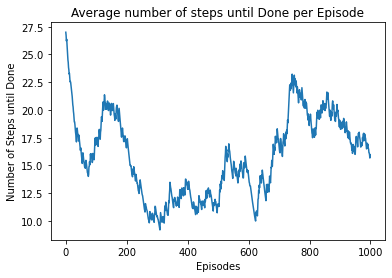

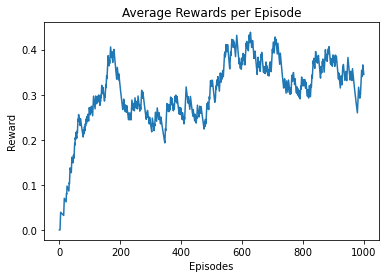

In [28]:
# Plot the performance
N_moves_save = pd.DataFrame(N_moves_save, columns = ['N_moves'])
N_moves_save['N_moves'] = N_moves_save['N_moves'].ewm(span=100, adjust=False).mean()


plt.plot(N_moves_save['N_moves'])
plt.xlabel('Episodes')
plt.ylabel('Number of Steps until Done')
plt.title('Average number of steps until Done per Episode')
plt.show()

R_save = pd.DataFrame(R_save, columns = ['R_save'])
R_save['R_save'] = R_save['R_save'].ewm(span=100, adjust=False).mean()

plt.plot(R_save)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Average Rewards per Episode')
plt.show()

In [13]:
# Q -learning

for n in range(N_episodes):
    S,X,allowed_a=env.Initialise_game()
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
  
    
    while (Done==0 and i<50):                           ## START THE EPISODE
       
        Qvalues = ComputeQvalues(W1, W2, bias_W1, bias_W2, X, activfunction)  
        a=EpsilonGreedy_Policy(Qvalues,epsilon_f, allowed_a)
        S_next, X_next,allowed_a_next,R,Done=env.OneStep(a)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            R_save[n,]=np.copy(R)
            print(i)
            N_moves_save[n,]=i
            print(N_moves_save[n,])
            
            delta=R-Qvalues[a]
            H = np.matmul(W1,X)+bias_W1
            W2[a,:]=W2[a,:]+eta*delta*H
            
            delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
            W1[:,:]=W1[:,:]+ eta*delta
        
            
            ## TO DO: update biases 
            break
       
  
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            Qvalues1=ComputeQvalues(W1, W2, bias_W1, bias_W2, X_next, activfunction)
            a1=EpsilonGreedy_Policy(Qvalues1,0, allowed_a_next)

            # Compute the delta
            delta=R+gamma*Qvalues1[a1]-Qvalues[a]

            # Update the weights
            H = np.matmul(W1,X)+bias_W1
            W2[a,:]=W2[a,:]+eta*delta*H
            
            delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
            W1[:,:]=W1[:,:]+ eta*delta
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)
       

        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS



5
[5.]
3
[3.]
1
[1.]
28
[28.]
10
[10.]


C:\Users\adria\AppData\Local\Temp\ipykernel_59400\4002628119.py:11: RuntimeWarning: overflow encountered in matmul
  Qvalues = np.matmul(W2,X1)+bias_W2
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\3634133120.py:53: RuntimeWarning: invalid value encountered in multiply
  delta =  W2[a,:].reshape(200, 1)*X.reshape(1, 58)
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\4002628119.py:5: RuntimeWarning: invalid value encountered in matmul
  H1 = np.matmul(W1,X)+bias_W1 ## make sure that bias_W1 does not need to be transposed
C:\Users\adria\AppData\Local\Temp\ipykernel_59400\3634133120.py:27: RuntimeWarning: invalid value encountered in matmul
  H = np.matmul(W1,X)+bias_W1


27
[27.]
1
[1.]
18
[18.]
37
[37.]
5
[5.]
5
[5.]
2
[2.]
37
[37.]
5
[5.]
3
[3.]
13
[13.]
14
[14.]
12
[12.]
14
[14.]
1
[1.]
9
[9.]
14
[14.]
1
[1.]
16
[16.]
11
[11.]
19
[19.]
22
[22.]
1
[1.]
21
[21.]
1
[1.]
15
[15.]
19
[19.]
3
[3.]
6
[6.]
1
[1.]
15
[15.]
7
[7.]
14
[14.]
1
[1.]
24
[24.]
36
[36.]
1
[1.]
3
[3.]
15
[15.]
30
[30.]
3
[3.]
7
[7.]
7
[7.]
27
[27.]
1
[1.]
34
[34.]
15
[15.]
15
[15.]
6
[6.]
27
[27.]
1
[1.]
1
[1.]
19
[19.]
31
[31.]
10
[10.]
1
[1.]
1
[1.]
1
[1.]
1
[1.]
45
[45.]
8
[8.]
13
[13.]
21
[21.]
17
[17.]
3
[3.]
19
[19.]
2
[2.]
22
[22.]
11
[11.]
12
[12.]
25
[25.]
12
[12.]
1
[1.]
10
[10.]
10
[10.]
1
[1.]
19
[19.]
15
[15.]
35
[35.]
24
[24.]
1
[1.]
10
[10.]
12
[12.]
4
[4.]
1
[1.]
7
[7.]
7
[7.]
31
[31.]
12
[12.]
7
[7.]
14
[14.]
5
[5.]
3
[3.]
1
[1.]
3
[3.]
45
[45.]
11
[11.]
18
[18.]
3
[3.]
6
[6.]
35
[35.]
2
[2.]
2
[2.]
16
[16.]
22
[22.]
2
[2.]
19
[19.]
4
[4.]
10
[10.]
21
[21.]
3
[3.]
3
[3.]
4
[4.]
9
[9.]
30
[30.]
1
[1.]
1
[1.]
14
[14.]
15
[15.]
1
[1.]
12
[12.]
4
[4.]
1
[1.]
3
[3.]
1
[1